# Introduction

We use char2char NLM using seq2seq + Attention model.

The encoder-decoder follows seq2seq model.

The decoding is based on attending to the encoder + the current decoder state.
The attention model follows: Luong et al., 2015 (https://arxiv.org/abs/1508.04025) instead of the traditional Bahadanau et al., 2014 (https://arxiv.org/abs/1409.0473). The implementation of attention follows this blog: https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html. The reason to choose that is that the attention level is working at the output level of the LSTM, while Bahdanau attention needs to work at the state level of the encoder.

Planning to move to Attention() layer from fast.ai Jeremy Howard implementation: https://github.com/fastai/courses/blob/master/deeplearning2/attention_wrapper.py, which is following Bahdanau attention. 

# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
from utils import *
import pdb
%matplotlib inline

Using TensorFlow backend.


In [2]:

gpu_alloc("1")

# Load data

In [3]:
data_path = '.'
file_name = 'wonderland.txt'

In [4]:
num_samples = 100000
full_file_name = os.path.join(data_path, file_name)
raw_texts = load_data(full_file_name, num_samples)
print(raw_texts[:200])

["ALICE'S ADVENTURES IN WONDERLAND\n", '\n', 'Lewis Carroll\n', '\n', 'THE MILLENNIUM FULCRUM EDITION 3.0\n', '\n', 'CHAPTER I. Down the Rabbit-Hole\n', '\n', 'Alice was beginning to get very tired of sitting by her sister on the\n', 'bank, and of having nothing to do: once or twice she had peeped into the\n', 'book her sister was reading, but it had no pictures or conversations in\n', "it, 'and what is the use of a book,' thought Alice 'without pictures or\n", "conversations?'\n", '\n', 'So she was considering in her own mind (as well as she could, for the\n', 'hot day made her feel very sleepy and stupid), whether the pleasure\n', 'of making a daisy-chain would be worth the trouble of getting up and\n', 'picking the daisies, when suddenly a White Rabbit with pink eyes ran\n', 'close by her.\n', '\n', 'There was nothing so VERY remarkable in that; nor did Alice think it so\n', "VERY much out of the way to hear the Rabbit say to itself, 'Oh dear!\n", "Oh dear! I shall be late!' (when s

In [5]:


in_seq_len = 20
out_seq_len = 20
input_texts, target_texts = generate_lm_data(raw_texts, in_seq_len, out_seq_len)

In [6]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

38429
Alice was beginning  
 	to get very tired of

lice was beginning t 
 	o get very tired of 

ice was beginning to 
 	 get very tired of s

ce was beginning to  
 	get very tired of si

e was beginning to g 
 	et very tired of sit

 was beginning to ge 
 	t very tired of sitt

was beginning to get 
 	 very tired of sitti

as beginning to get  
 	very tired of sittin

s beginning to get v 
 	ery tired of sitting

 beginning to get ve 
 	ry tired of sitting 



## Build vocab

In [7]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab)

In [8]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts]) + 2 # For '\t' and '\n'
max_decoder_seq_length = max([len(txt) for txt in target_texts]) + 2

In [9]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 38429
Number of unique input tokens: 67
Number of unique output tokens: 67
Max sequence length for inputs: 22
Max sequence length for outputs: 24


In [10]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 57,
 '"': 60,
 "'": 26,
 '(': 30,
 ')': 31,
 ',': 23,
 '-': 42,
 '.': 51,
 ':': 18,
 ';': 37,
 '?': 55,
 'A': 27,
 'B': 63,
 'C': 41,
 'D': 49,
 'E': 35,
 'F': 62,
 'G': 46,
 'H': 52,
 'I': 50,
 'J': 65,
 'K': 40,
 'L': 48,
 'M': 47,
 'N': 45,
 'O': 38,
 'P': 43,
 'Q': 64,
 'R': 33,
 'S': 56,
 'T': 39,
 'U': 53,
 'UNK': 0,
 'V': 34,
 'W': 32,
 'Y': 36,
 'Z': 54,
 '[': 66,
 'a': 21,
 'b': 16,
 'c': 19,
 'd': 12,
 'e': 7,
 'f': 13,
 'g': 6,
 'h': 17,
 'i': 11,
 'j': 44,
 'k': 25,
 'l': 28,
 'm': 29,
 'n': 15,
 'o': 5,
 'p': 22,
 'q': 58,
 'r': 9,
 's': 14,
 't': 4,
 'u': 24,
 'v': 8,
 'w': 20,
 'x': 59,
 'y': 10,
 'z': 61}

In [11]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 't',
 5: 'o',
 6: 'g',
 7: 'e',
 8: 'v',
 9: 'r',
 10: 'y',
 11: 'i',
 12: 'd',
 13: 'f',
 14: 's',
 15: 'n',
 16: 'b',
 17: 'h',
 18: ':',
 19: 'c',
 20: 'w',
 21: 'a',
 22: 'p',
 23: ',',
 24: 'u',
 25: 'k',
 26: "'",
 27: 'A',
 28: 'l',
 29: 'm',
 30: '(',
 31: ')',
 32: 'W',
 33: 'R',
 34: 'V',
 35: 'E',
 36: 'Y',
 37: ';',
 38: 'O',
 39: 'T',
 40: 'K',
 41: 'C',
 42: '-',
 43: 'P',
 44: 'j',
 45: 'N',
 46: 'G',
 47: 'M',
 48: 'L',
 49: 'D',
 50: 'I',
 51: '.',
 52: 'H',
 53: 'U',
 54: 'Z',
 55: '?',
 56: 'S',
 57: '!',
 58: 'q',
 59: 'x',
 60: '"',
 61: 'z',
 62: 'F',
 63: 'B',
 64: 'Q',
 65: 'J',
 66: '['}

In [12]:
len(int_to_vocab)

67

# Prepare training data

## Train/test split

In [13]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [30]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [15]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(32664, 22)
(32664, 22, 67)


## Test data

In [16]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [17]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [18]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 67)     4489        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/home/elsallab/Work/cod/READ/utils.py:458: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)


# Training

In [19]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [20]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [22]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [23]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [24]:
#callbacks_list.append(lrate)

In [31]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.1,
          shuffle=True)

Train on 29397 samples, validate on 3267 samples
Epoch 1/20
29397/29397 [==============================] - 44s 1ms/step - loss: 0.2067 - categorical_accuracy: 0.8864 - val_loss: 0.3913 - val_categorical_accuracy: 0.8422

Epoch 00001: val_categorical_accuracy did not improve from 0.84394
Epoch 2/20
29397/29397 [==============================] - 44s 1ms/step - loss: 0.2080 - categorical_accuracy: 0.8857 - val_loss: 0.4052 - val_categorical_accuracy: 0.8390

Epoch 00002: val_categorical_accuracy did not improve from 0.84394
Epoch 3/20
29056/29397 [============================>.] - ETA: 0s - loss: 0.2163 - categorical_accuracy: 0.8827

KeyboardInterrupt: 

In [26]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Inference

In [27]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = input_texts[seq_index]
    target_text = target_texts[seq_index][1:-1]

    encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[input_text],
                                                                                 target_texts=[target_text], 
                                                                                 max_encoder_seq_length=max_encoder_seq_length, 
                                                                                 num_encoder_tokens=num_encoder_tokens, 
                                                                                 vocab_to_int=vocab_to_int)    

    input_seq = encoder_input_data
    #target_seq = np.argmax(decoder_target_data, axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)
    #results.write(' | ' + input_text + ' | ' + target_text.strip() + ' | ' + decoded_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    #corrected_sentences.append(corrected_sentence)
    #corrected_input_sentences.append(corrected_input_sentence)
    target_texts_.append(target_text)




-
Input sentence: couldn't help it,' s
GT sentence: aid Five, in a sulky
Decoded sentence: aid Five in a s,lky
-
Input sentence: atched the White Rab
GT sentence: bit as he fumbled ov
Decoded sentence: ble it out this same
-
Input sentence: d a little animal (s
GT sentence: he couldn't guess of
Decoded sentence: he could for she (o
-
Input sentence:  seeing the Cheshire
GT sentence:  Cat sitting on a bo
Decoded sentence:  Cat and said 'I m
-
Input sentence: rld would go round a
GT sentence:  deal faster than it
Decoded sentence:  deal faster than it
-
Input sentence:  would EVER happen i
GT sentence: n a natural way agai
Decoded sentence: n a natural way agai
-
Input sentence:  using the ink, that
GT sentence:  was trickling down 
Decoded sentence:  her with larg, roun
-
Input sentence: ff, and she swam nea
GT sentence: rer to make out what
Decoded sentence: r ,hem a reecuse the
-
Input sentence: icers: but the Hatte
GT sentence: r was out of sight b
Decoded sentence: r was:out off at 

-
Input sentence: rms folded, frowning
GT sentence:  like a thunderstorm
Decoded sentence:  to hersel, and sai
-
Input sentence:  say "HOW DOTH THE L
GT sentence: ITTLE BUSY BEE," but
Decoded sentence: ITHE "ill' the Hatt
-
Input sentence: executions I have or
GT sentence: dered'; and she walk
Decoded sentence: dered about and whe
-
Input sentence: d and a large fan in
GT sentence:  the other: he came 
Decoded sentence:  the other he came 
-
Input sentence: ever was so ordered 
GT sentence: about in all my life
Decoded sentence: about it and then A
-
Input sentence: d in a deep voice, '
GT sentence: What are tarts made 
Decoded sentence: What are tarts un,er
-
Input sentence: must manage the best
GT sentence:  way you can;--but I
Decoded sentence:  way into custody as
-
Input sentence: ere were doors all r
GT sentence: ound the hall, but t
Decoded sentence: ound the hedgehog w
-
Input sentence:  the garden at once;
GT sentence:  but, alas for poor 
Decoded sentence:  and growly and ou;

-
Input sentence: Of course they were'
GT sentence: , said the Dormouse;
Decoded sentence: ' said the Dormouse
-
Input sentence: I do wish they WOULD
GT sentence:  put their heads dow
Decoded sentence:  put their happened
-
Input sentence: it had finished this
GT sentence:  short speech, they 
Decoded sentence:  short spet down spl
-
Input sentence: se words were follow
GT sentence: ed by a very long si
Decoded sentence: ing very and lost se
-
Input sentence: he said to herself, 
GT sentence: and shouted out, 'Yo
Decoded sentence: for she had not as,y
-
Input sentence:  of hands at this: i
GT sentence: t was the first real
Decoded sentence: t was the rats th:ng
-
Input sentence: ldn't have put it in
GT sentence:  with the bread-knif
Decoded sentence:  with the breather m
-
Input sentence: you like,' said the 
GT sentence: Footman, and began w
Decoded sentence: Footman,and the arc
-
Input sentence:  beginning to think 
GT sentence: to herself, 'Now, wh
Decoded sentence: to herself 'Now 

-
Input sentence: tle toss of her head
GT sentence:  to keep back the wa
Decoded sentence:  to keep bark to kee
-
Input sentence: rious child was very
GT sentence:  fond of pretending 
Decoded sentence:  for some time our o
-
Input sentence: use had closed its e
GT sentence: yes by this time, an
Decoded sentence: yes aming to herself
-
Input sentence: ld be quite absurd f
GT sentence: or her to carry it f
Decoded sentence: rom the tree in fror
-
Input sentence: od deal: this firepl
GT sentence: ace is narrow, to be
Decoded sentence: ace is :arrow to be
-
Input sentence: he door and found th
GT sentence: at it led into a sma
Decoded sentence: at it led into a sma
-
Input sentence: e had grown in the l
GT sentence: ast few minutes, and
Decoded sentence: ay cfance the office
-
Input sentence: and they don't seem 
GT sentence: to have any rules in
Decoded sentence: to have any rules in
-
Input sentence: e heard the Rabbit j
GT sentence: ust under the window
Decoded sentence: ust a little w

-
Input sentence: oment to be lost: aw
GT sentence: ay went Alice like t
Decoded sentence: ay I should Ali:e s
-
Input sentence: he Owl had the dish 
GT sentence: as its share of the 
Decoded sentence: as its share of the 
-
Input sentence: You'll get used to i
GT sentence: t in time,' said the
Decoded sentence: t in time' said the
-
Input sentence: able for it, she fou
GT sentence: nd she could not pos
Decoded sentence: nd she coul, not pos
-
Input sentence: rthumbria, declared 
GT sentence: for him: and even St
Decoded sentence: him he d,ead all ha
-
Input sentence:  I can't show it you
GT sentence:  myself,' the Mock T
Decoded sentence:  myself' the Mock T
-
Input sentence: sh, who wanted leade
GT sentence: rs, and had been of 
Decoded sentence: rs, out among though
-
Input sentence: lates and pencils ha
GT sentence: d been found and han
Decoded sentence: d been found and han


KeyboardInterrupt: 

# Visualize attention

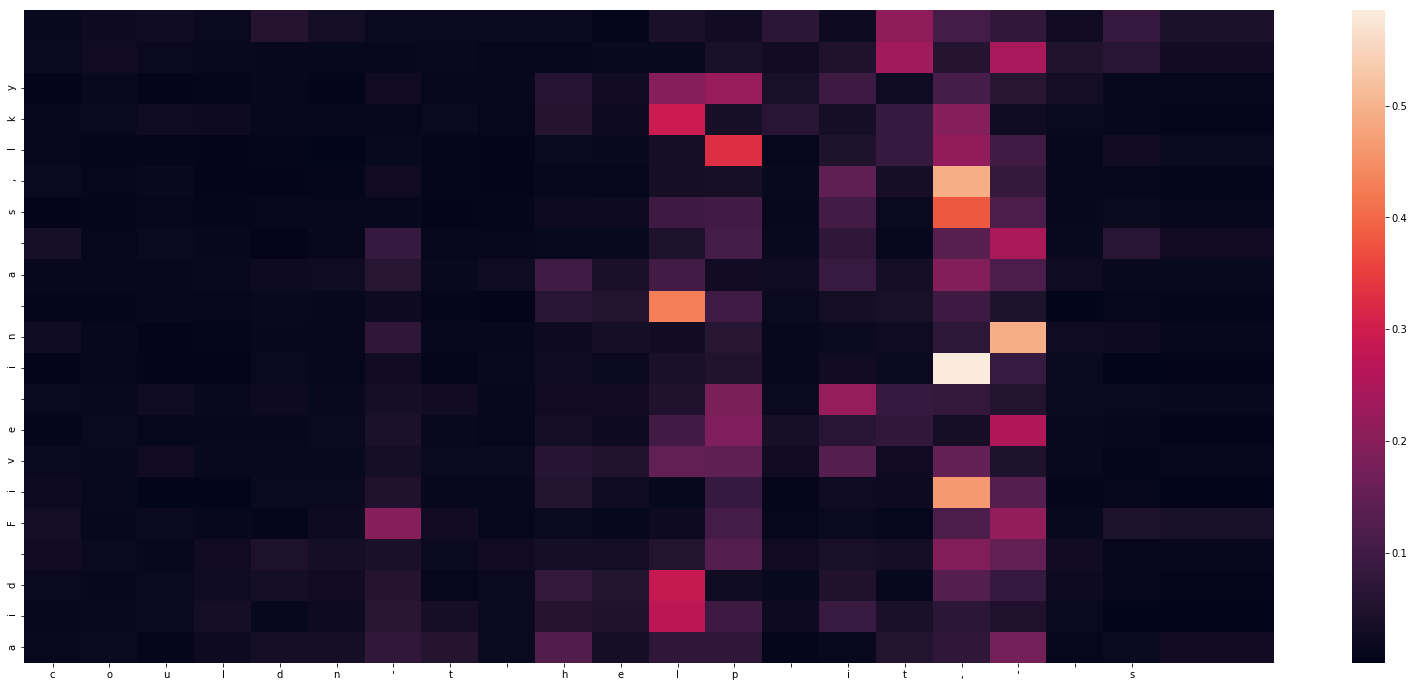

-
Input sentence: couldn't help it,' s
GT sentence: aid Five, in a sulky
Decoded sentence: aid Five in a s,lky


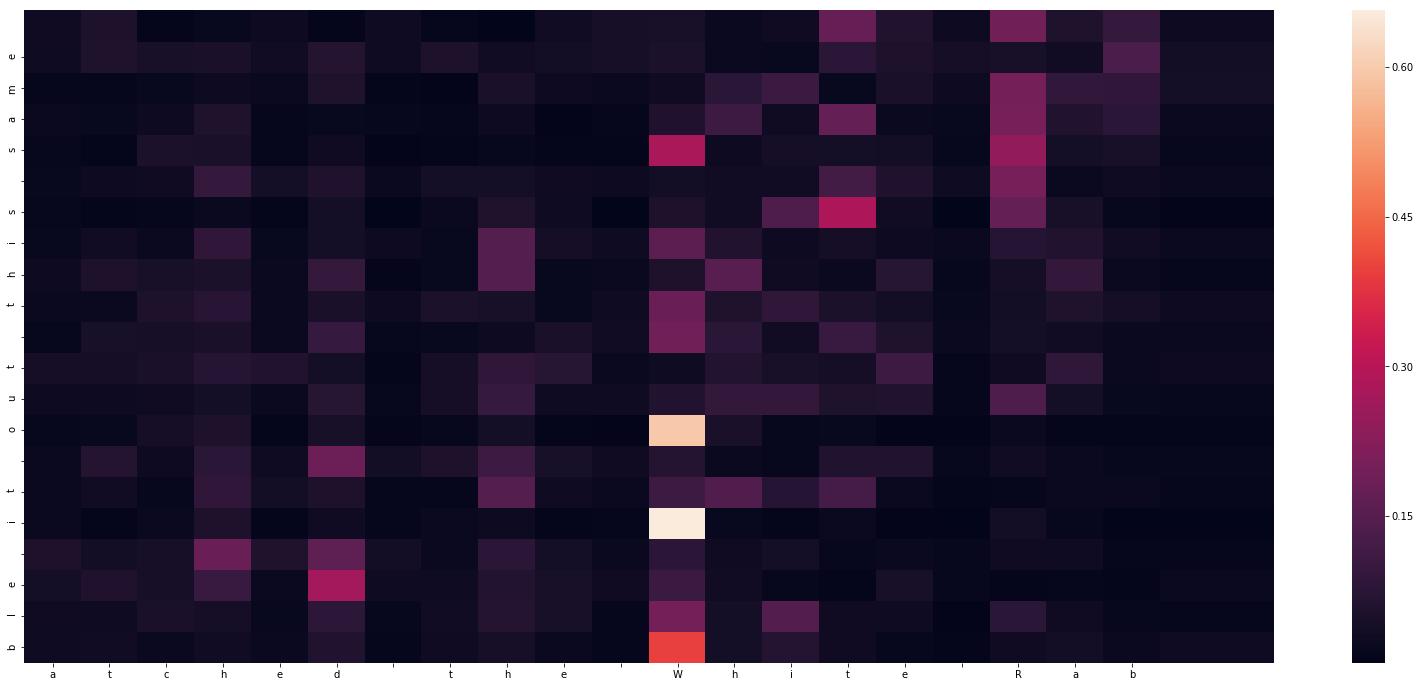

-
Input sentence: atched the White Rab
GT sentence: bit as he fumbled ov
Decoded sentence: ble it out this same


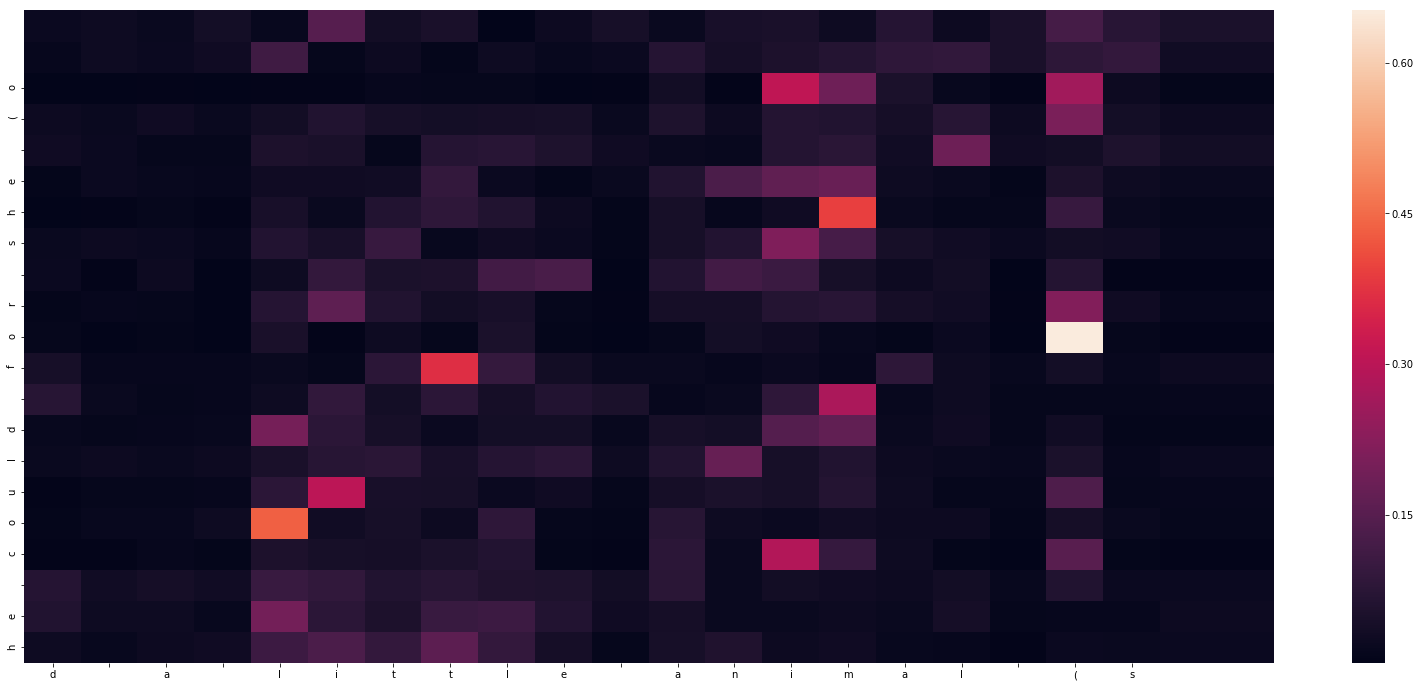

-
Input sentence: d a little animal (s
GT sentence: he couldn't guess of
Decoded sentence: he could for she (o


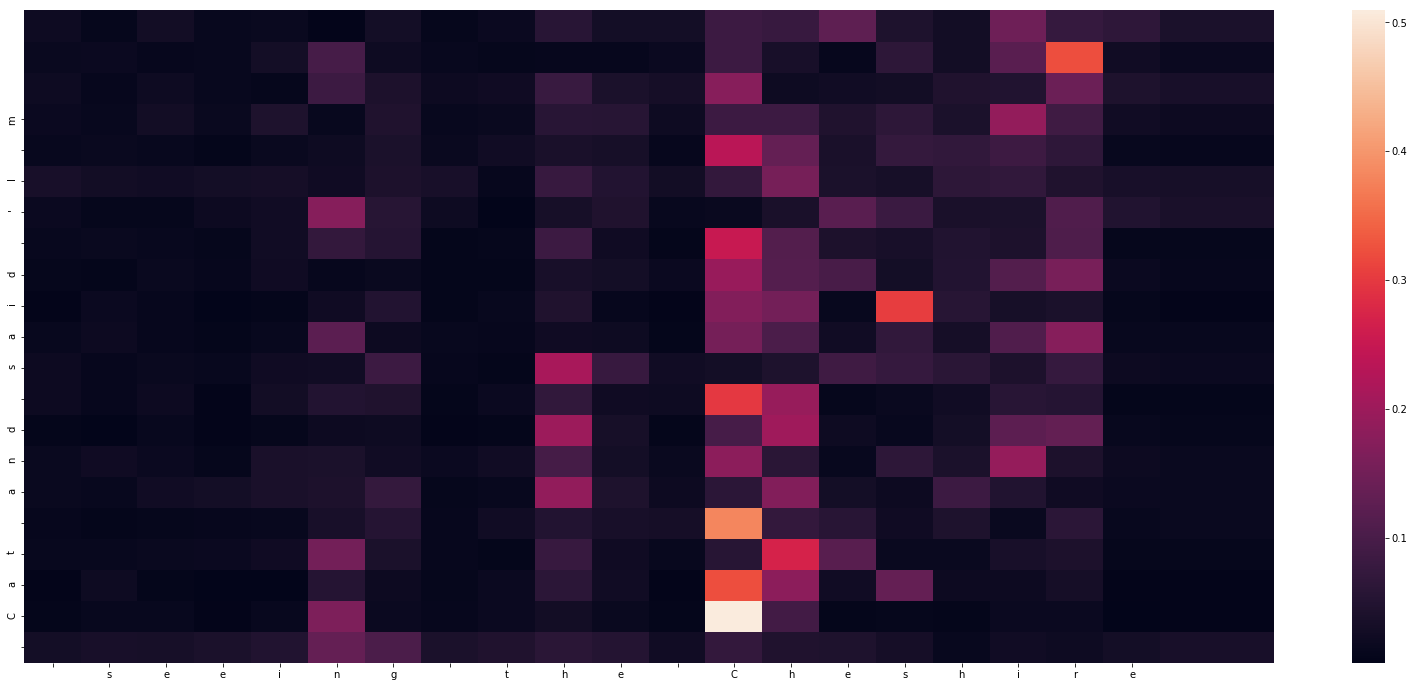

-
Input sentence:  seeing the Cheshire
GT sentence:  Cat sitting on a bo
Decoded sentence:  Cat and said 'I m


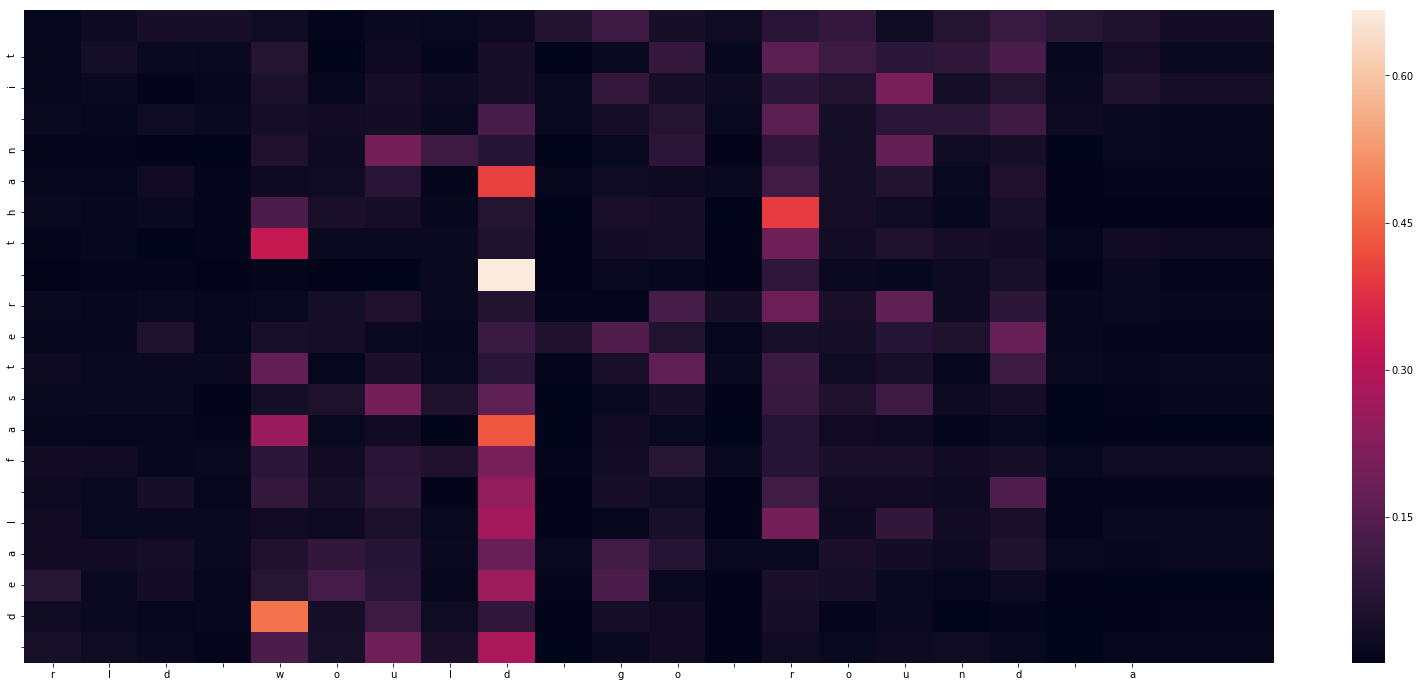

-
Input sentence: rld would go round a
GT sentence:  deal faster than it
Decoded sentence:  deal faster than it


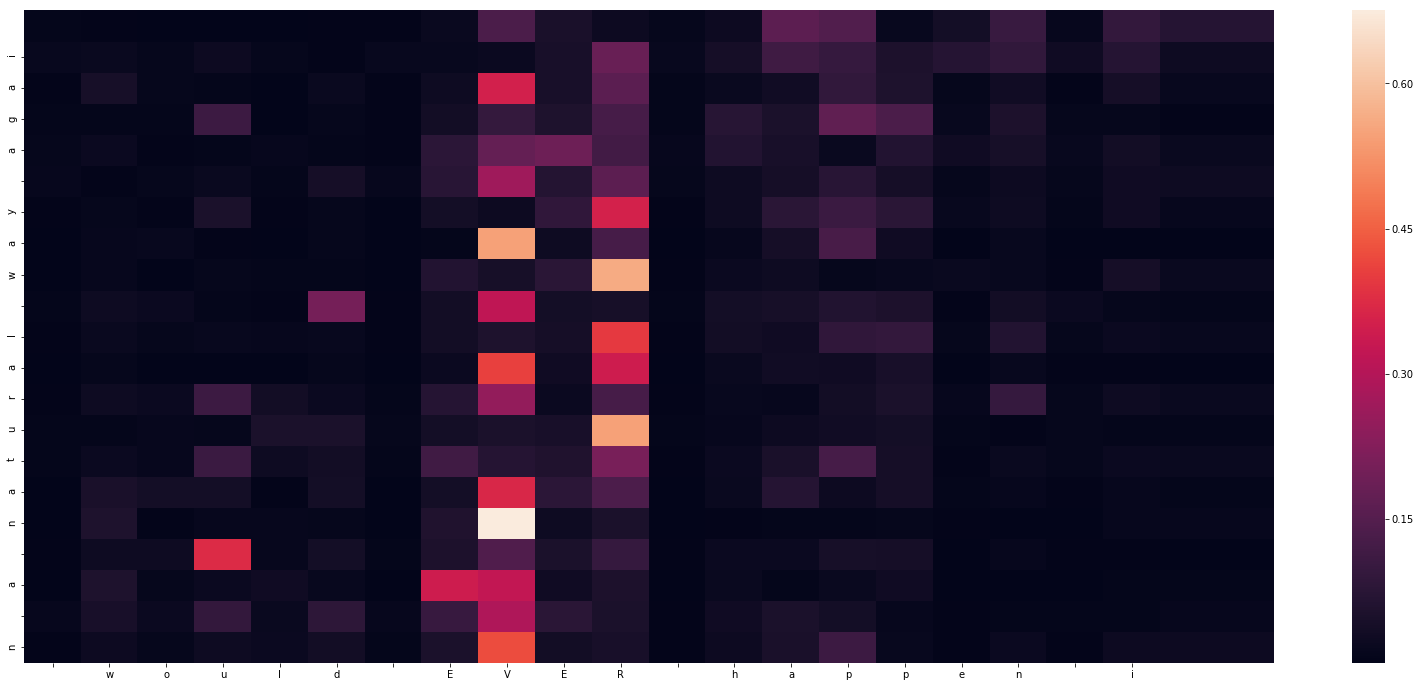

-
Input sentence:  would EVER happen i
GT sentence: n a natural way agai
Decoded sentence: n a natural way agai


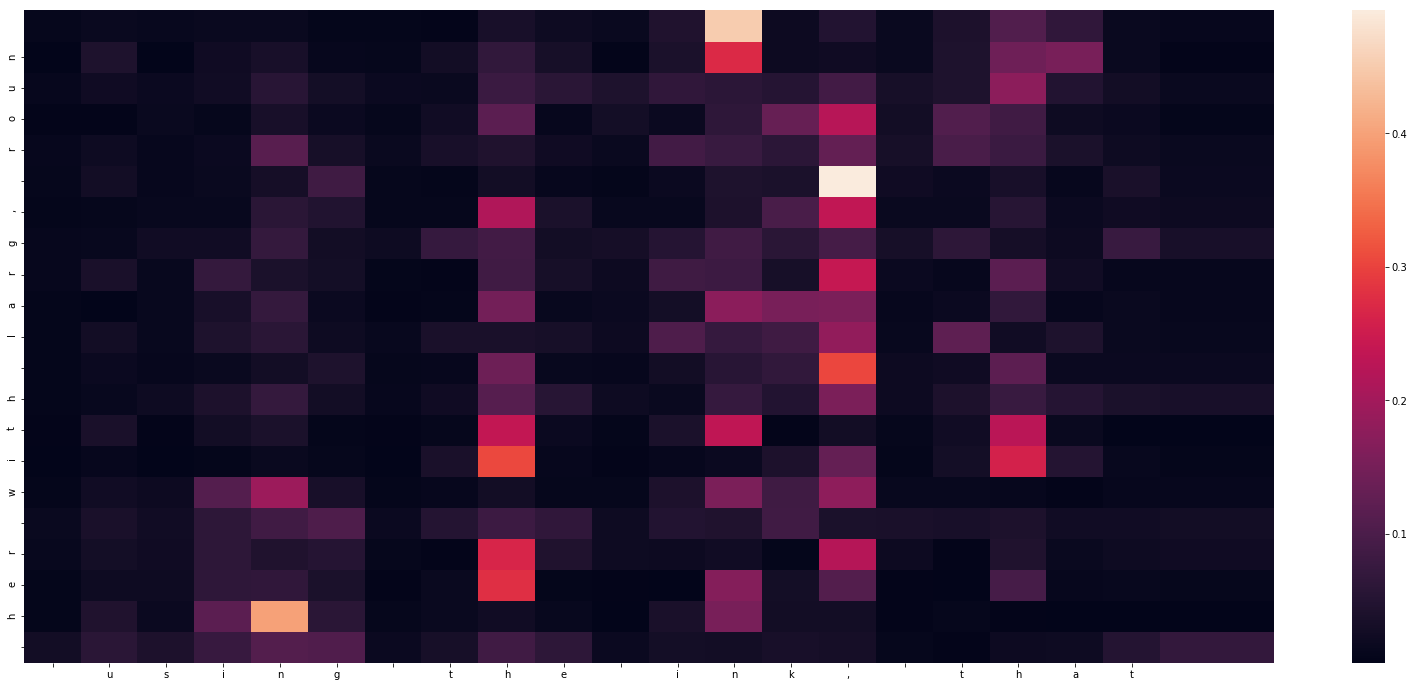

-
Input sentence:  using the ink, that
GT sentence:  was trickling down 
Decoded sentence:  her with larg, roun


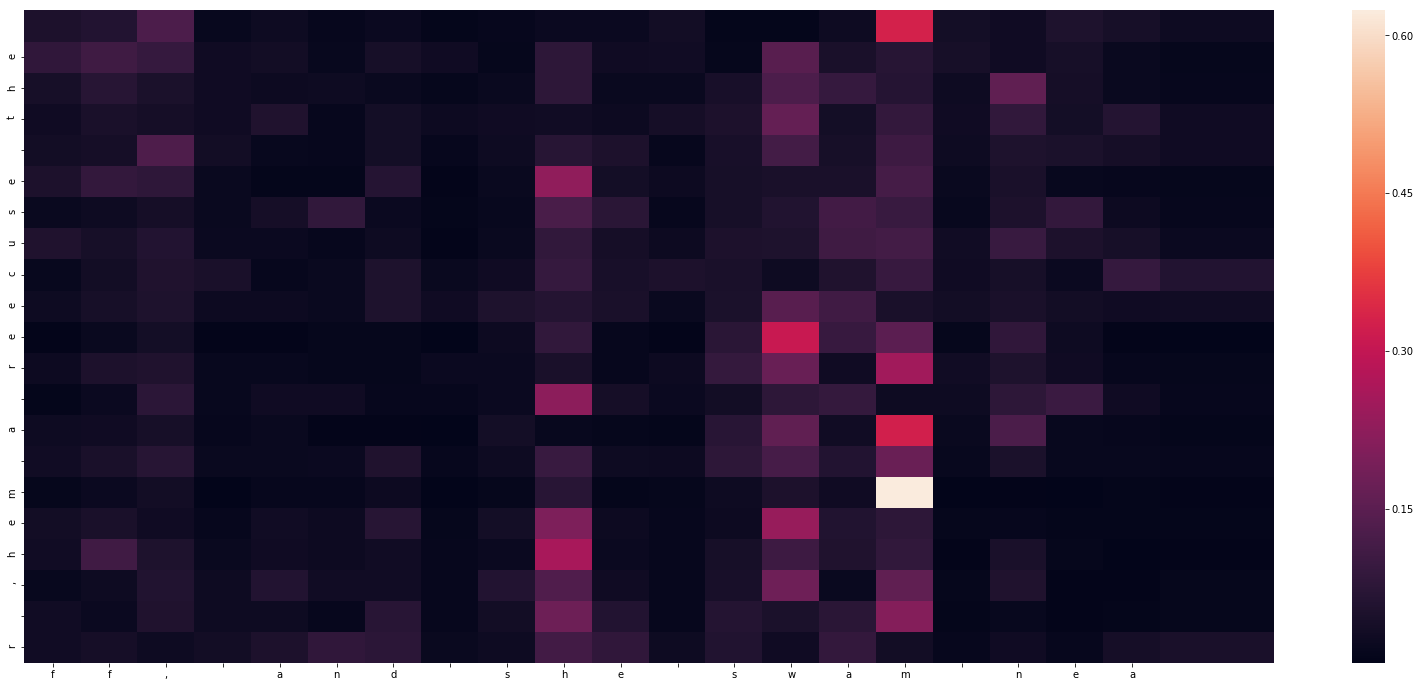

-
Input sentence: ff, and she swam nea
GT sentence: rer to make out what
Decoded sentence: r ,hem a reecuse the


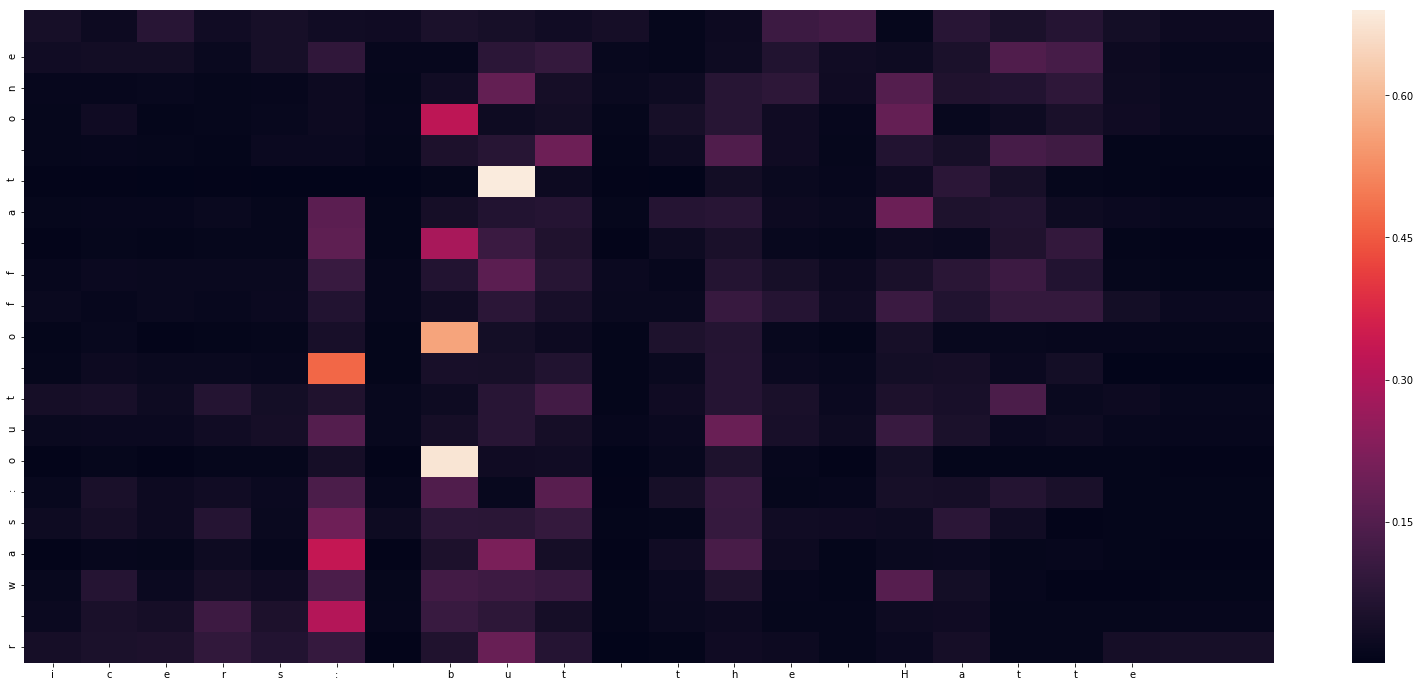

-
Input sentence: icers: but the Hatte
GT sentence: r was out of sight b
Decoded sentence: r was:out off at one


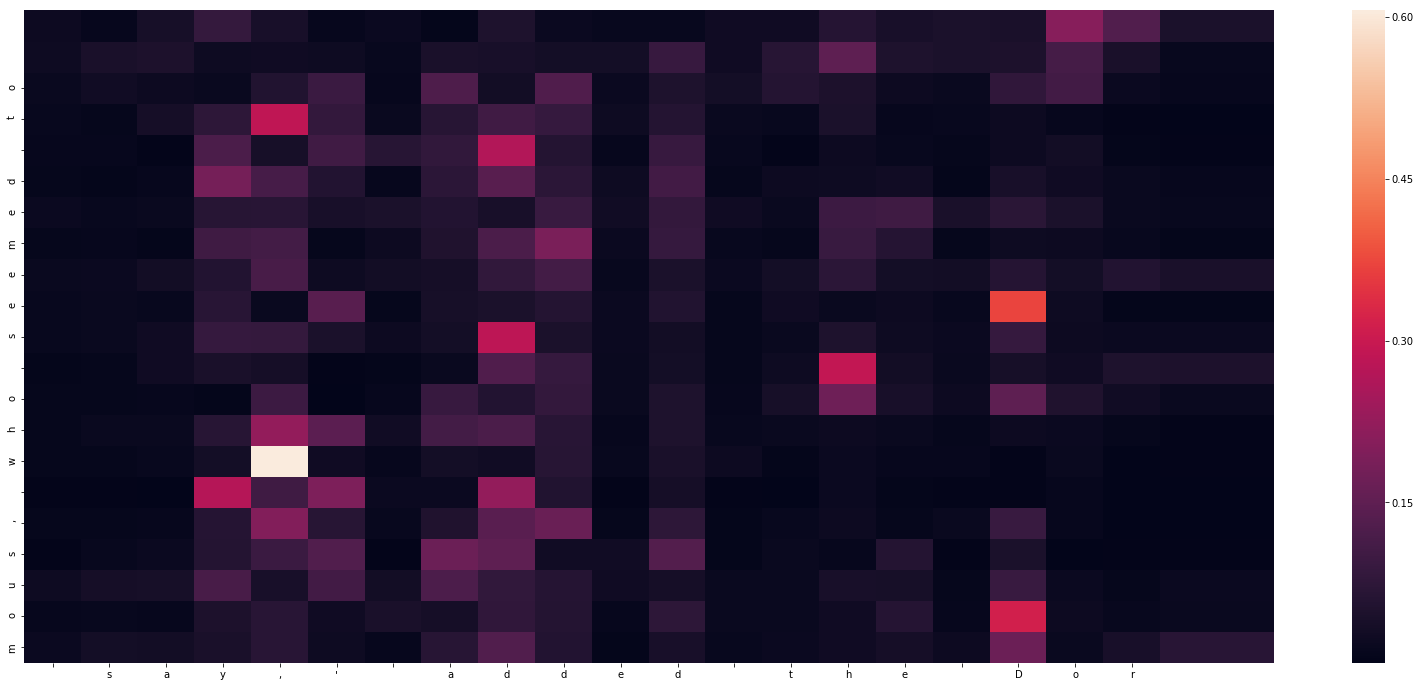

-
Input sentence:  say,' added the Dor
GT sentence: mouse, who seemed to
Decoded sentence: mous, who seemed to


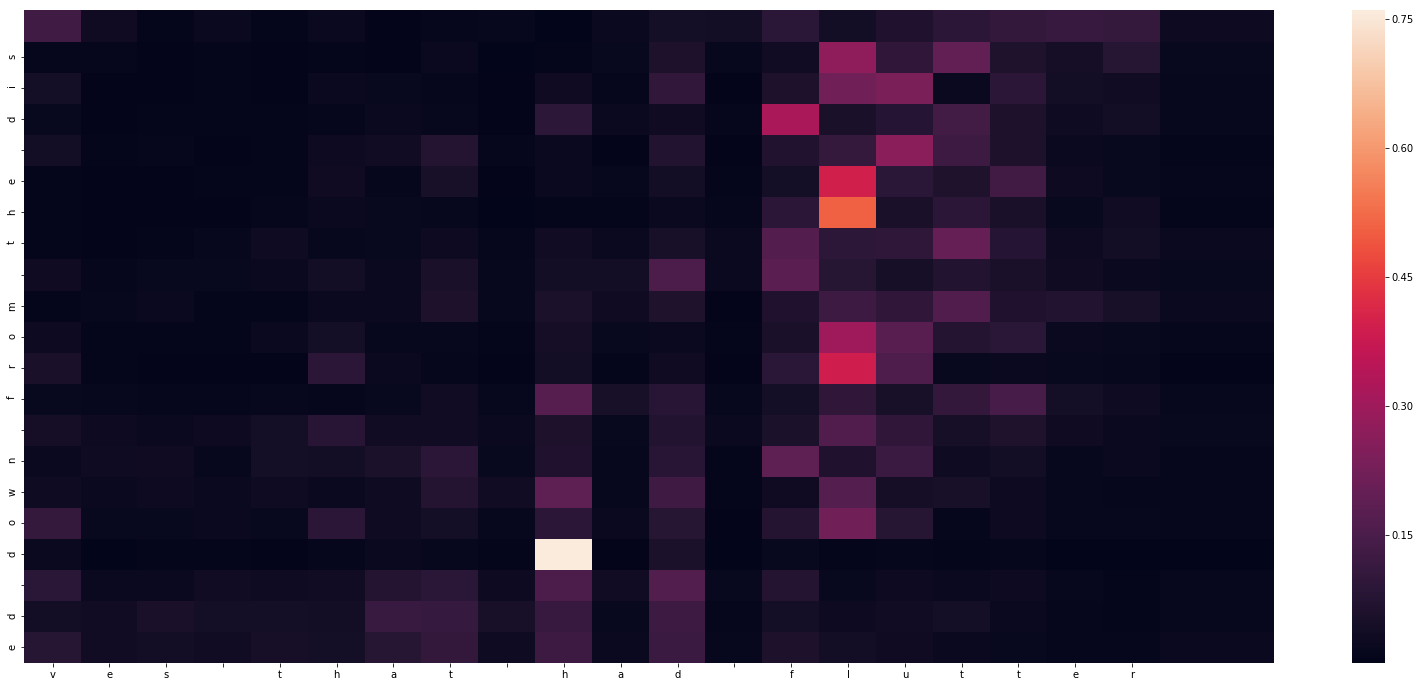

-
Input sentence: ves that had flutter
GT sentence: ed down from the tre
Decoded sentence: ed down from the dis


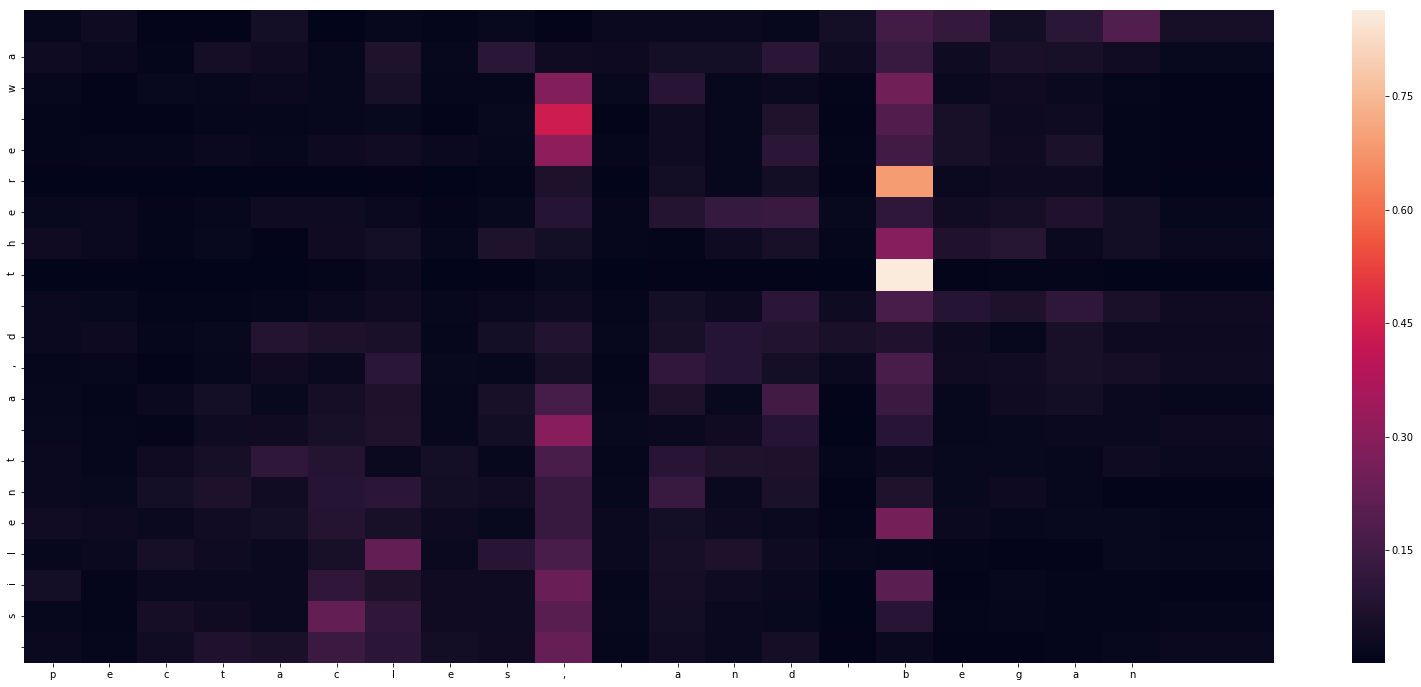

-
Input sentence: pectacles, and began
GT sentence:  staring at the Hatt
Decoded sentence:  silent a,d there wa


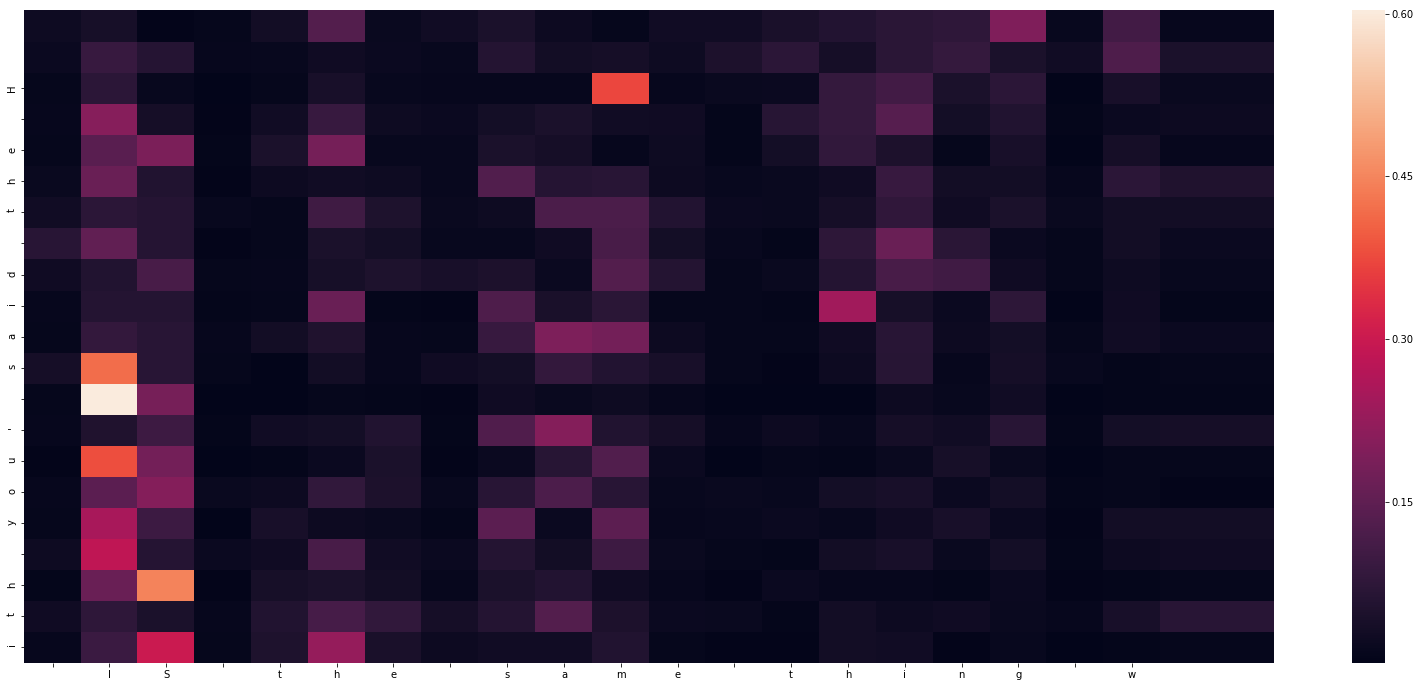

-
Input sentence:  IS the same thing w
GT sentence: ith you,' said the H
Decoded sentence: ith you' said the H


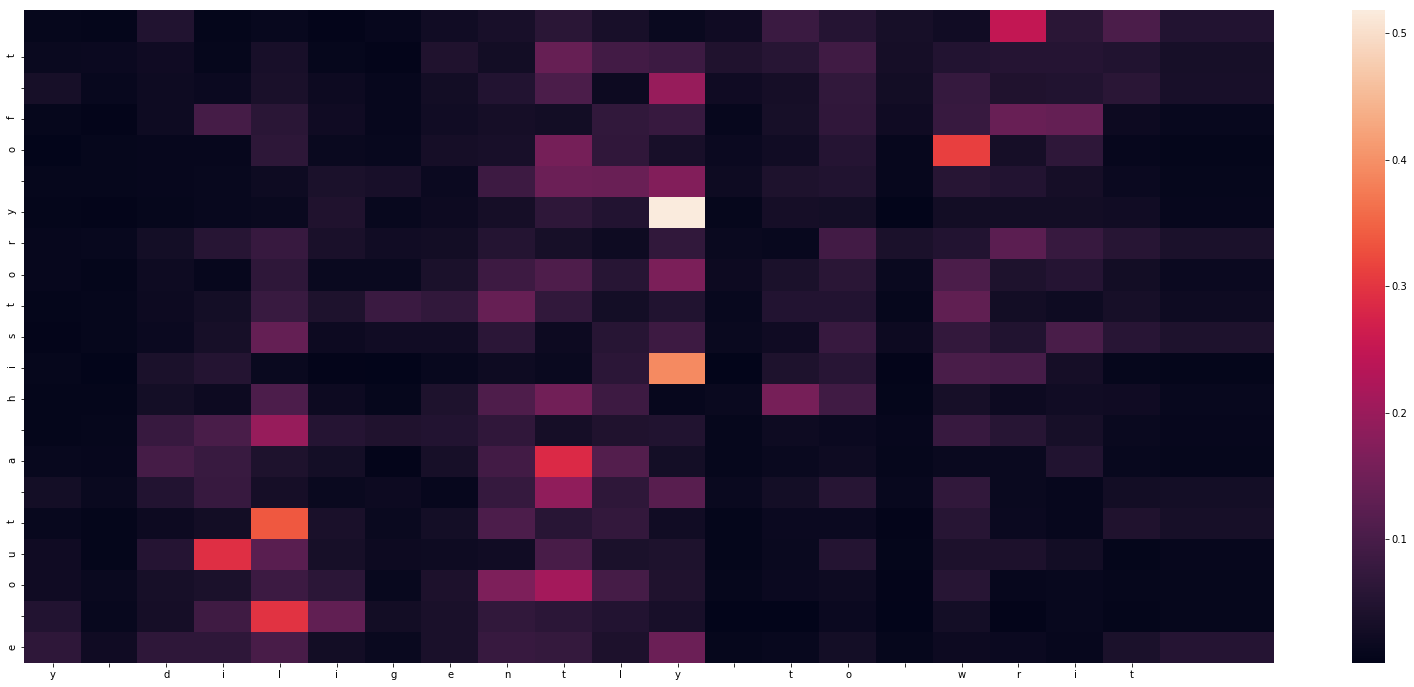

-
Input sentence: y diligently to writ
GT sentence: e out a history of t
Decoded sentence: e out a history of t


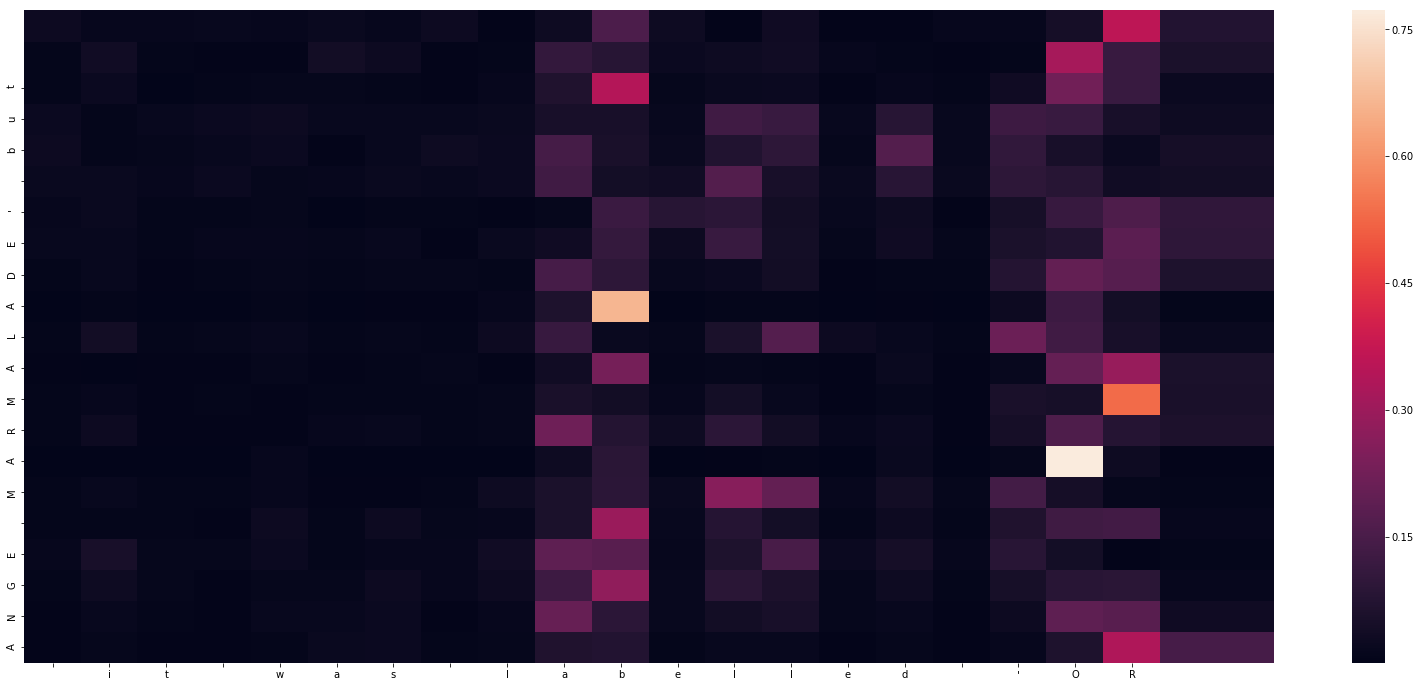

-
Input sentence:  it was labelled 'OR
GT sentence: ANGE MARMALADE', but
Decoded sentence: ANGE MARMALADE' but


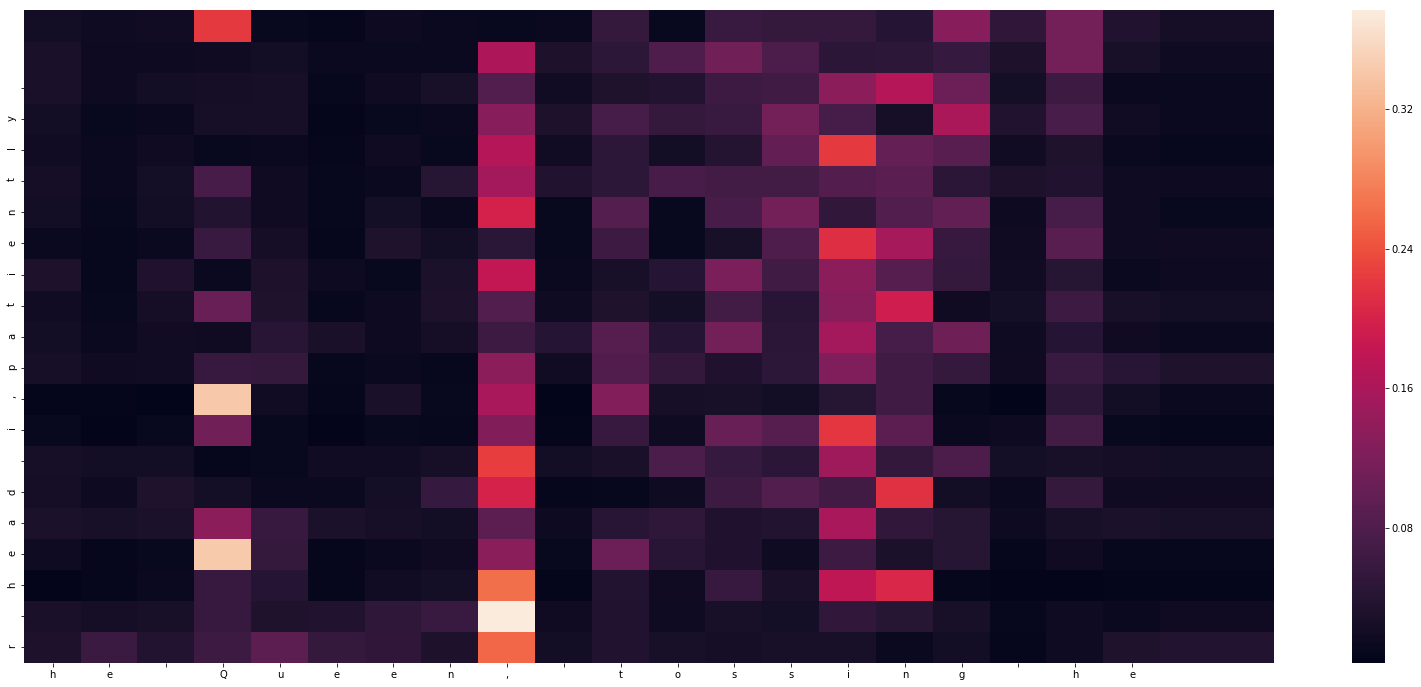

-
Input sentence: he Queen, tossing he
GT sentence: r head impatiently; 
Decoded sentence: r head i,patiently 


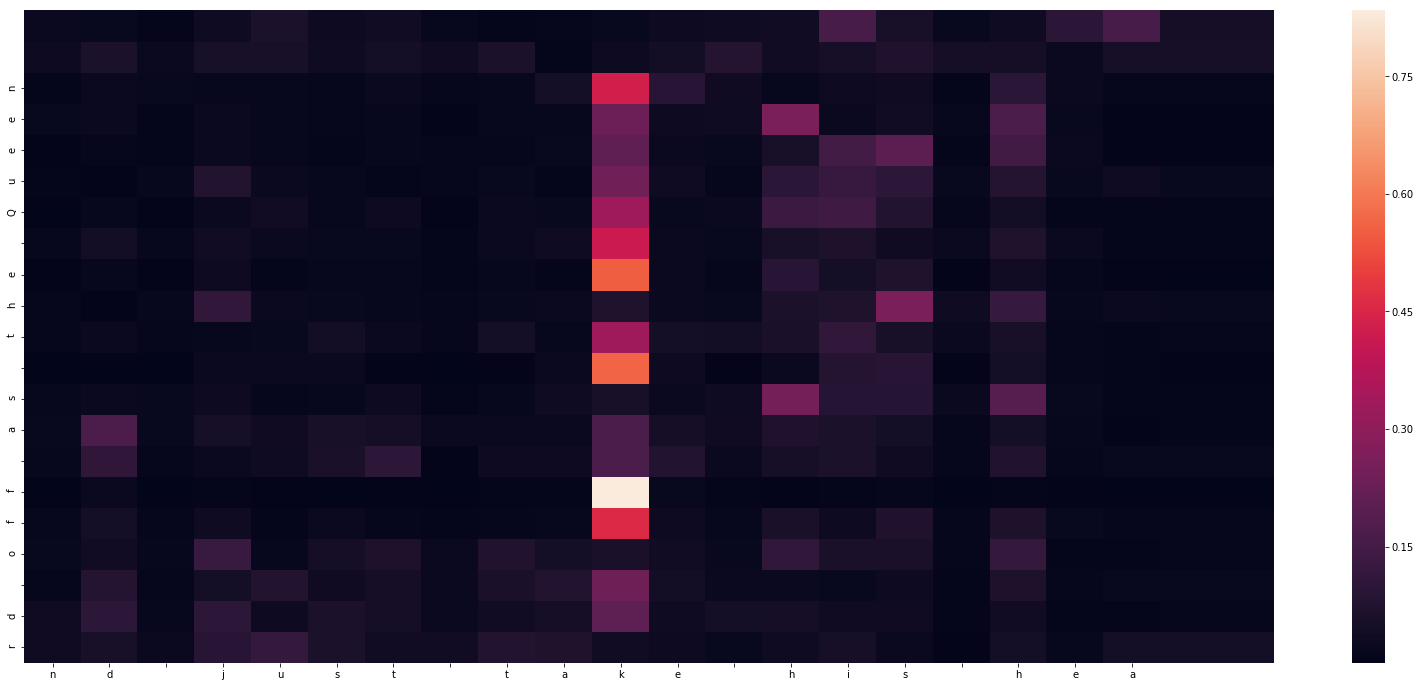

-
Input sentence: nd just take his hea
GT sentence: d off outside,' the 
Decoded sentence: rd off as the Queen


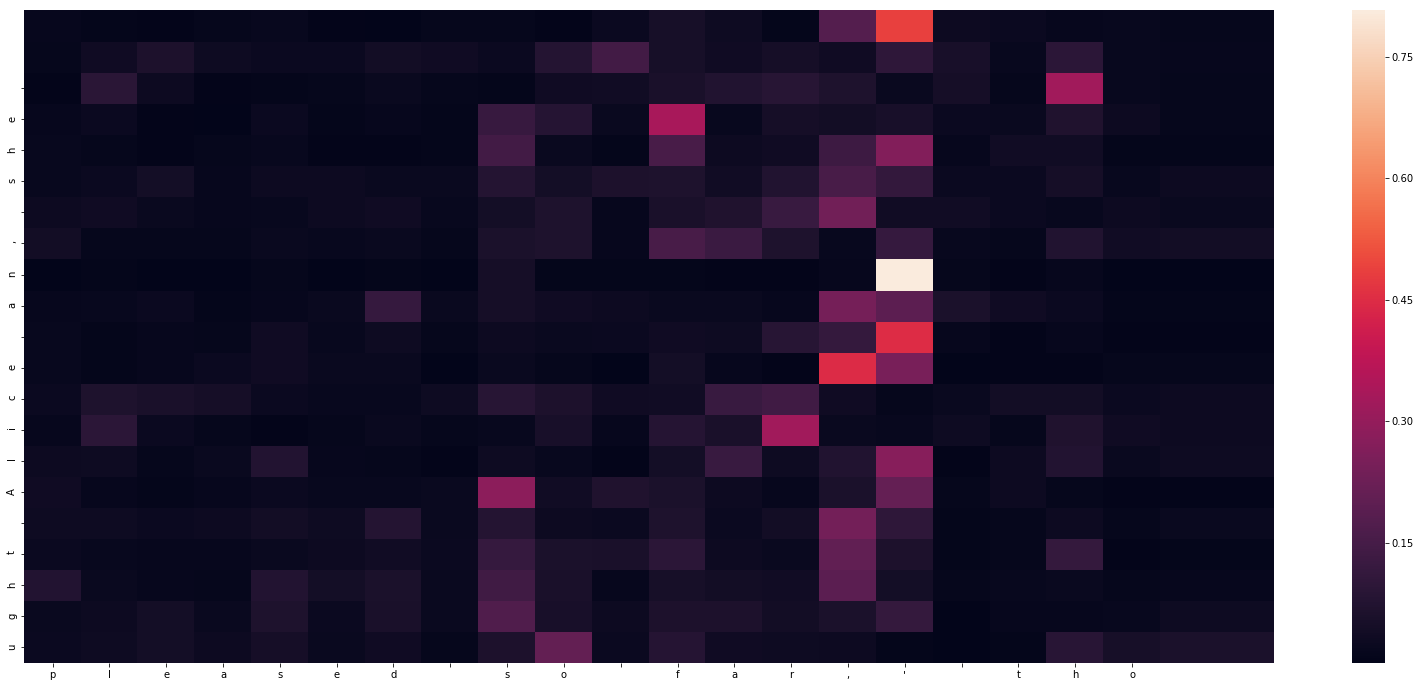

-
Input sentence: pleased so far,' tho
GT sentence: ught Alice, and she 
Decoded sentence: ught Alice an, she 


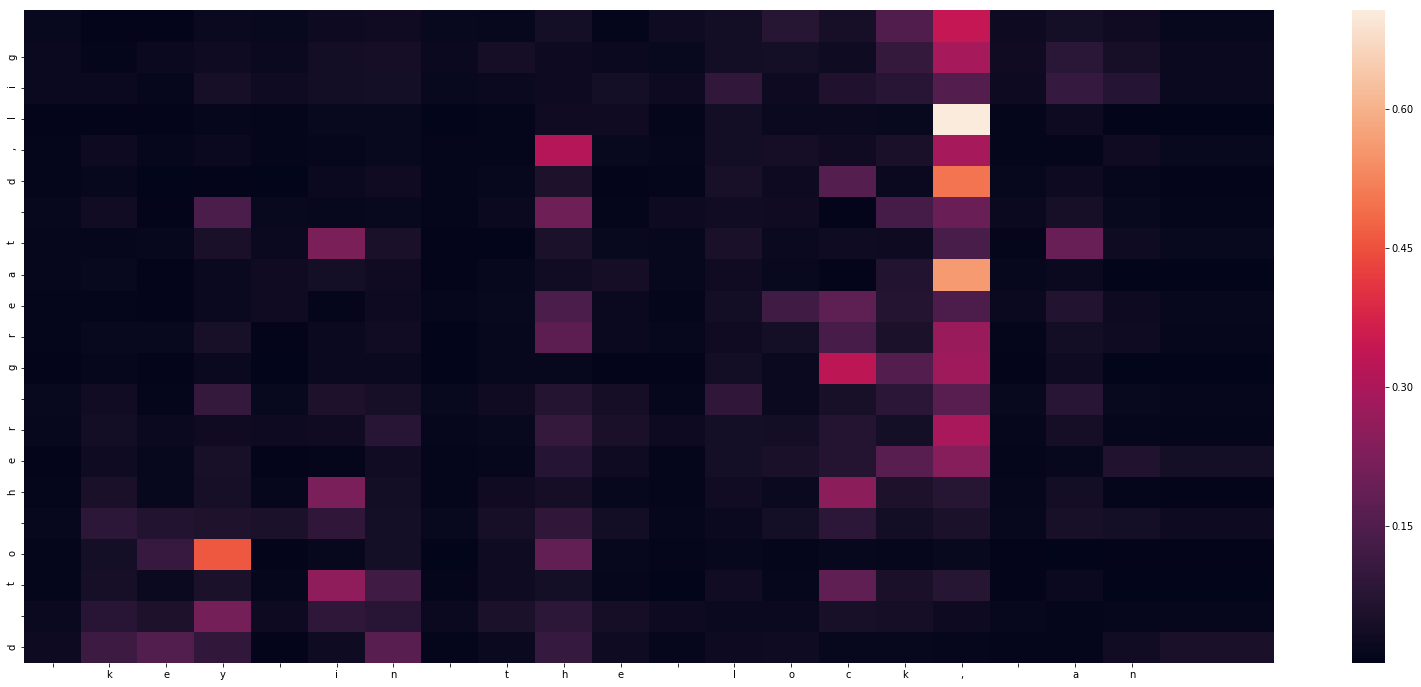

-
Input sentence:  key in the lock, an
GT sentence: d to her great delig
Decoded sentence: d to her great d,lig


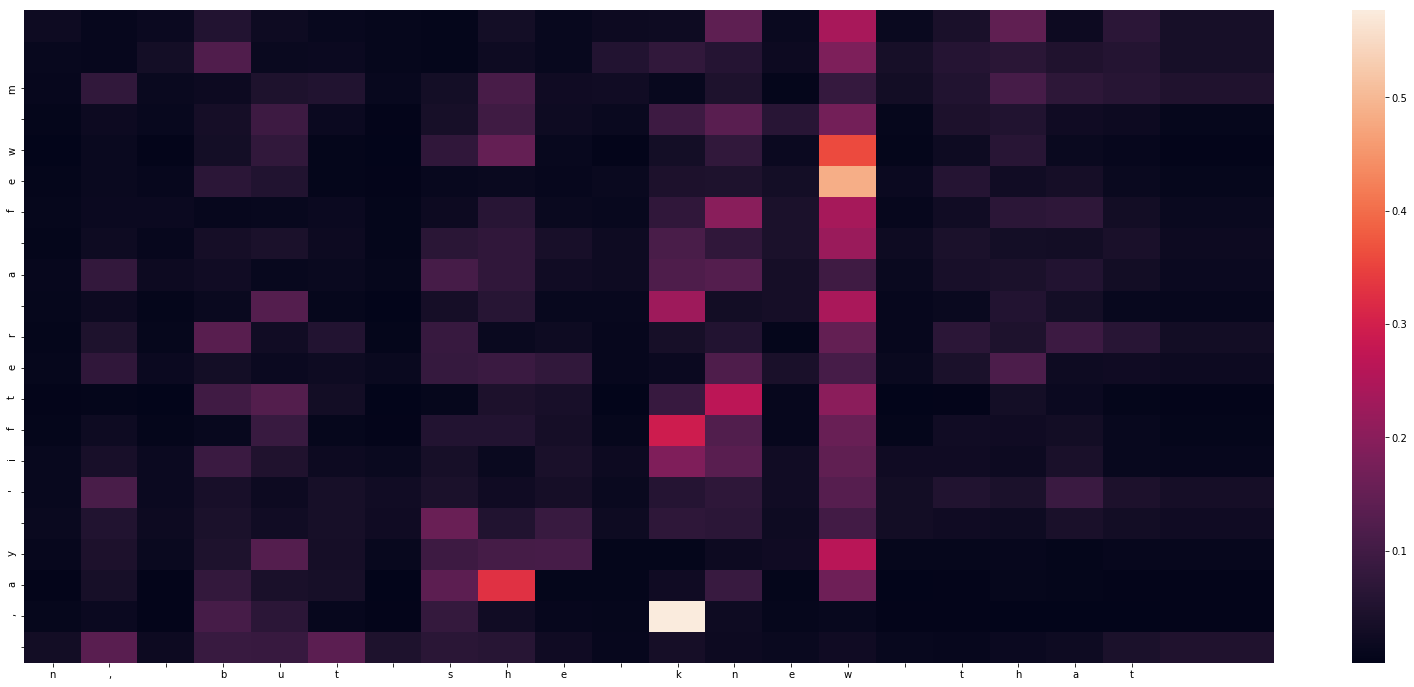

-
Input sentence: n, but she knew that
GT sentence:  it might happen any
Decoded sentence:  ,ay 'ifter a few m


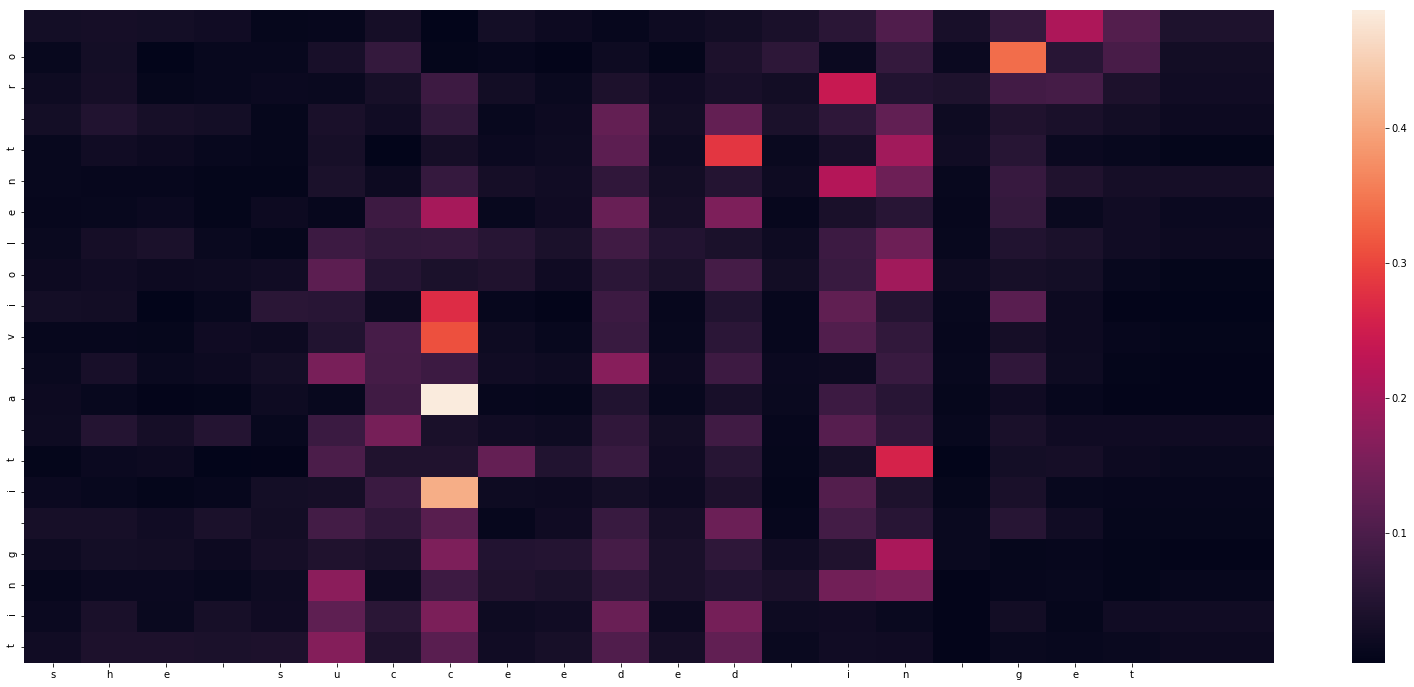

-
Input sentence: she succeeded in get
GT sentence: ting its body tucked
Decoded sentence: ting it a violent ro


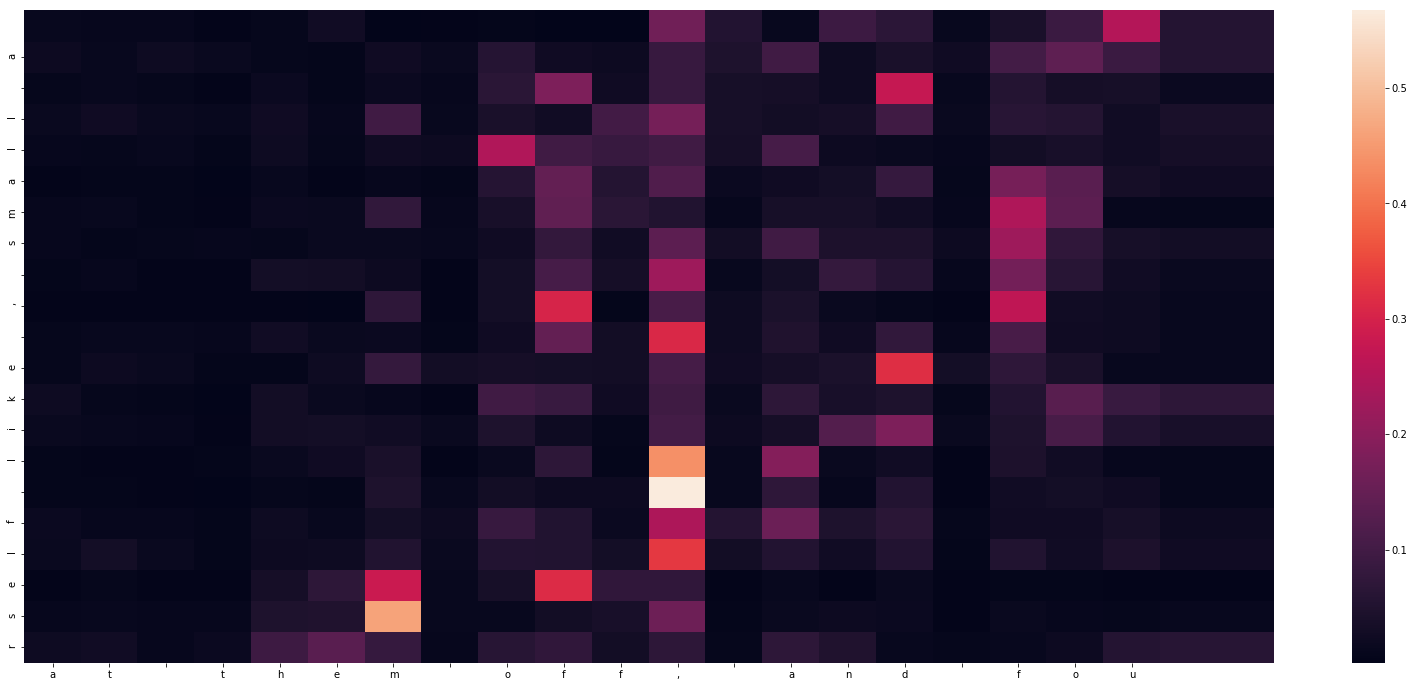

-
Input sentence: at them off, and fou
GT sentence: nd herself lying on 
Decoded sentence: rself like , small a


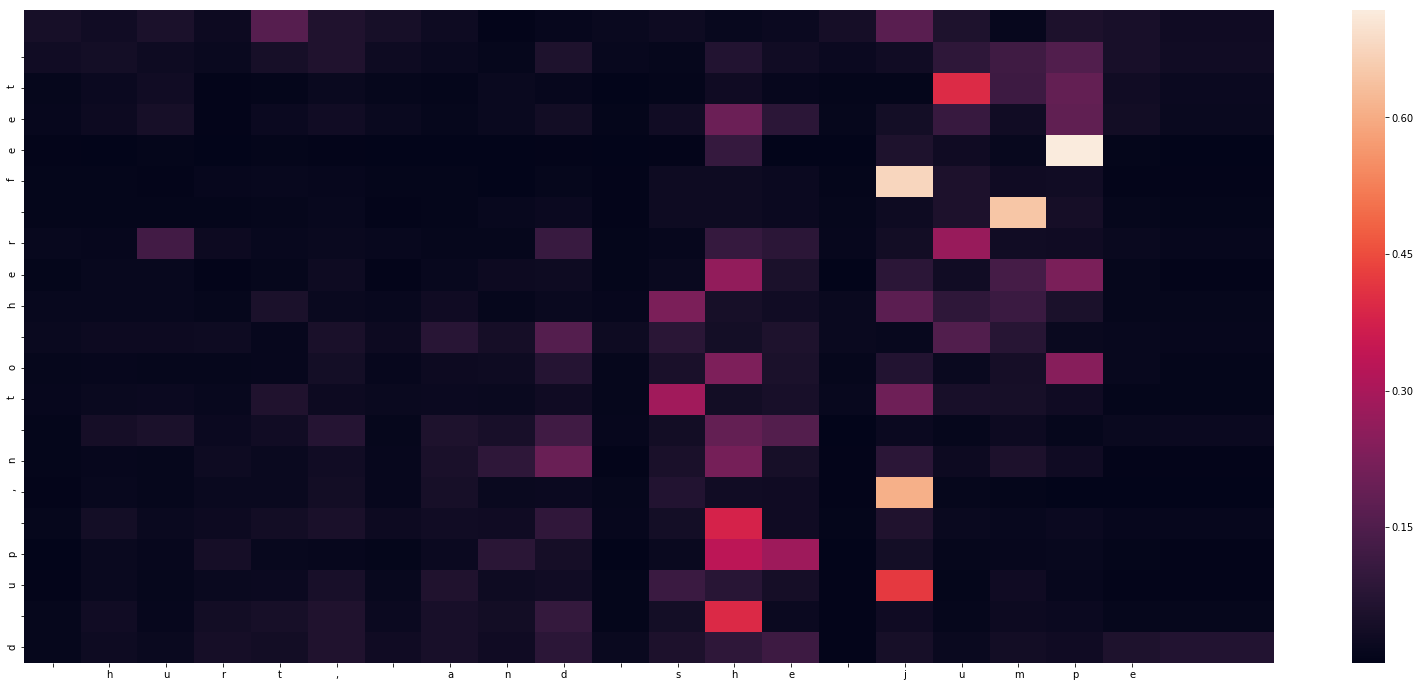

-
Input sentence:  hurt, and she jumpe
GT sentence: d up on to her feet 
Decoded sentence: d up ,n to her feet 


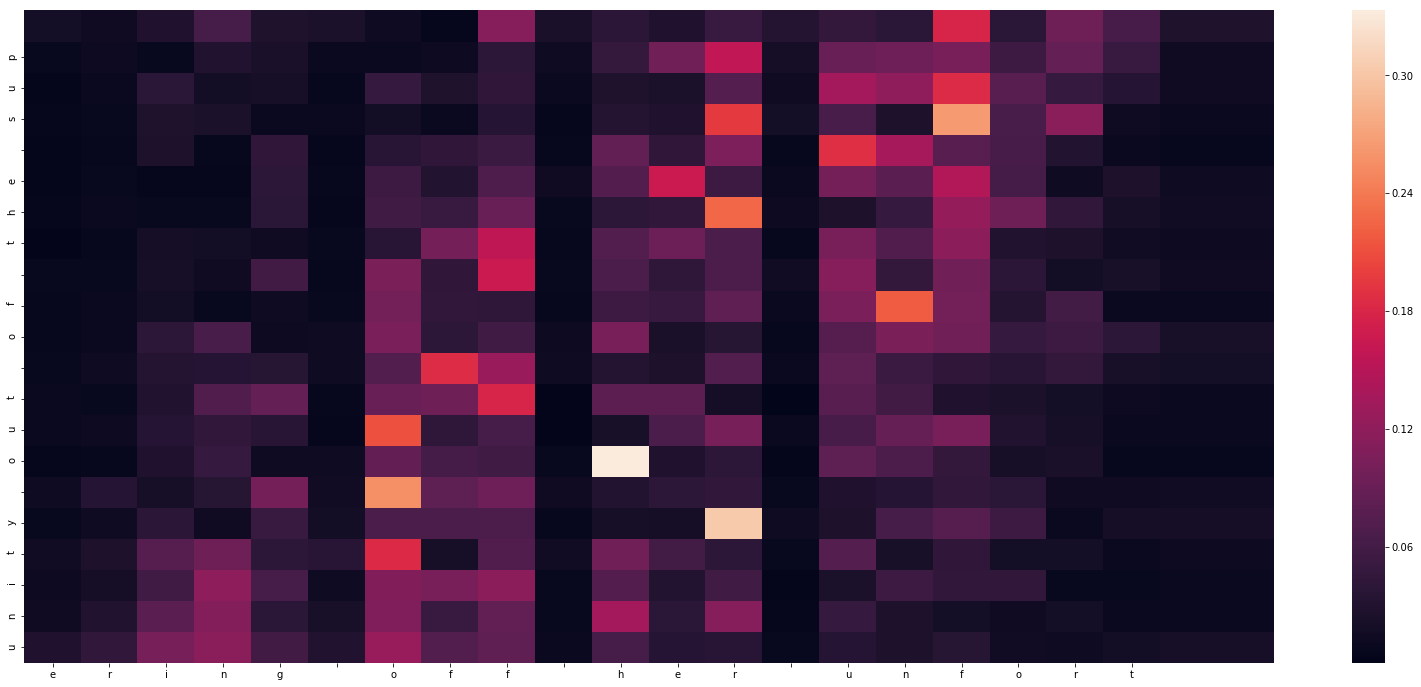

-
Input sentence: ering off her unfort
GT sentence: unate guests to exec
Decoded sentence: unity out of the sup


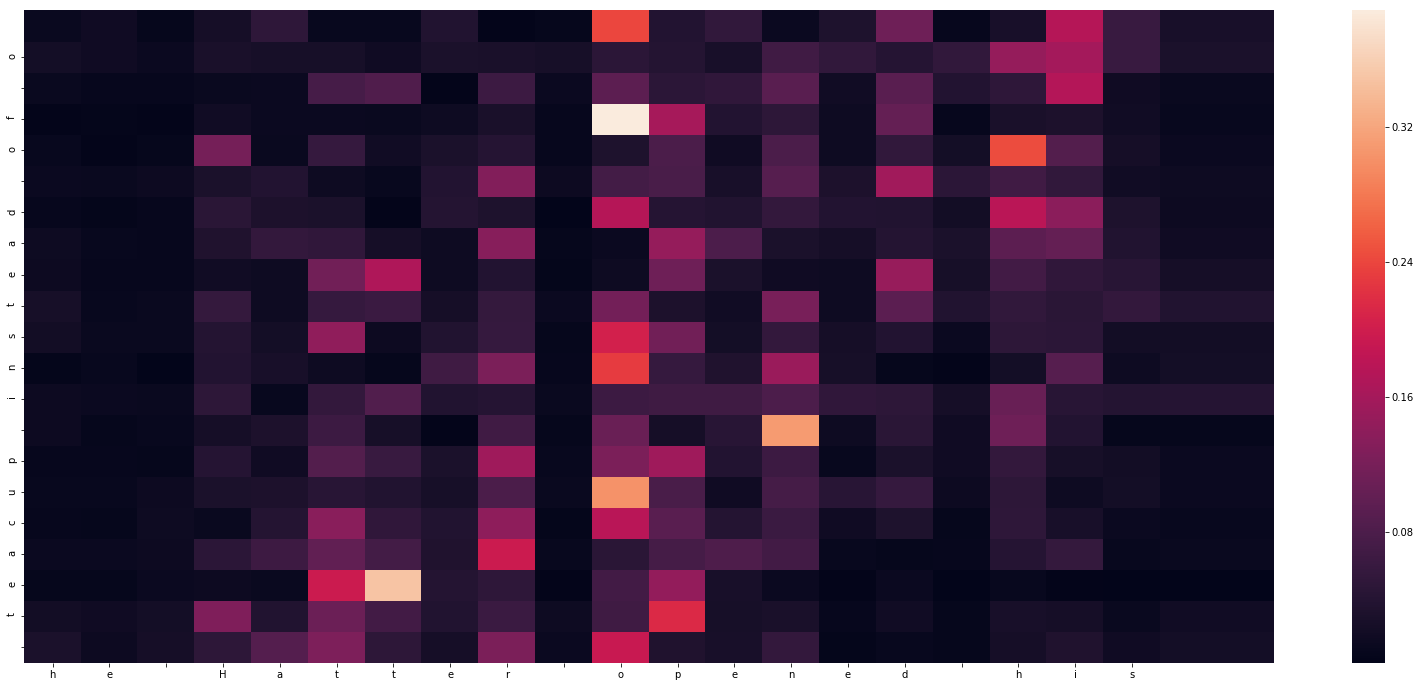

-
Input sentence: he Hatter opened his
GT sentence:  eyes very wide on h
Decoded sentence:  teacup instead of o


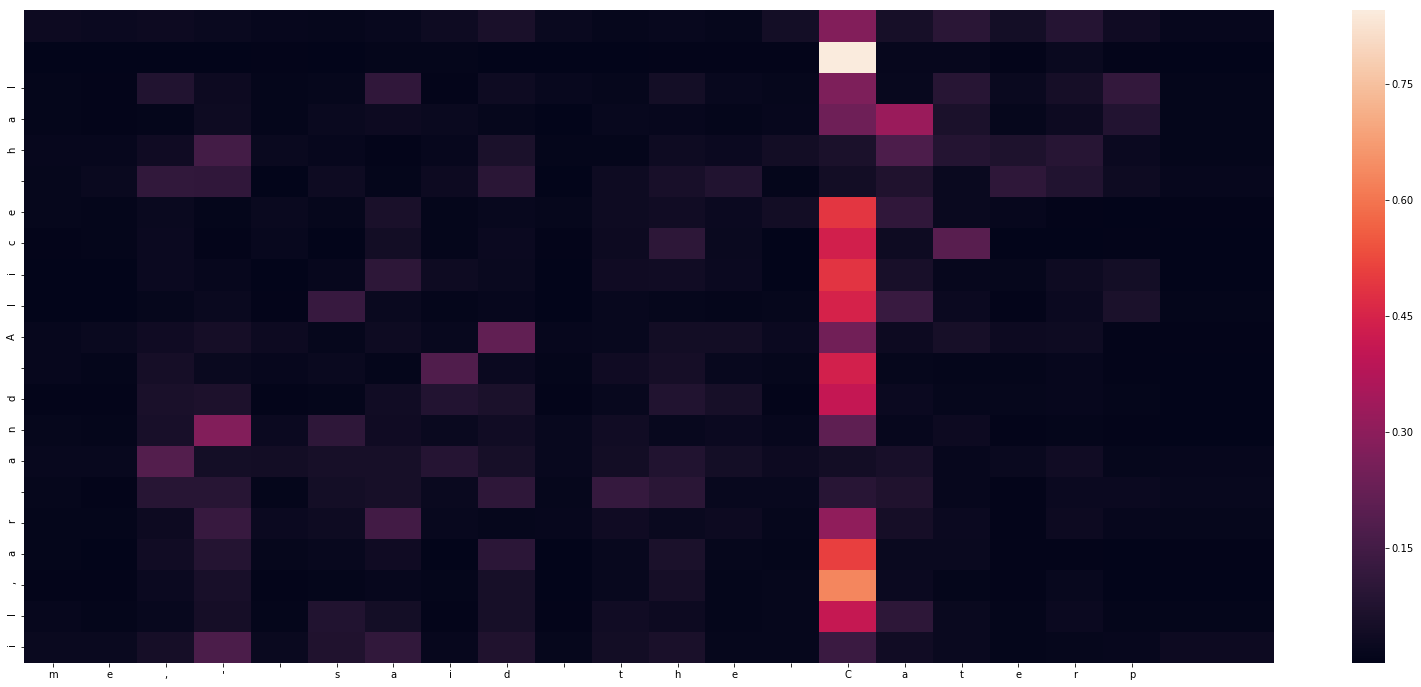

-
Input sentence: me,' said the Caterp
GT sentence: illar; and it put th
Decoded sentence: il,ar and Alice hal


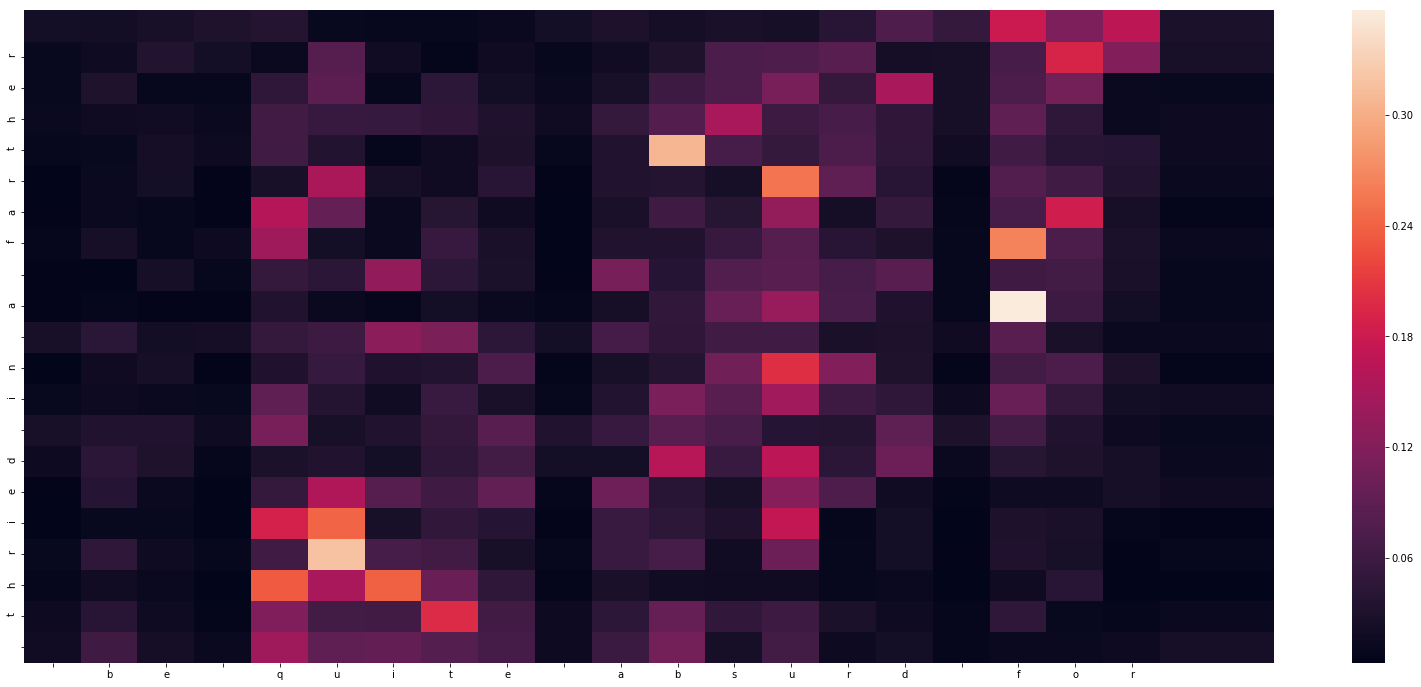

-
Input sentence:  be quite absurd for
GT sentence:  her to carry it fur
Decoded sentence:  thried in a farther


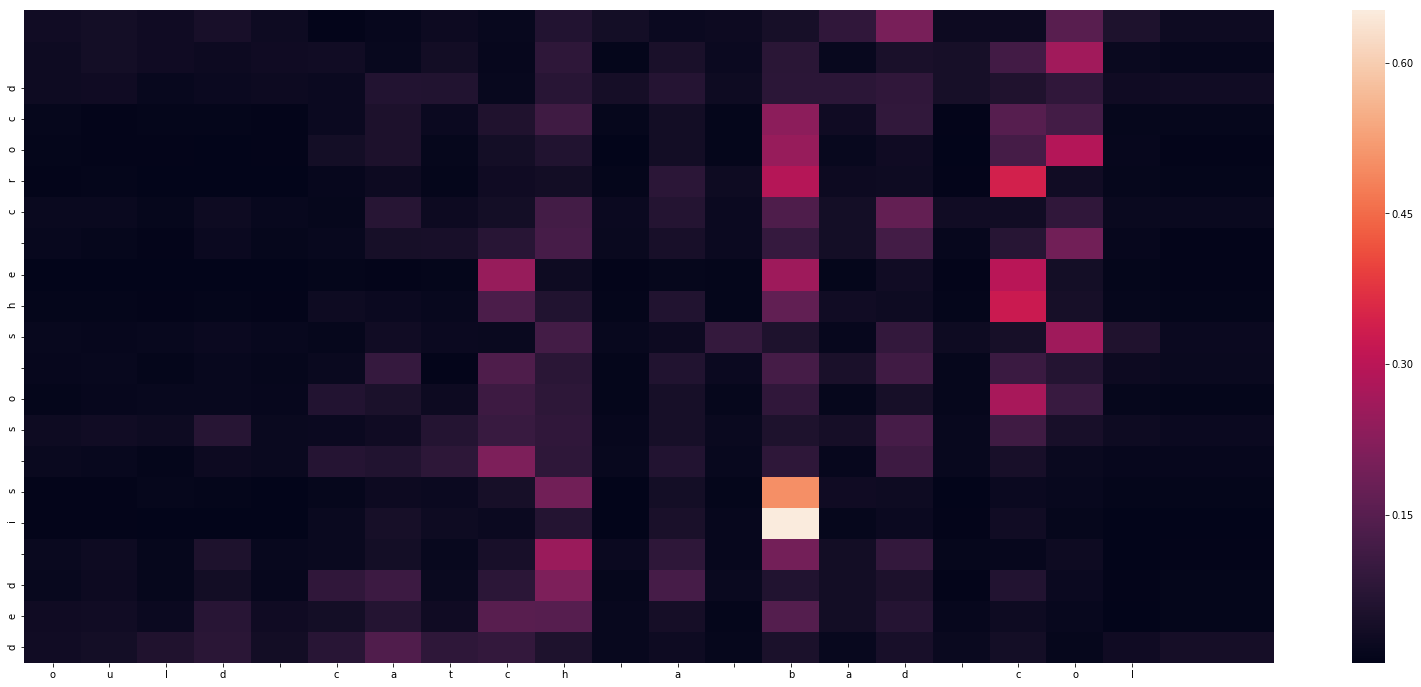

-
Input sentence: ould catch a bad col
GT sentence: d if she did not get
Decoded sentence: ded is so she crocd


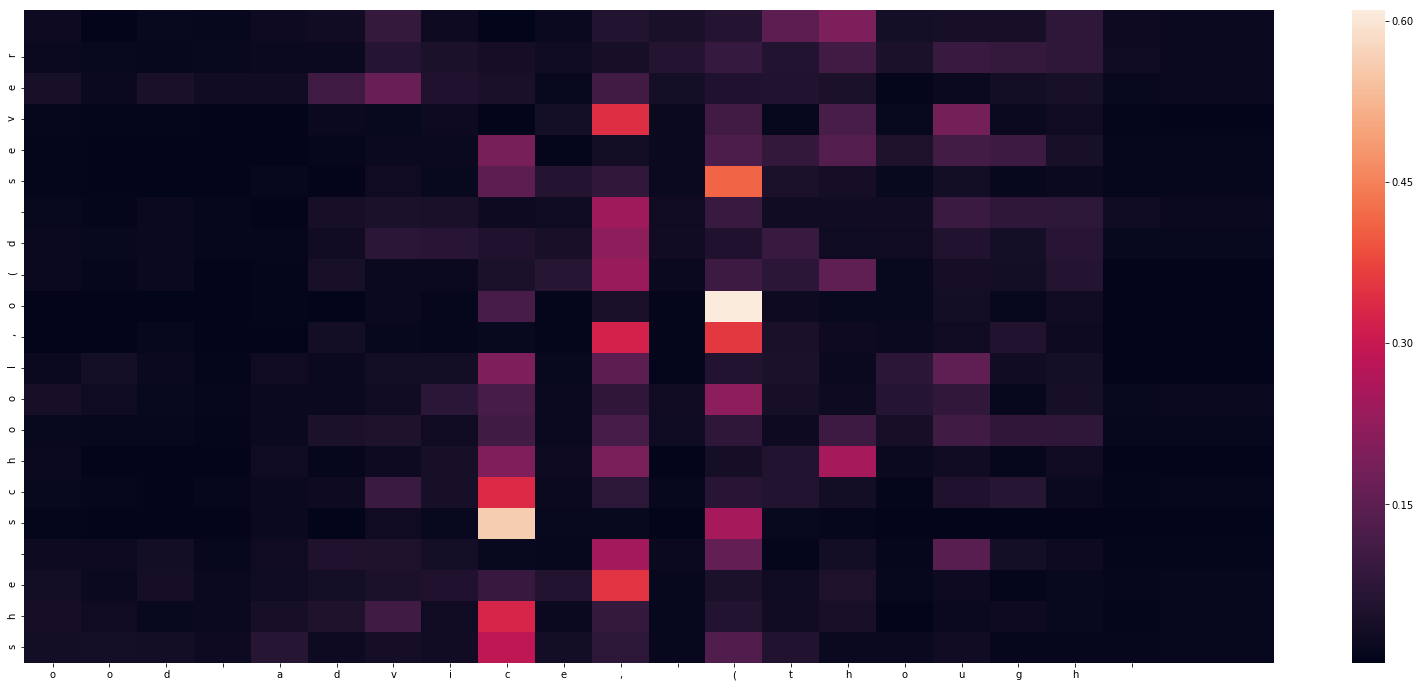

-
Input sentence: ood advice, (though 
GT sentence: she very seldom foll
Decoded sentence: she school,o(d sever


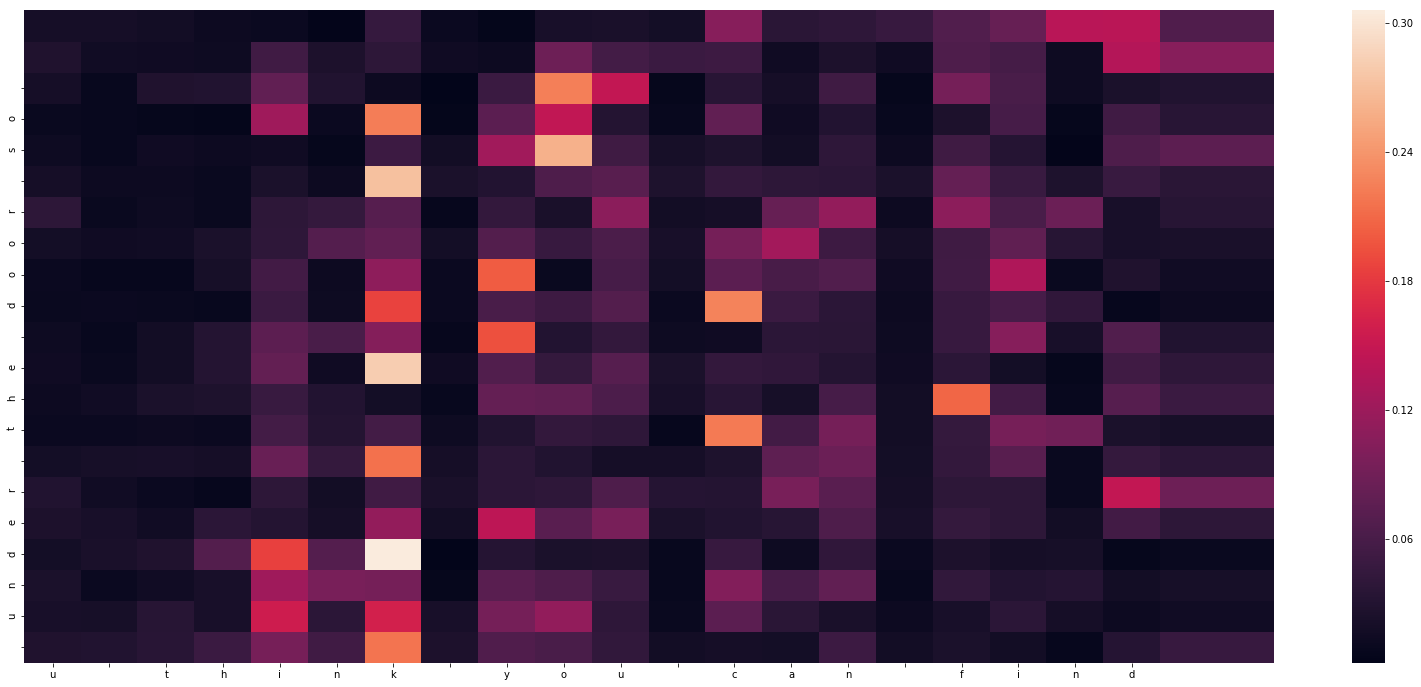

-
Input sentence: u think you can find
GT sentence:  out the answer to i
Decoded sentence:  under the door so 


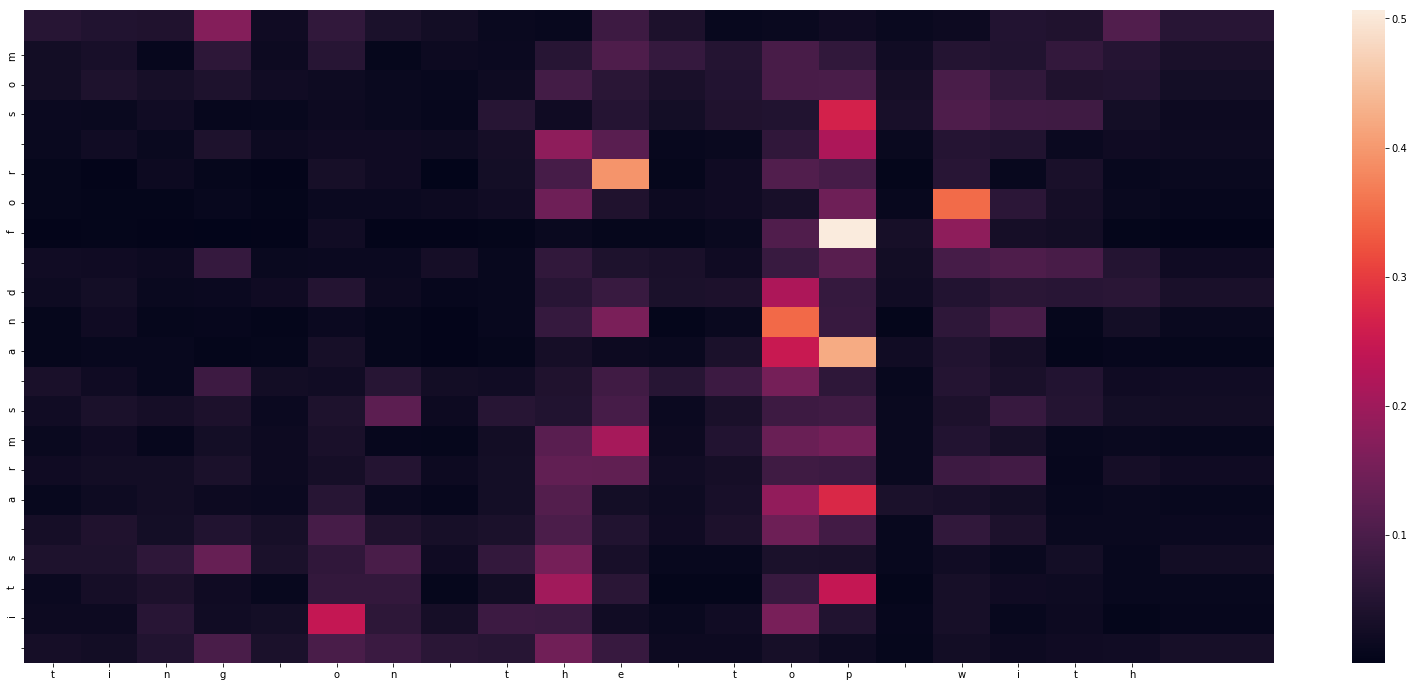

-
Input sentence: ting on the top with
GT sentence:  its arms folded, qu
Decoded sentence:  its arms and for som


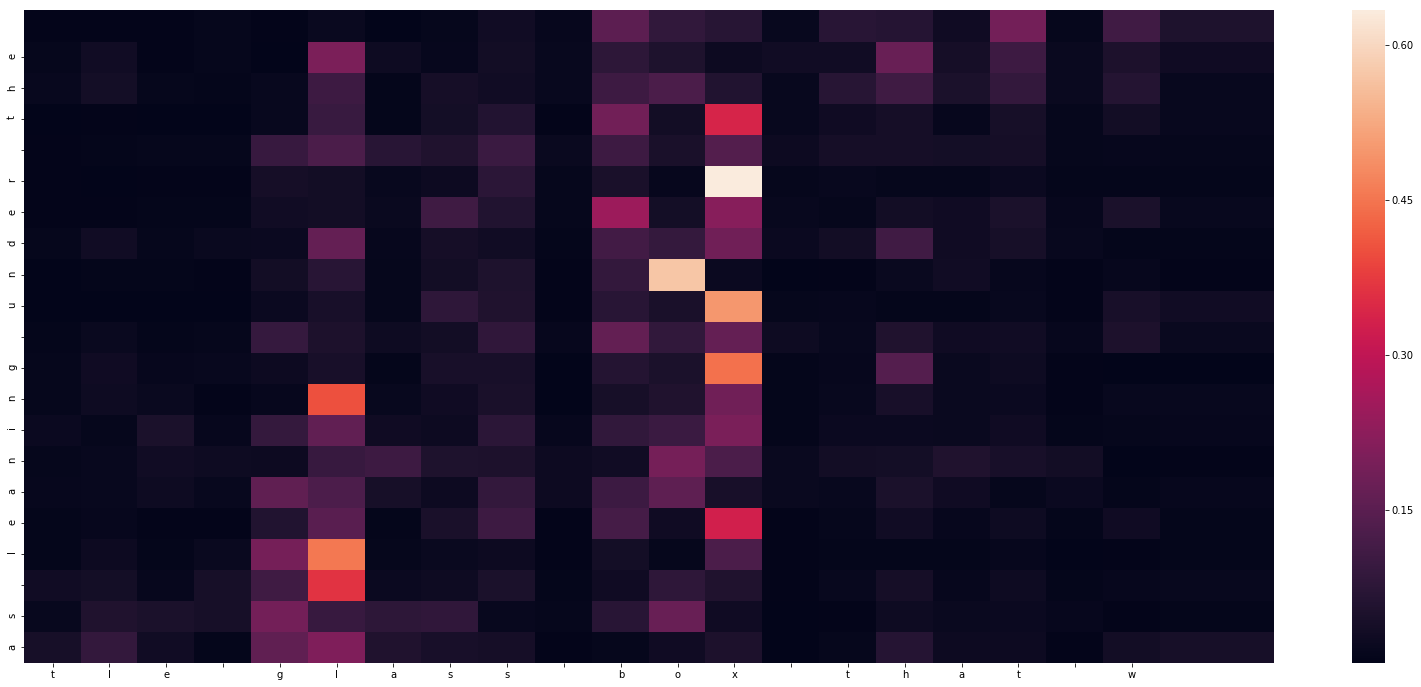

-
Input sentence: tle glass box that w
GT sentence: as lying under the t
Decoded sentence: as leaning under the


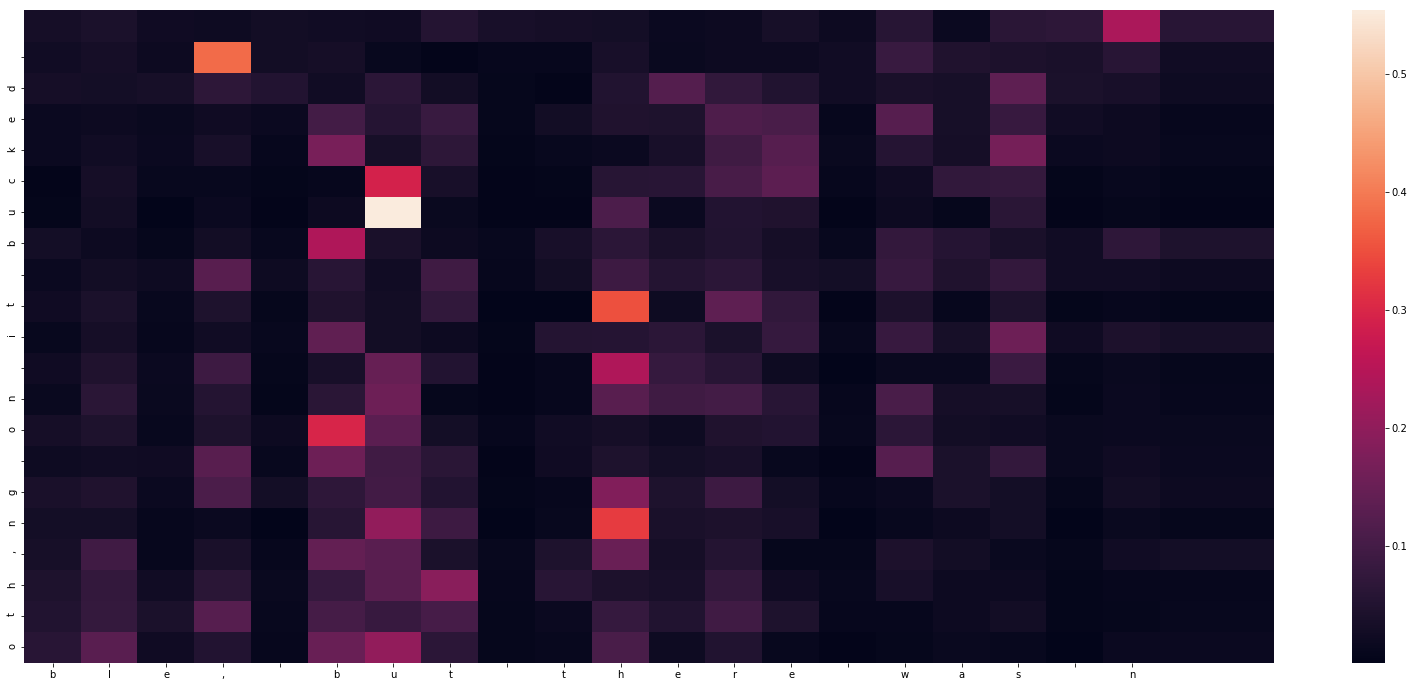

-
Input sentence: ble, but there was n
GT sentence: othing on it but tea
Decoded sentence: oth,ng on it bucked 


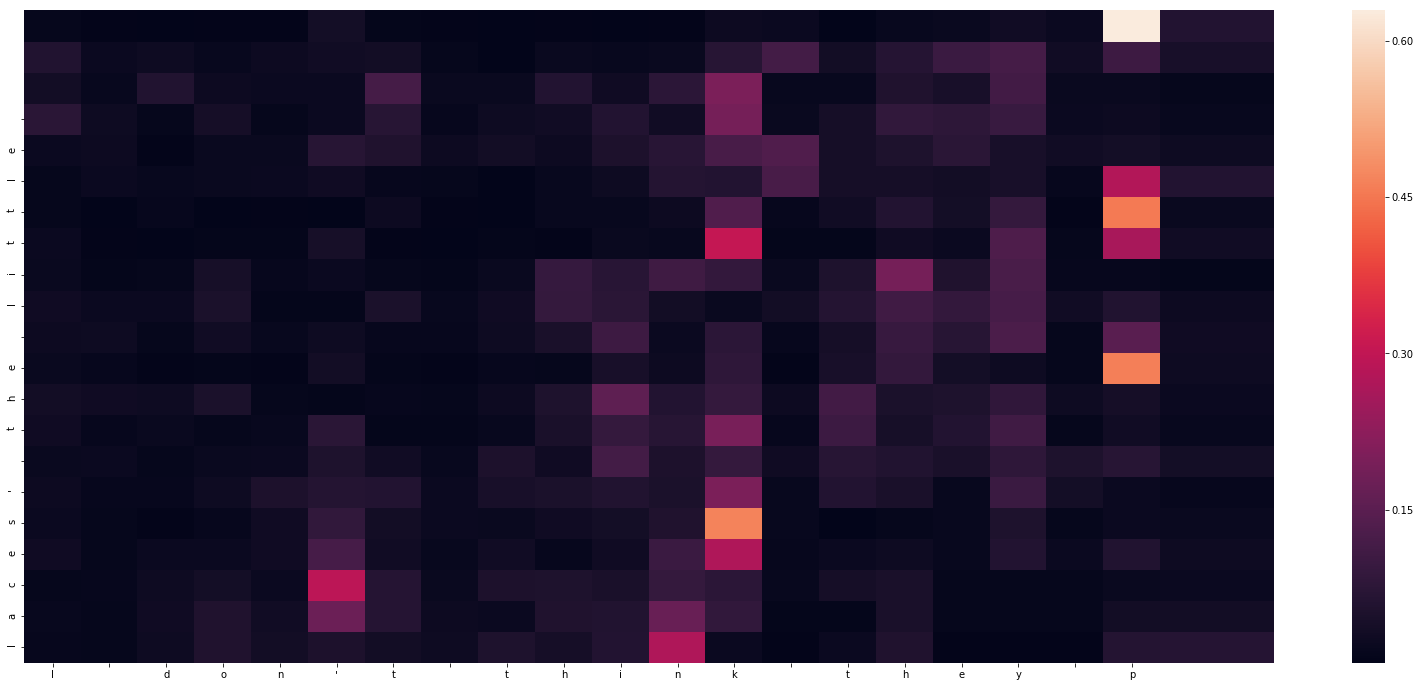

-
Input sentence: I don't think they p
GT sentence: lay at all fairly,' 
Decoded sentence: laces' the little 


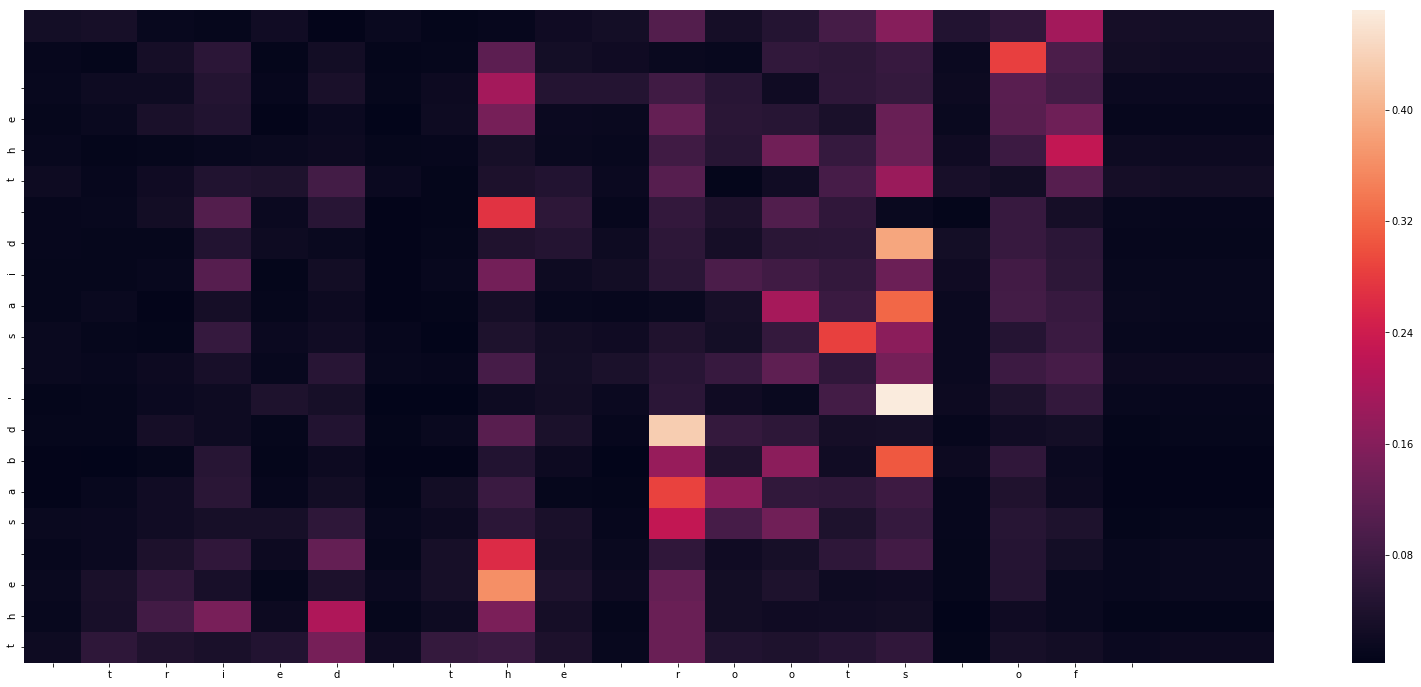

-
Input sentence:  tried the roots of 
GT sentence: trees, and I've trie
Decoded sentence: the sabd' said the 


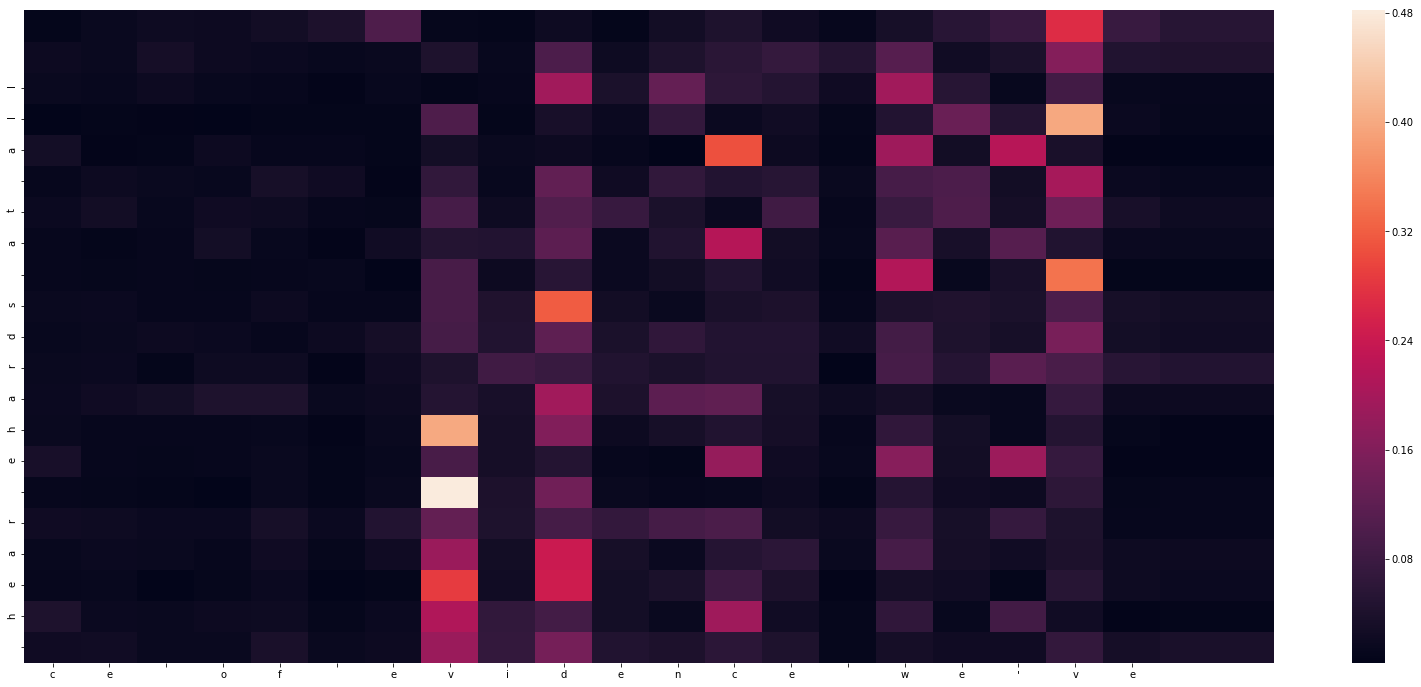

-
Input sentence: ce of evidence we've
GT sentence:  heard yet,' said th
Decoded sentence:  hear ehards at all


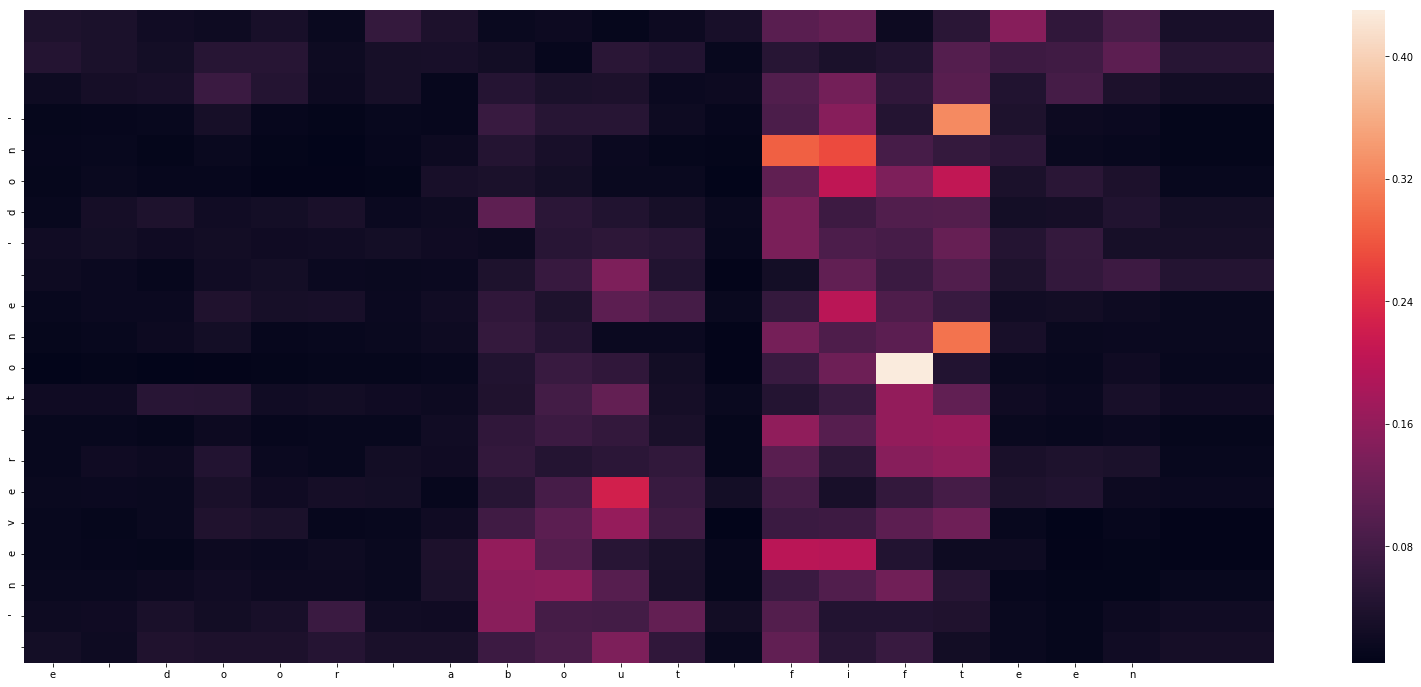

-
Input sentence: e door about fifteen
GT sentence:  inches high: she tr
Decoded sentence:  'never tone 'don'


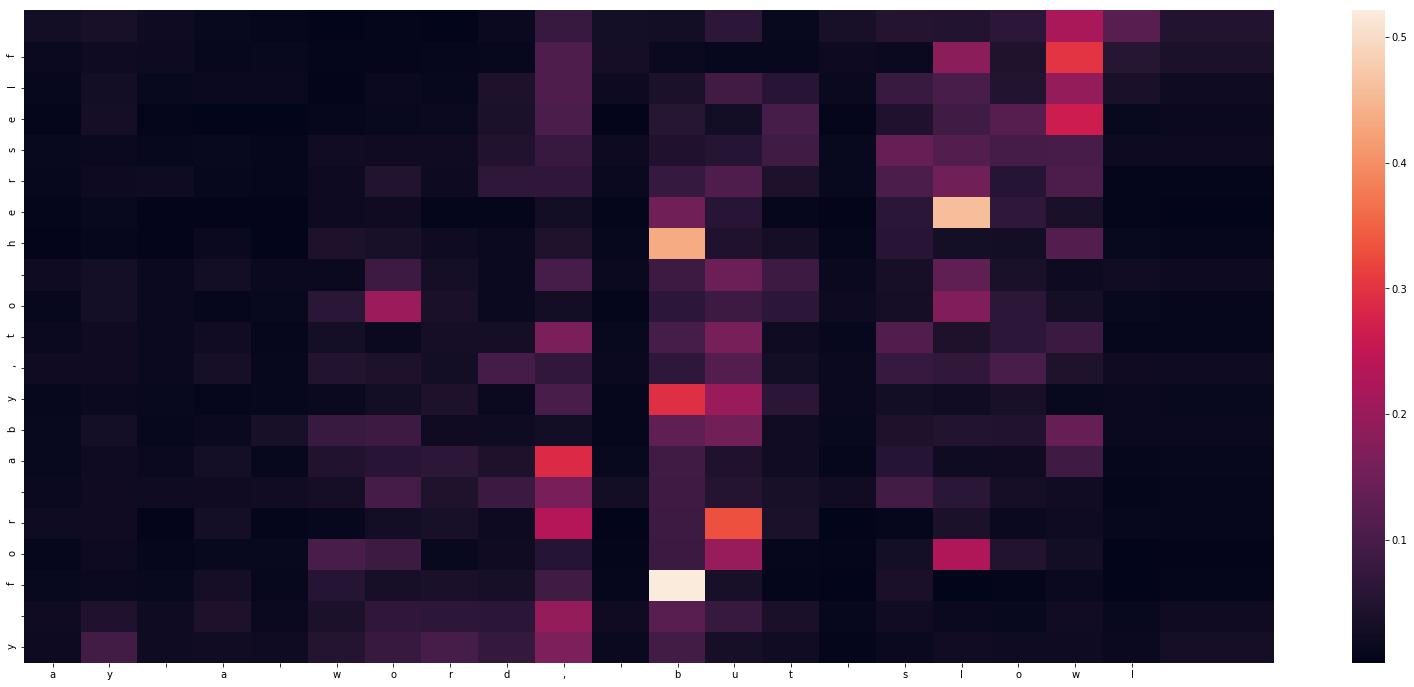

-
Input sentence: ay a word, but slowl
GT sentence: y followed her back 
Decoded sentence: y for aby,to herself


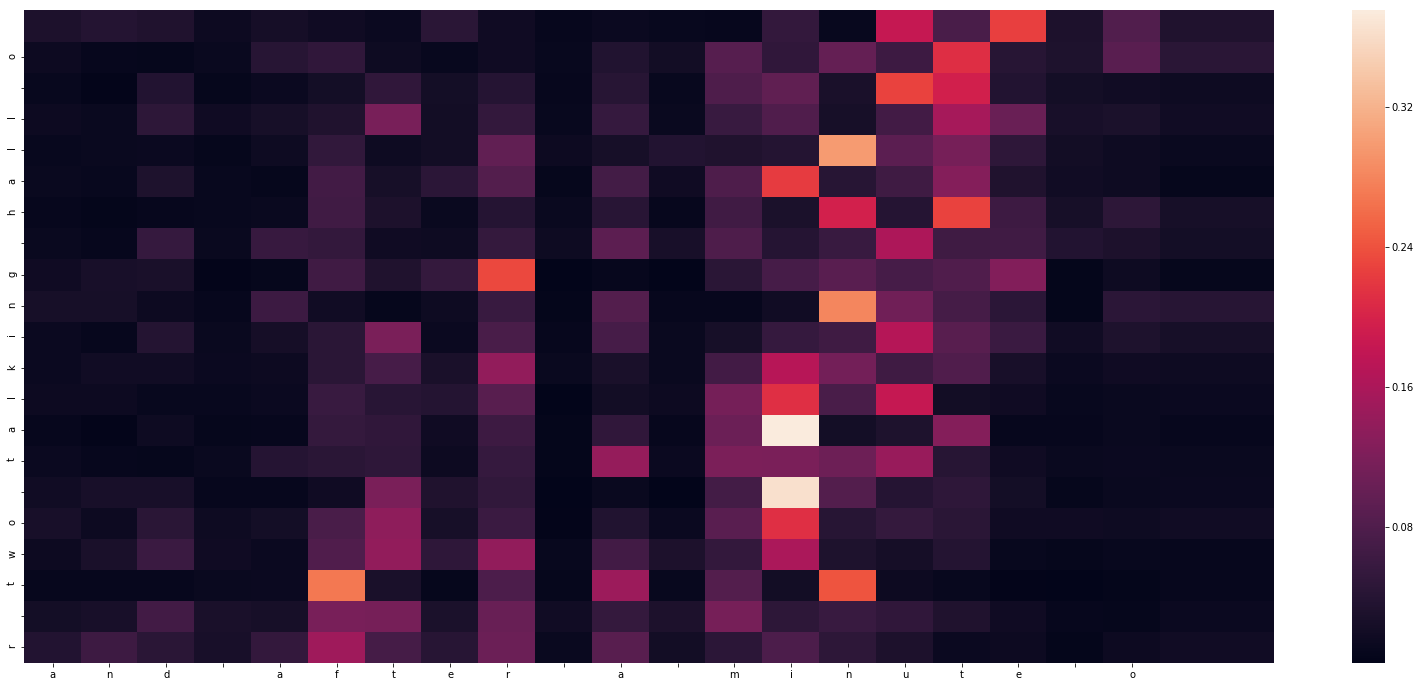

-
Input sentence: and after a minute o
GT sentence: r two she walked on 
Decoded sentence: r two talking hall o


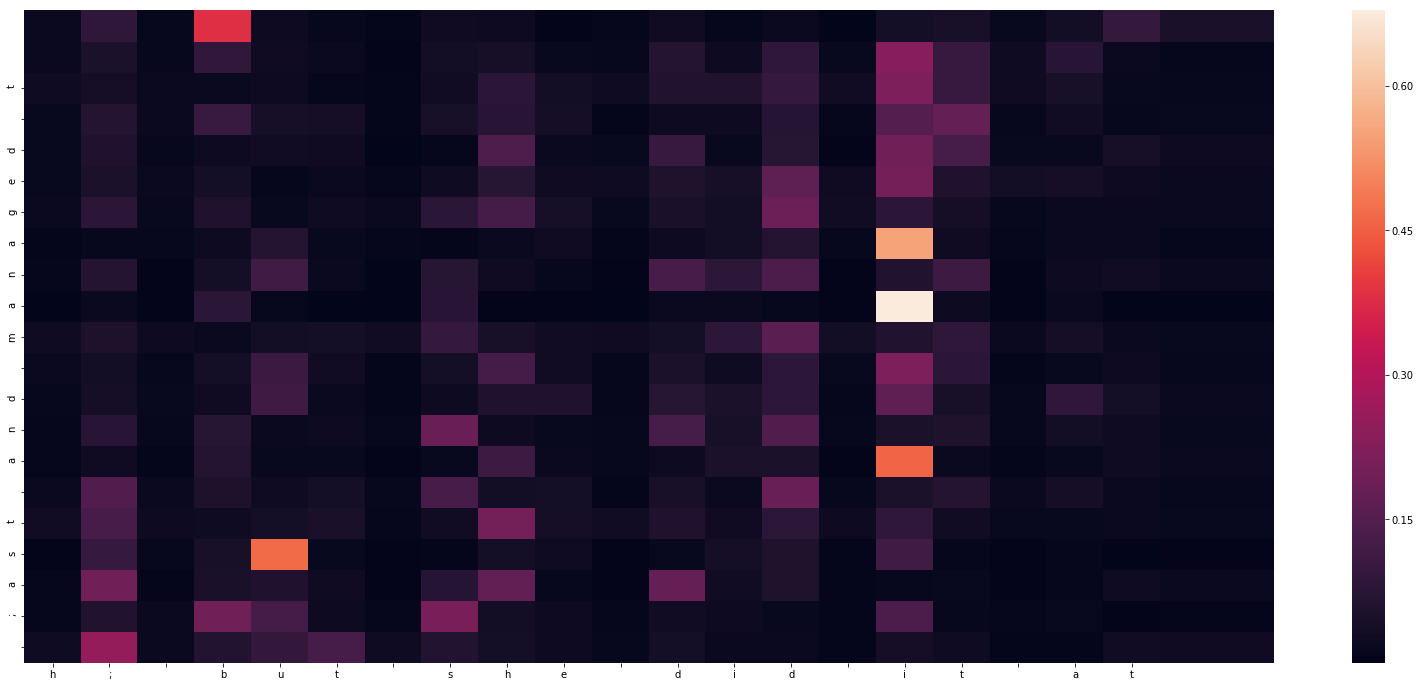

-
Input sentence: h; but she did it at
GT sentence:  last, and managed t
Decoded sentence:  ;ast and managed t


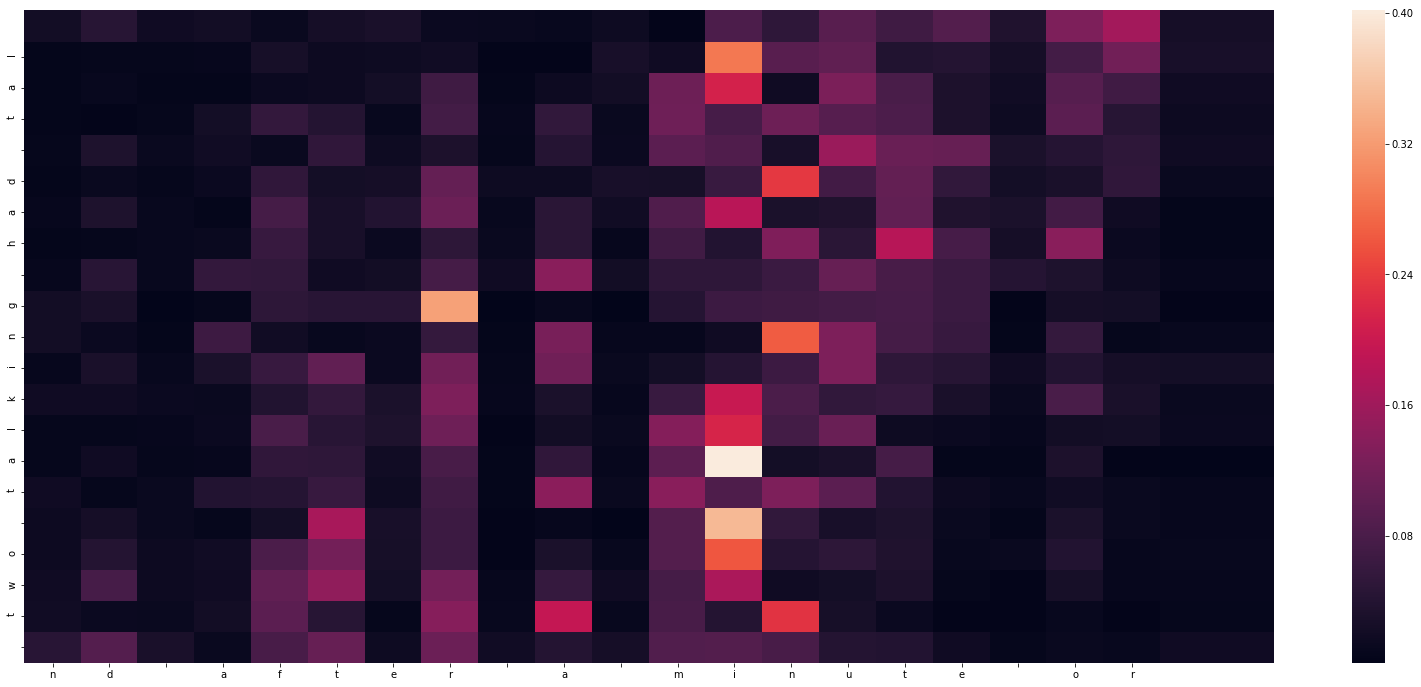

-
Input sentence: nd after a minute or
GT sentence:  two she walked on i
Decoded sentence:  two talking had tal


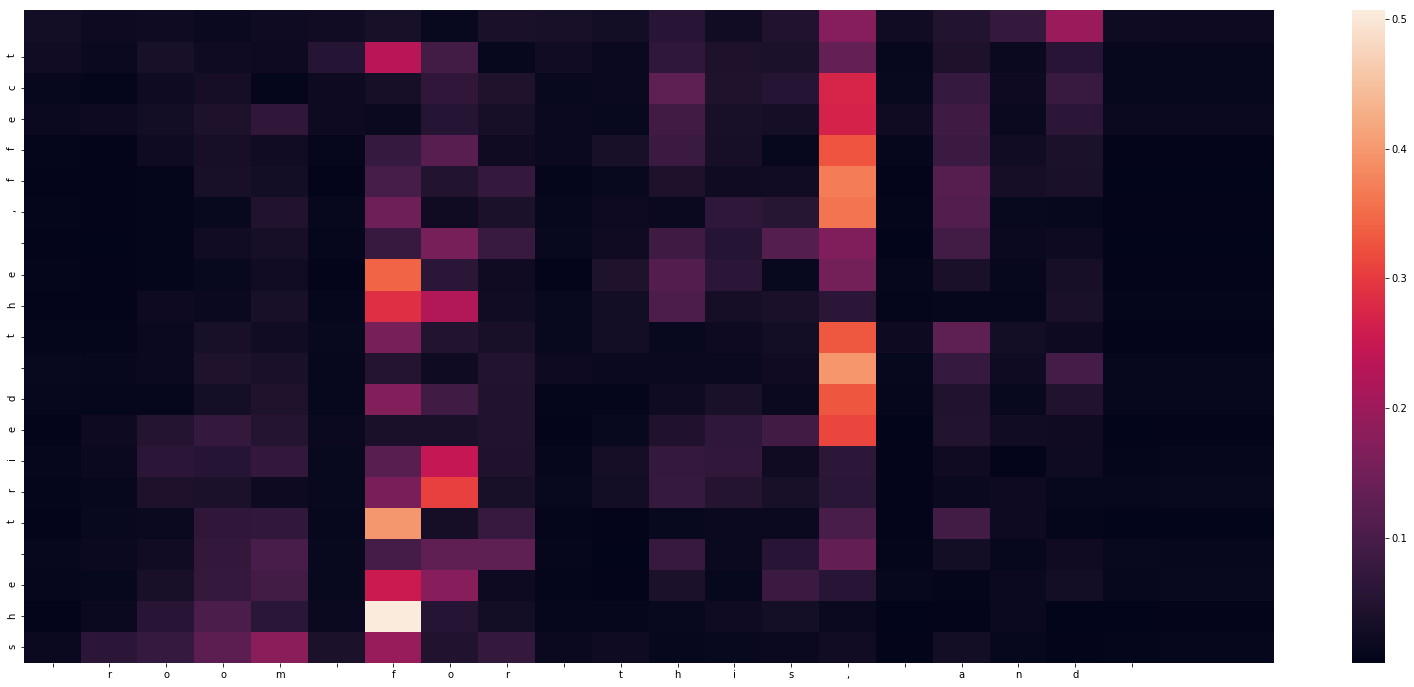

-
Input sentence:  room for this, and 
GT sentence: she tried the effect
Decoded sentence: she tried the ,ffect


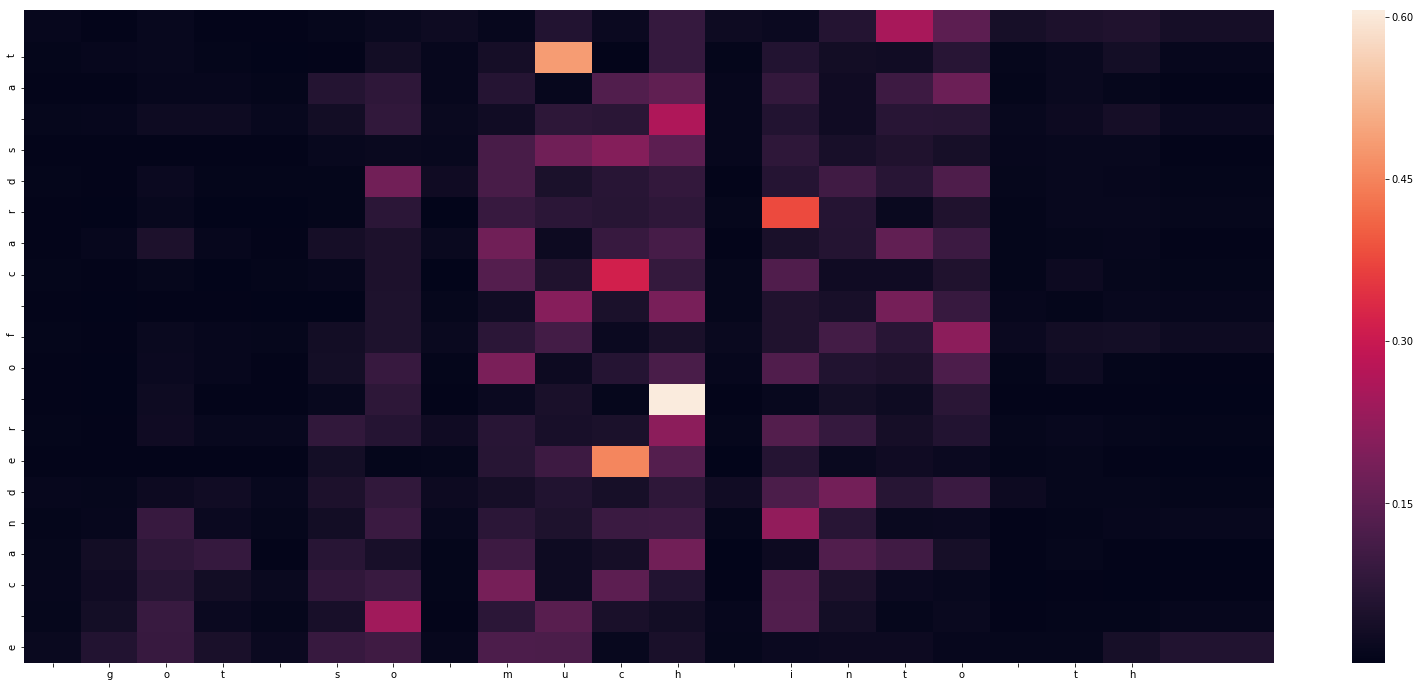

-
Input sentence:  got so much into th
GT sentence: e way of expecting n
Decoded sentence: e cander of cards at


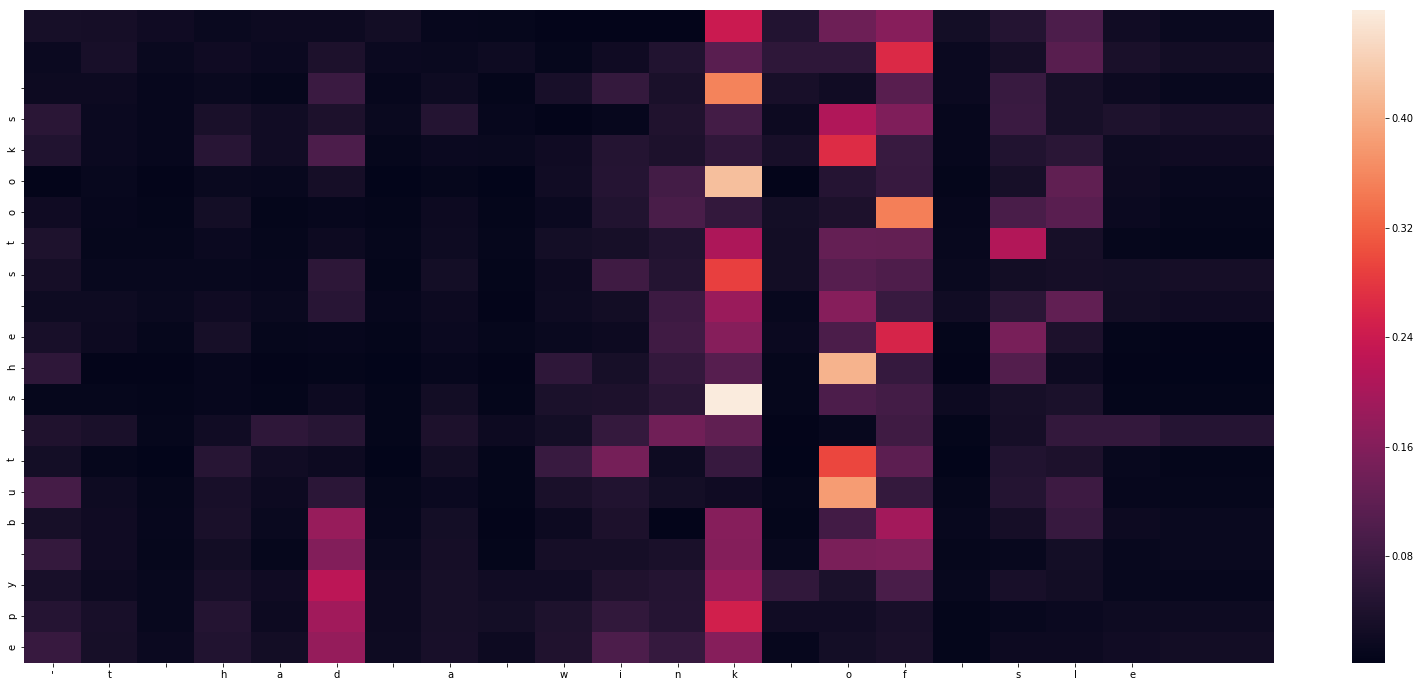

-
Input sentence: 't had a wink of sle
GT sentence: ep these three weeks
Decoded sentence: epy but she stooks 


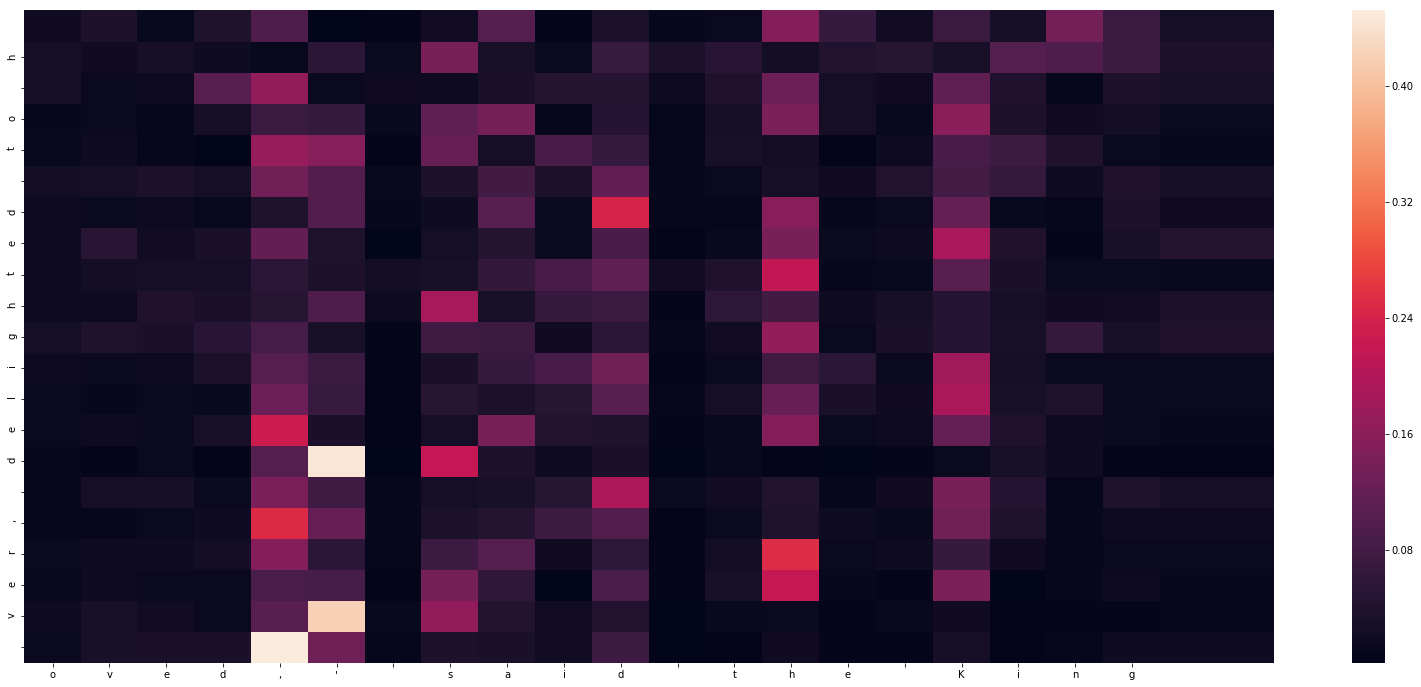

-
Input sentence: oved,' said the King
GT sentence:  very decidedly, and
Decoded sentence:  ver, delighted to h


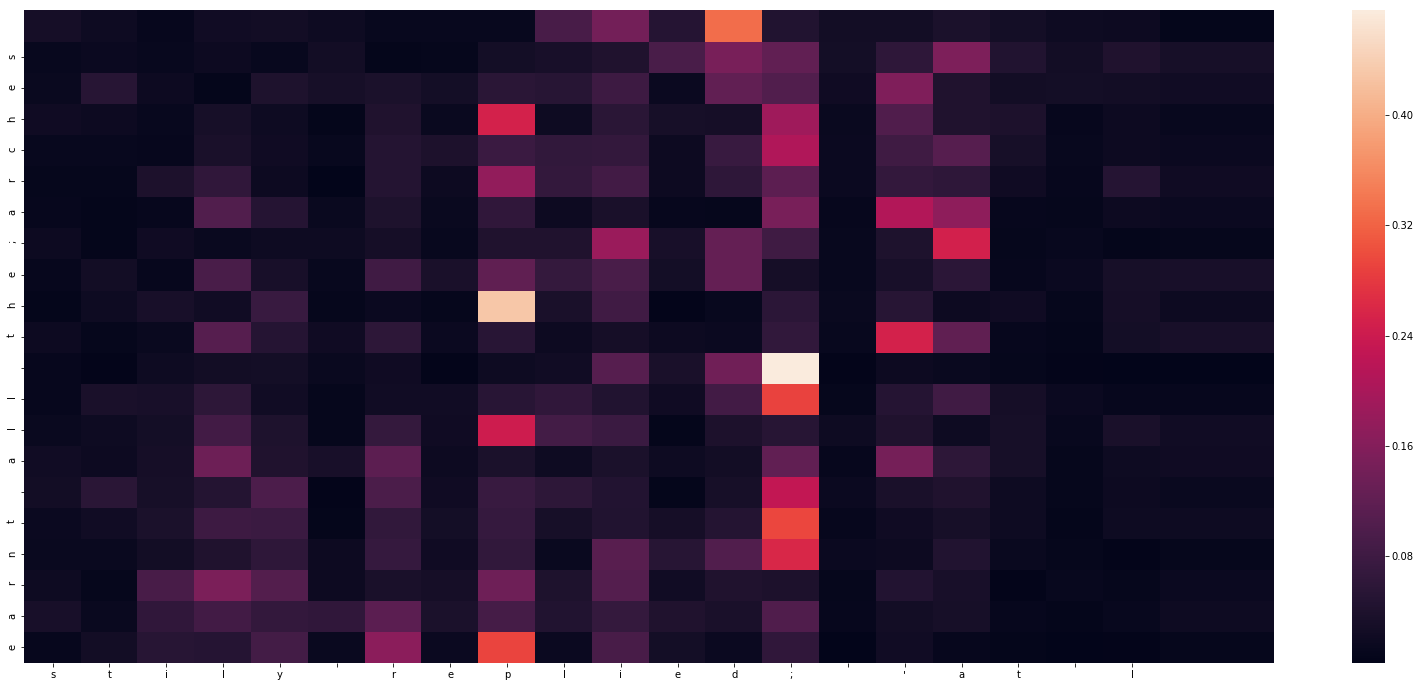

-
Input sentence: stily replied; 'at l
GT sentence: east--at least I mea
Decoded sentence: earnt all the;arches


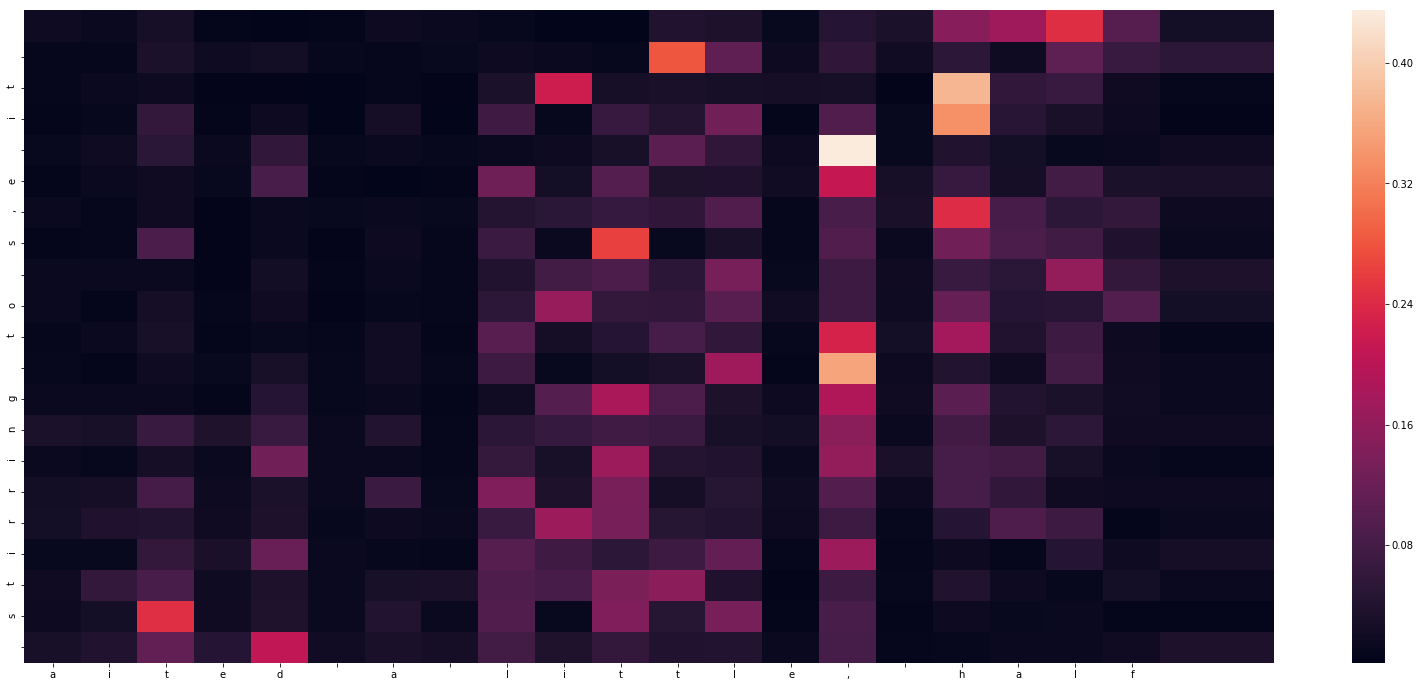

-
Input sentence: aited a little, half
GT sentence:  expecting to see it
Decoded sentence:  stirring to s,e it 


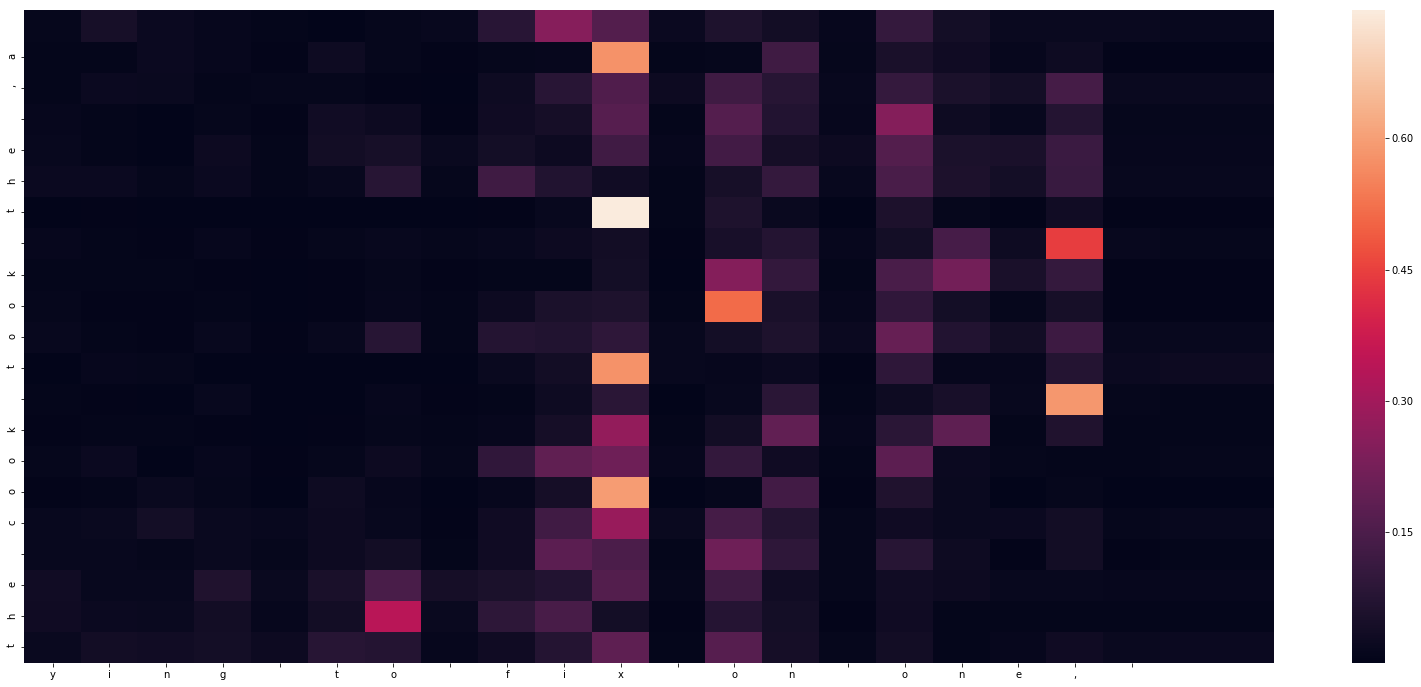

-
Input sentence: ying to fix on one, 
GT sentence: the cook took the ca
Decoded sentence: the cook took the ,a


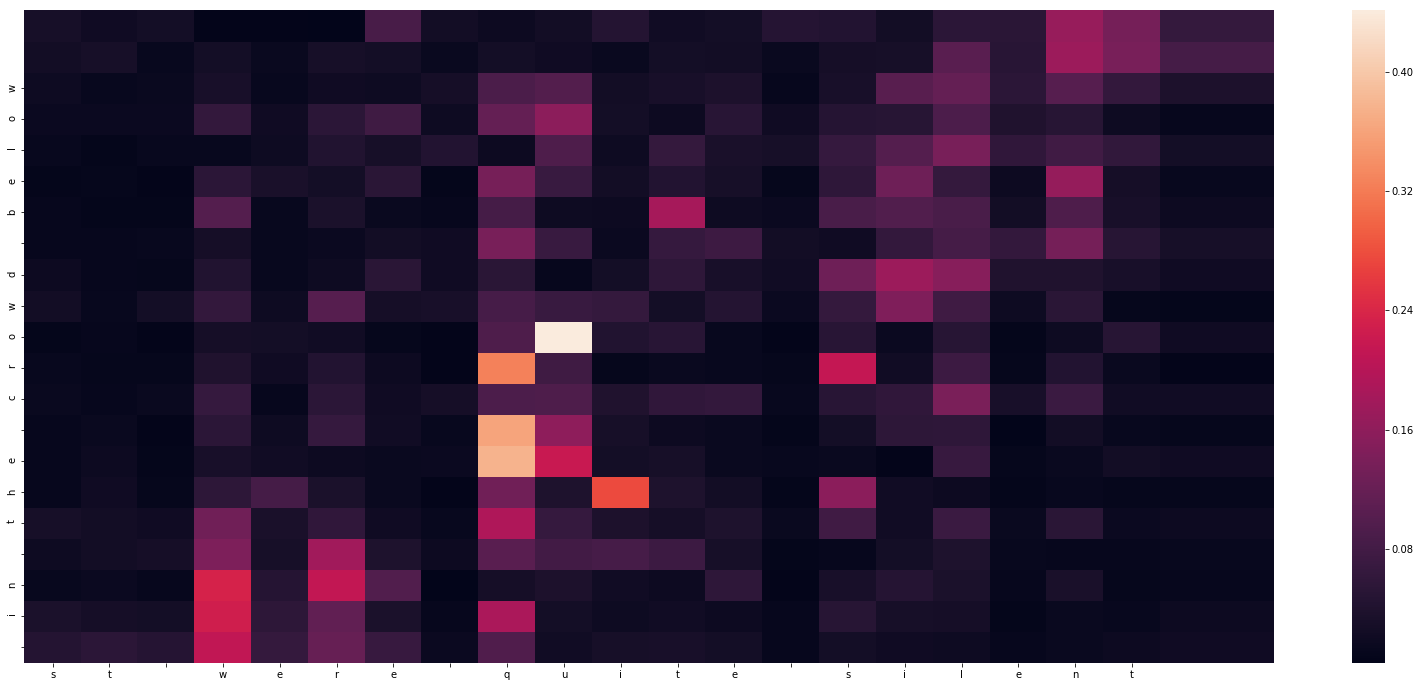

-
Input sentence: st were quite silent
GT sentence: , and looked very un
Decoded sentence:  in the crowd below


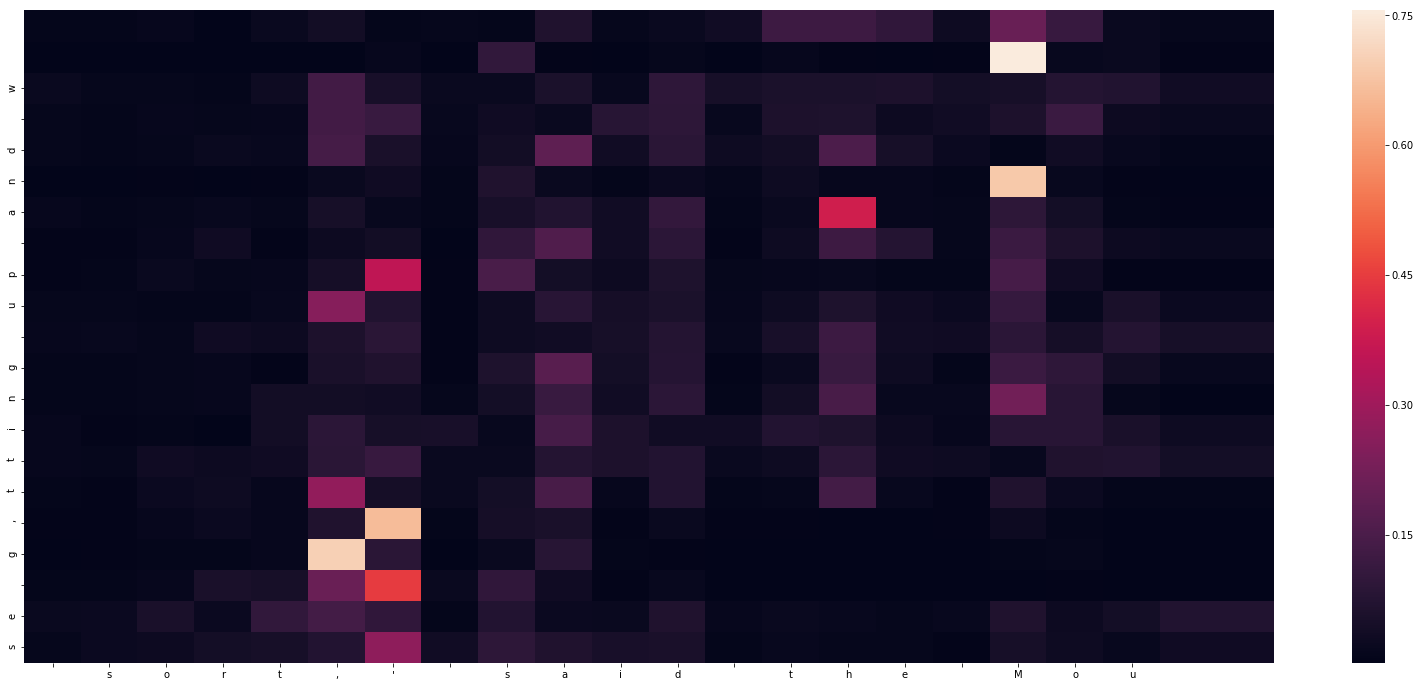

-
Input sentence:  sort,' said the Mou
GT sentence: se, getting up and w
Decoded sentence: se g,tting up and w


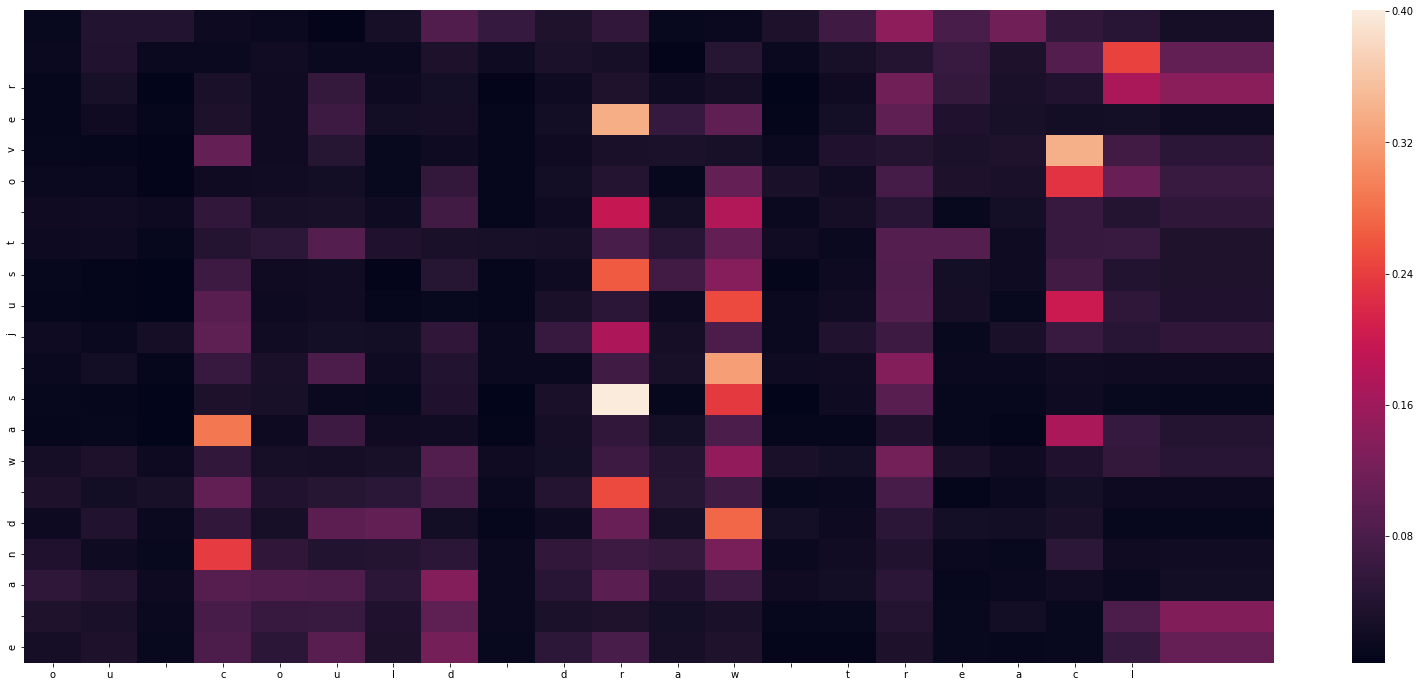

-
Input sentence: ou could draw treacl
GT sentence: e out of a treacle-w
Decoded sentence: e and was just over


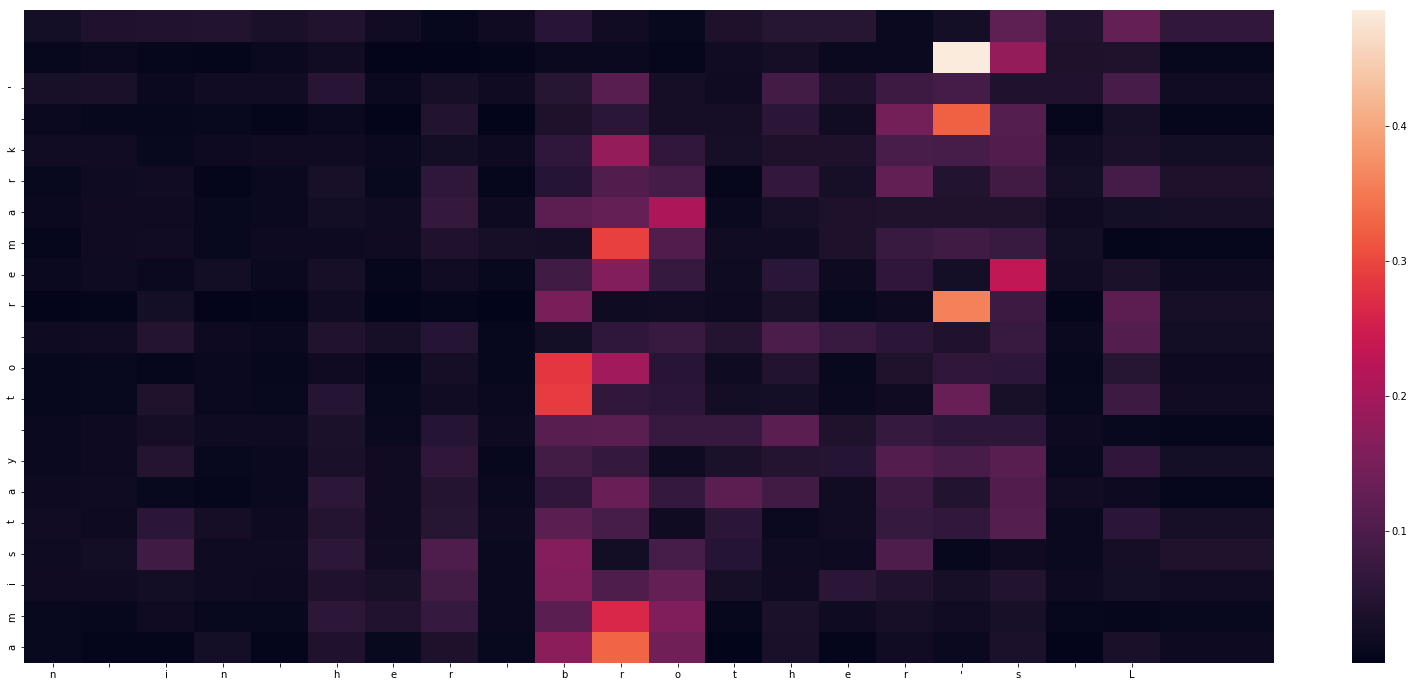

-
Input sentence: n in her brother's L
GT sentence: atin Grammar, 'A mou
Decoded sentence: amistay to remark '


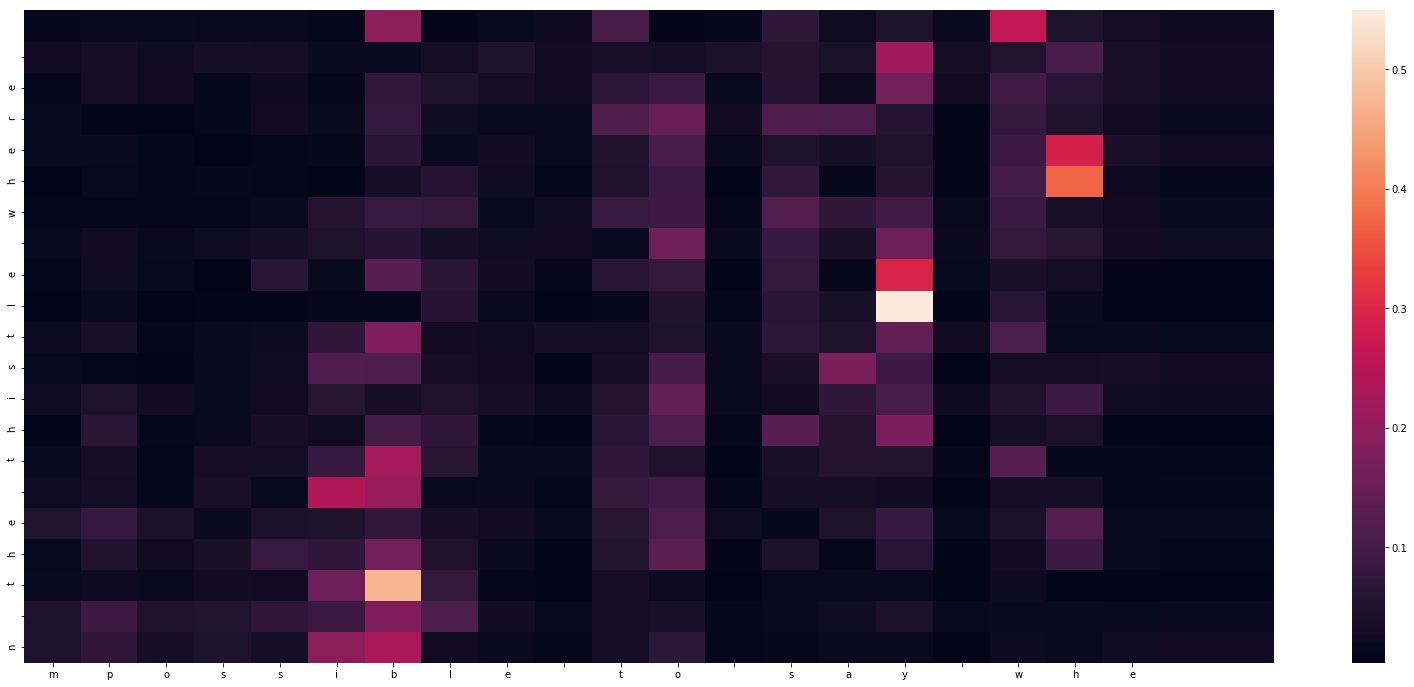

-
Input sentence: mpossible to say whe
GT sentence: ther the blows hurt 
Decoded sentence: n the thistle where 


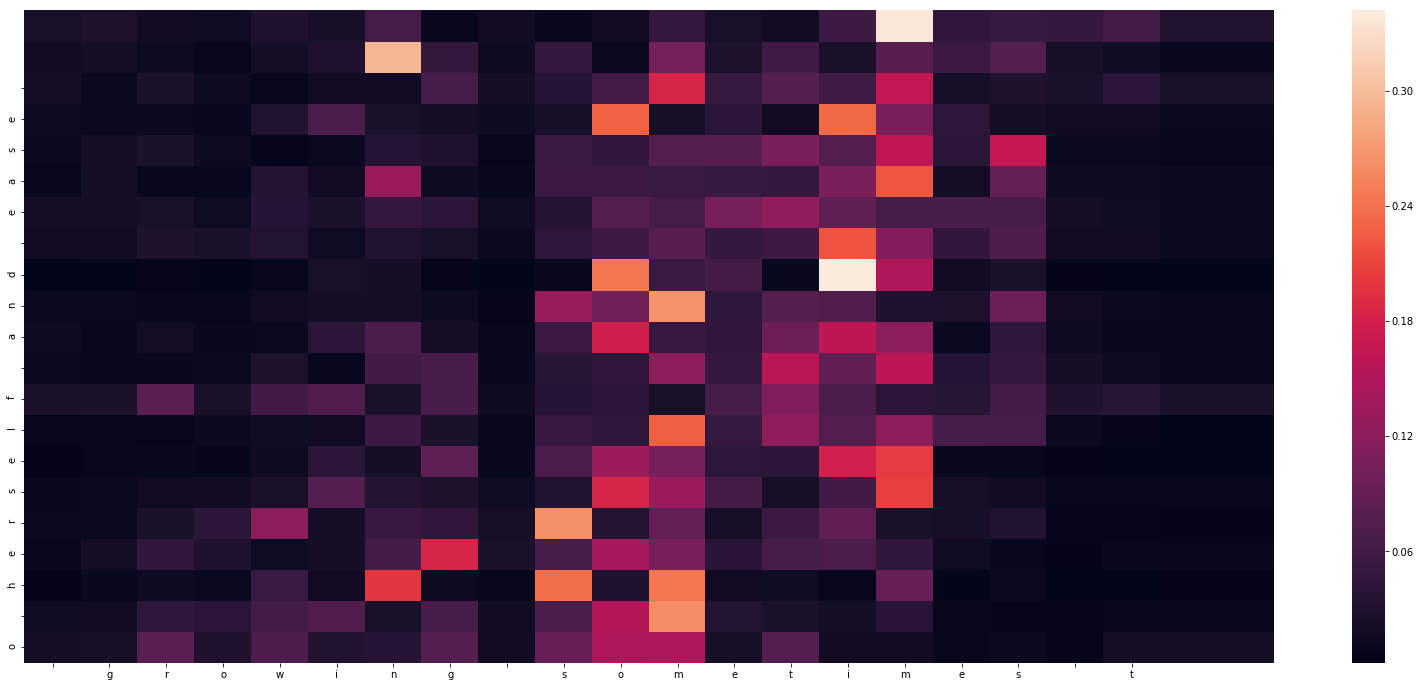

-
Input sentence:  growing sometimes t
GT sentence: aller and sometimes 
Decoded sentence: o herself and ease 


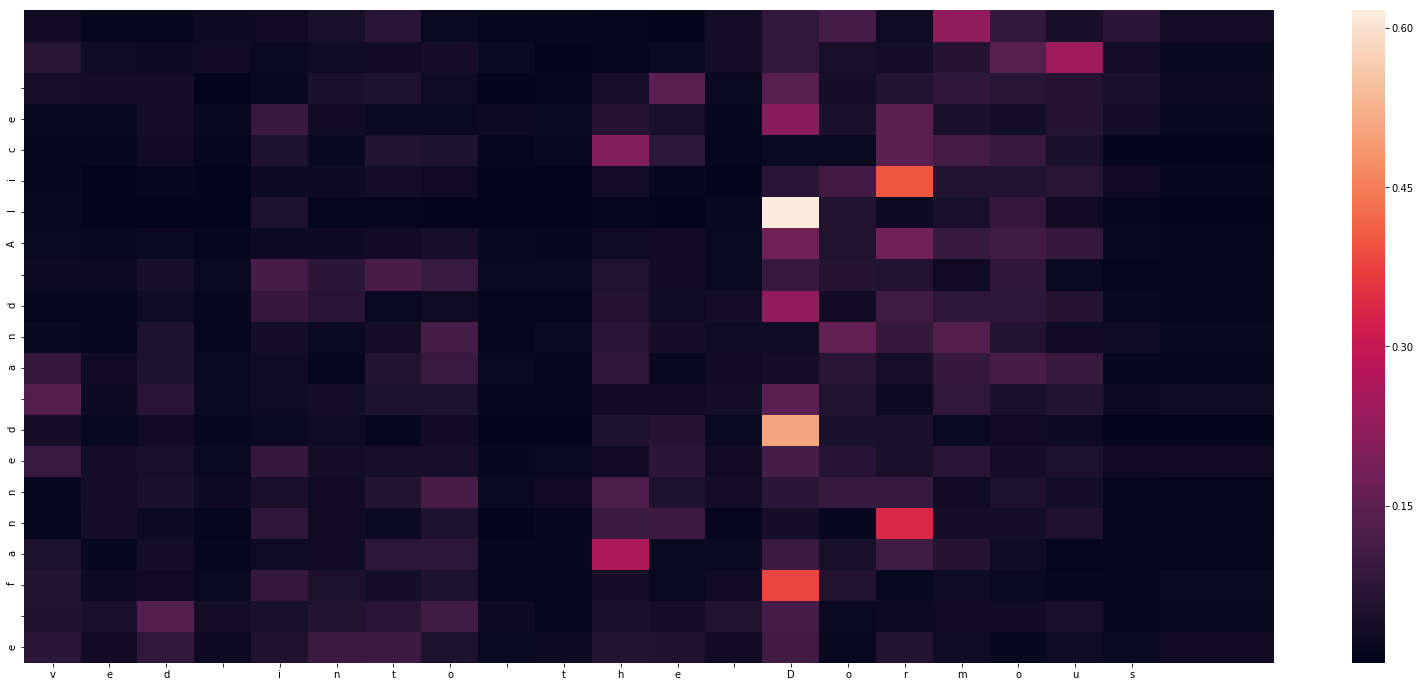

-
Input sentence: ved into the Dormous
GT sentence: e's place, and Alice
Decoded sentence: e fanned and Alice 


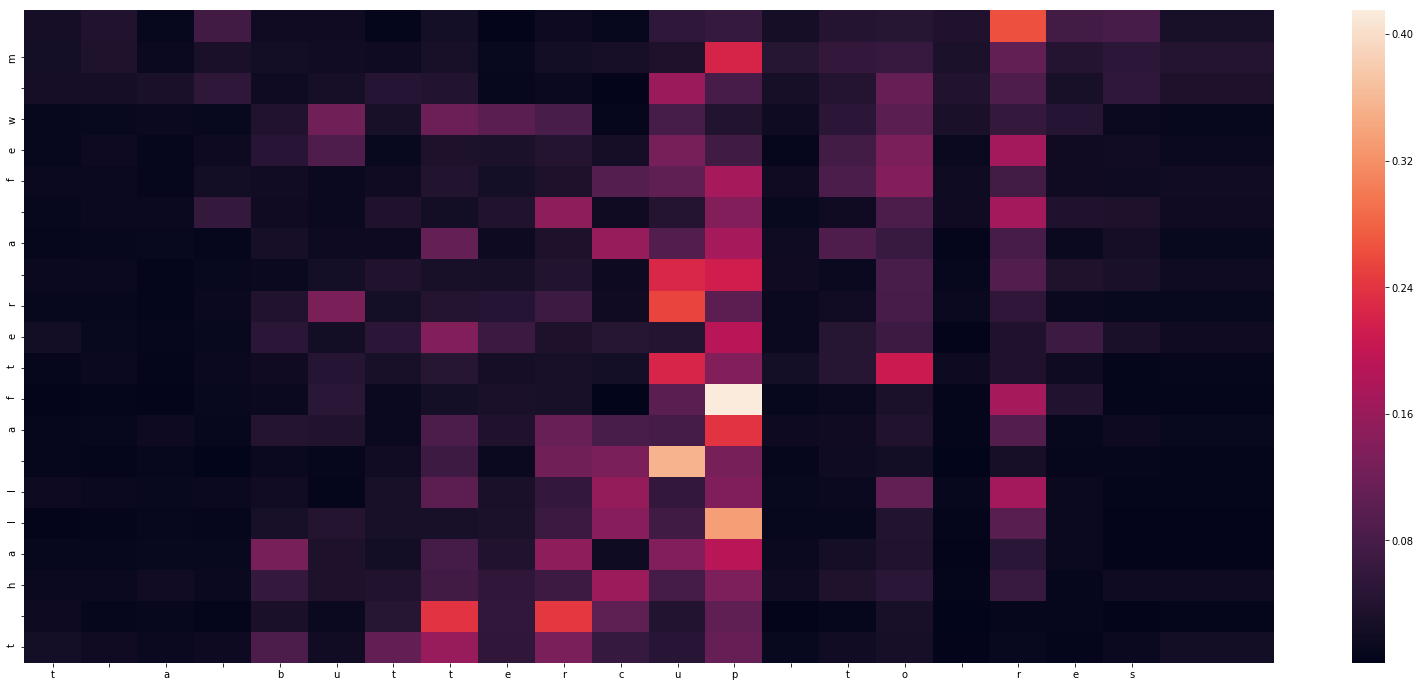

-
Input sentence: t a buttercup to res
GT sentence: t herself, and fanne
Decoded sentence: t hall after a few m


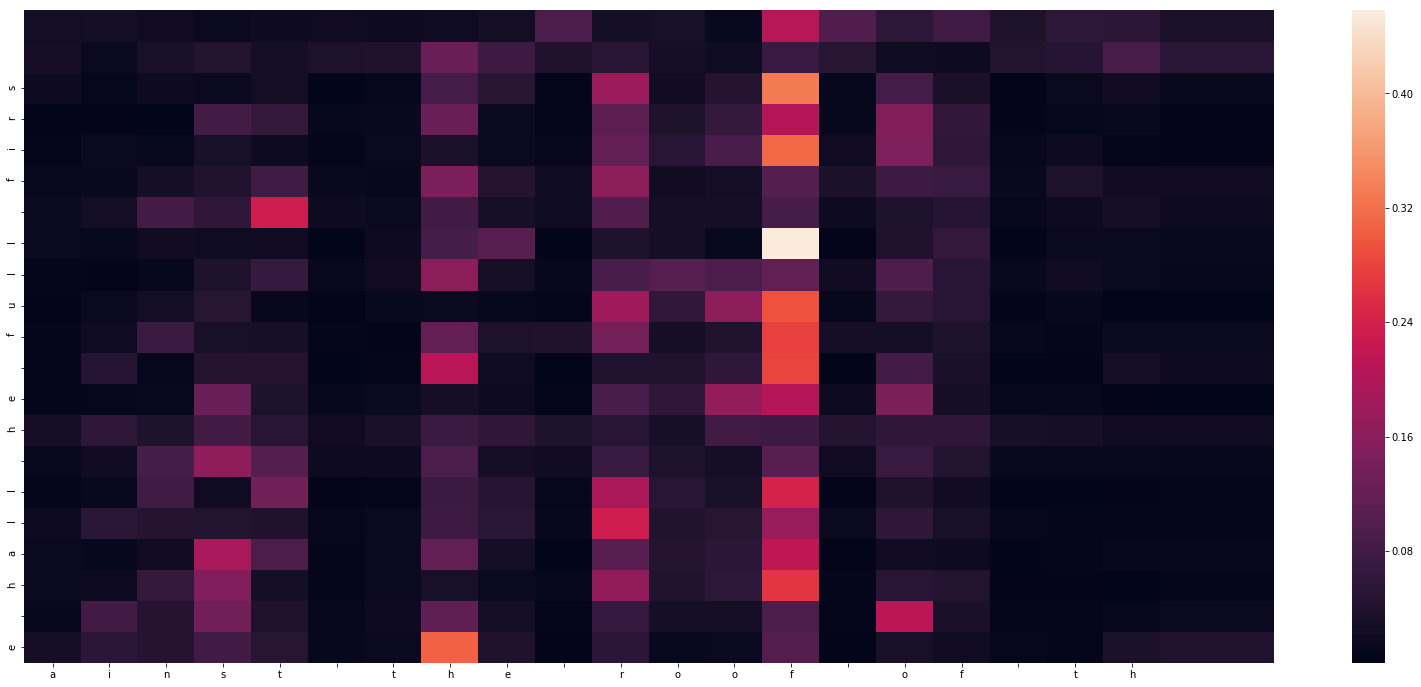

-
Input sentence: ainst the roof of th
GT sentence: e hall: in fact she 
Decoded sentence: e hall he full firs


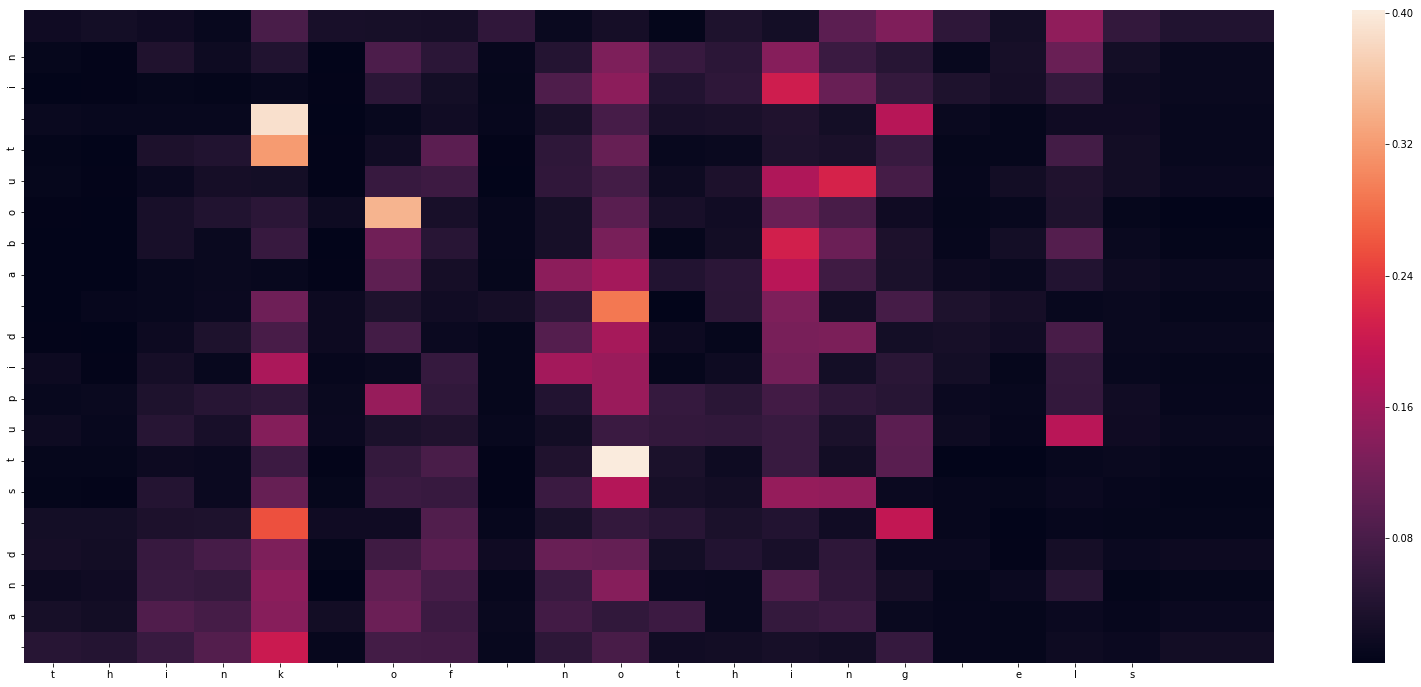

-
Input sentence: think of nothing els
GT sentence: e to say but 'It bel
Decoded sentence:  and stupid about in


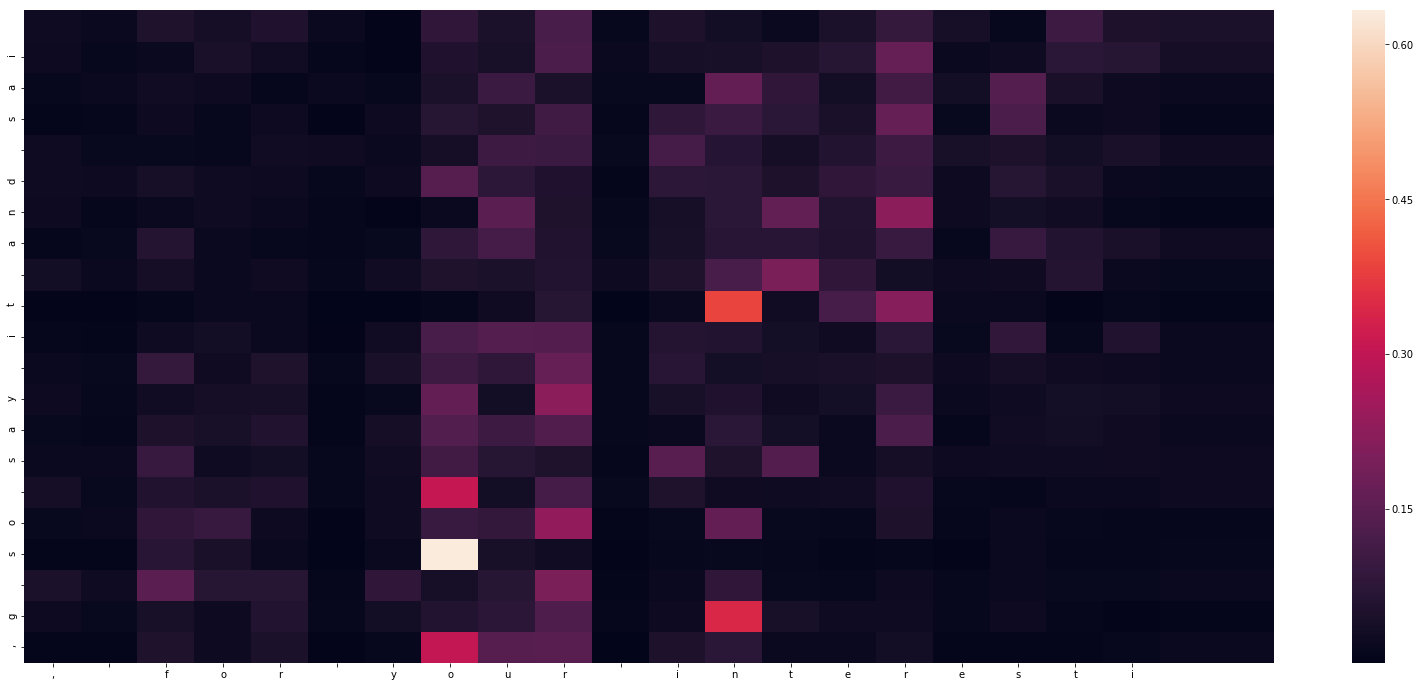

-
Input sentence: , for your interesti
GT sentence: ng story,' but she c
Decoded sentence: ,g so say it and sai


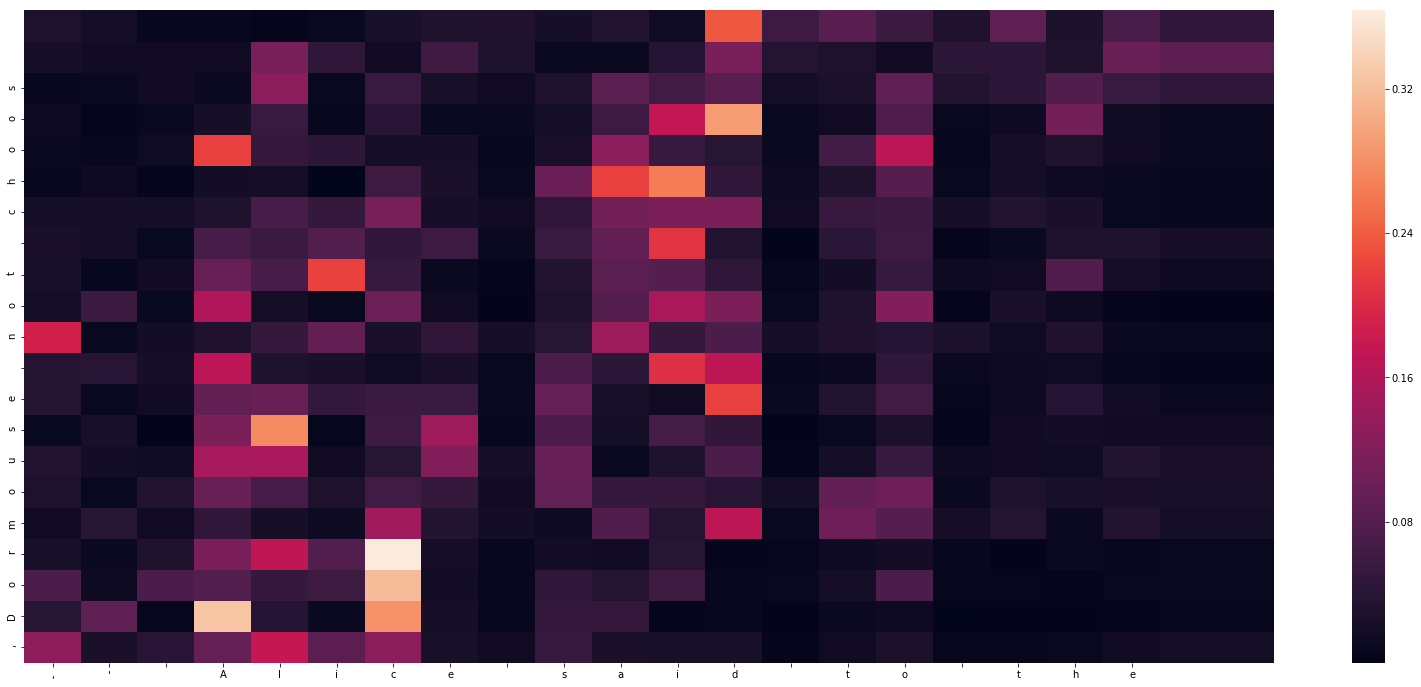

-
Input sentence: ,' Alice said to the
GT sentence:  Dormouse, not choos
Decoded sentence: ,Dormouse not choos


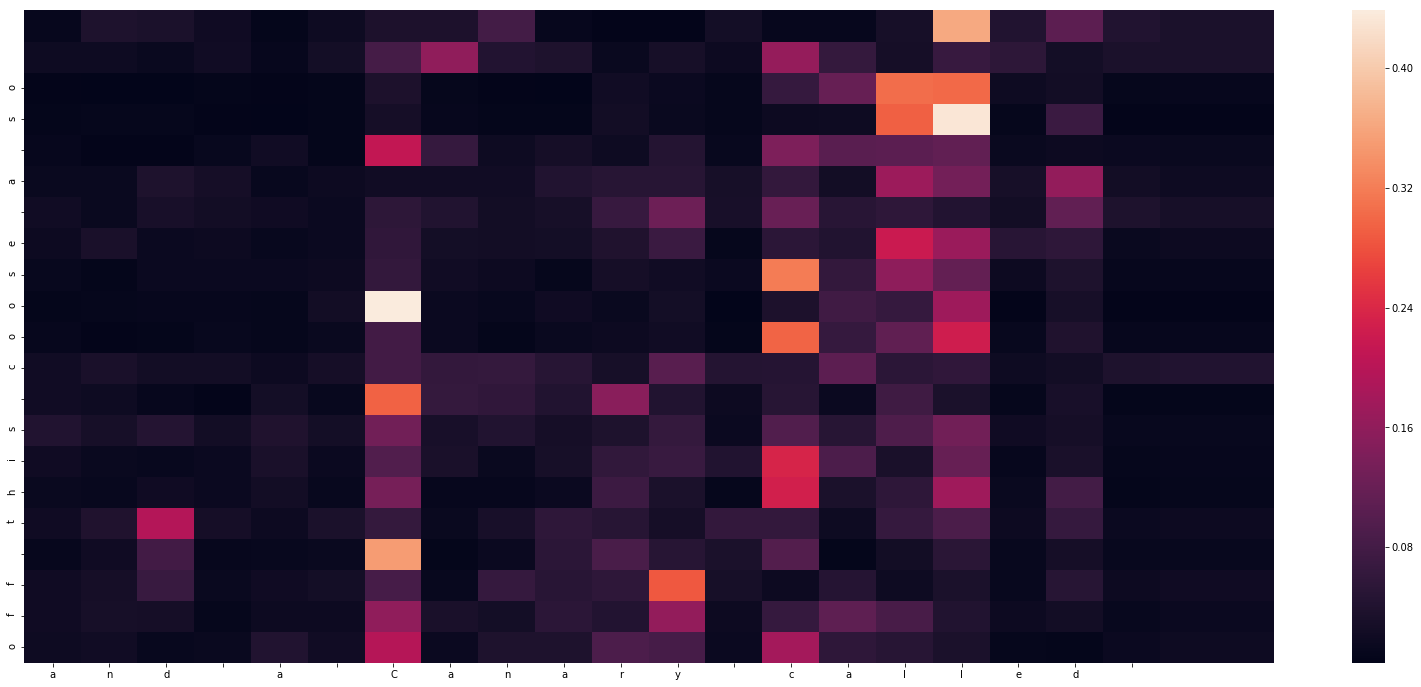

-
Input sentence: and a Canary called 
GT sentence: out in a trembling v
Decoded sentence: off this coose a so


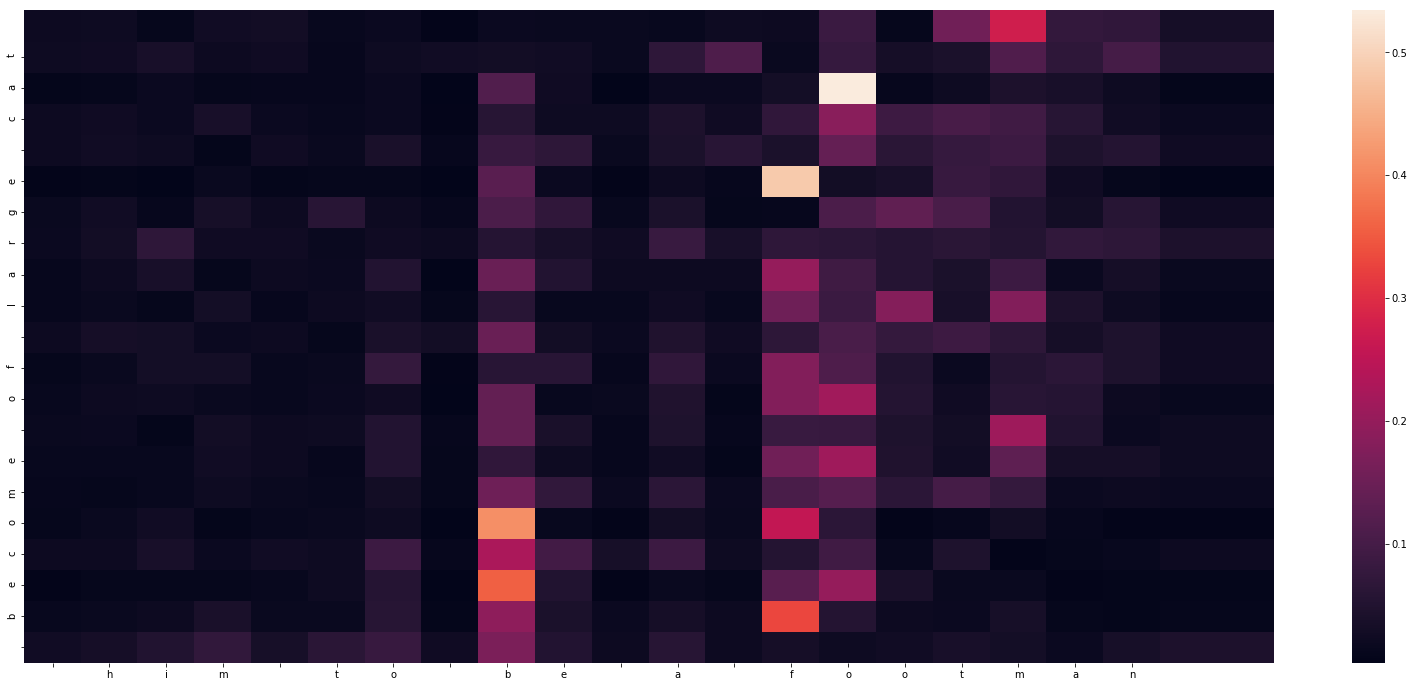

-
Input sentence:  him to be a footman
GT sentence:  because he was in l
Decoded sentence:  become of large cat


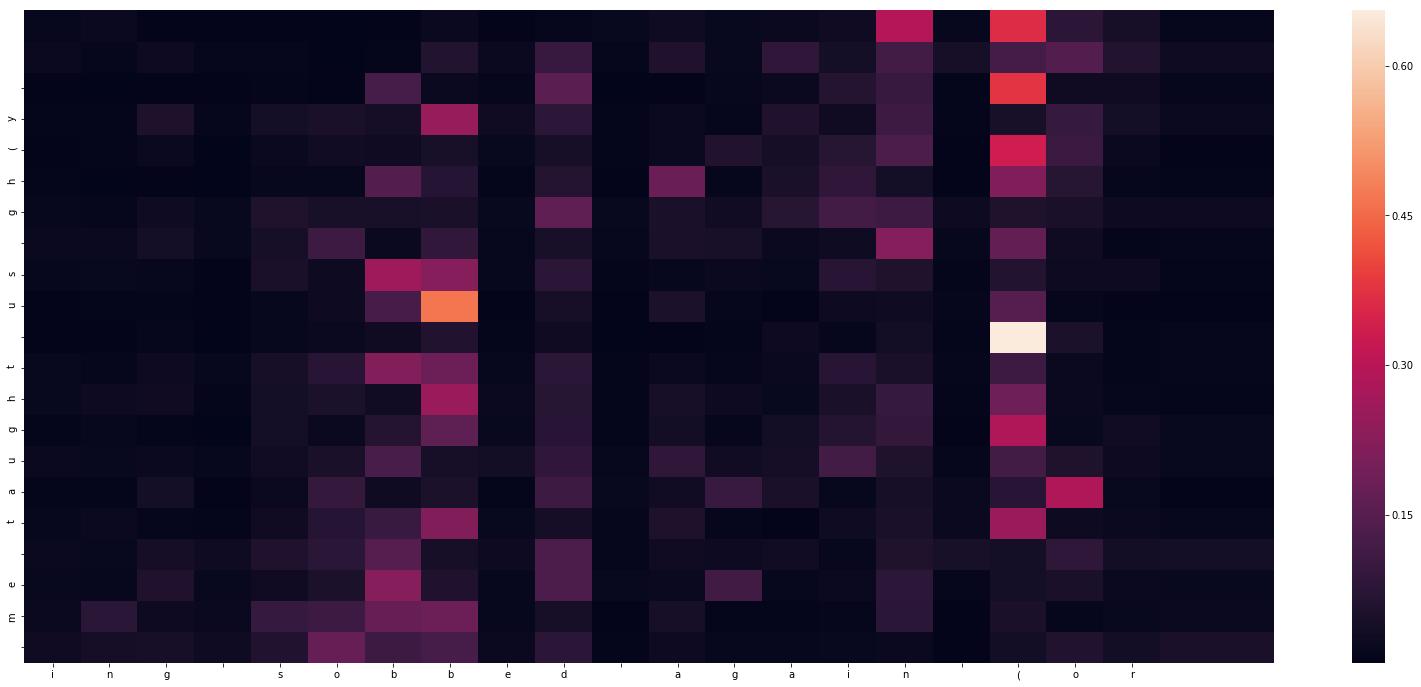

-
Input sentence: ing sobbed again (or
GT sentence:  grunted, it was imp
Decoded sentence:  me taught us gh(y 


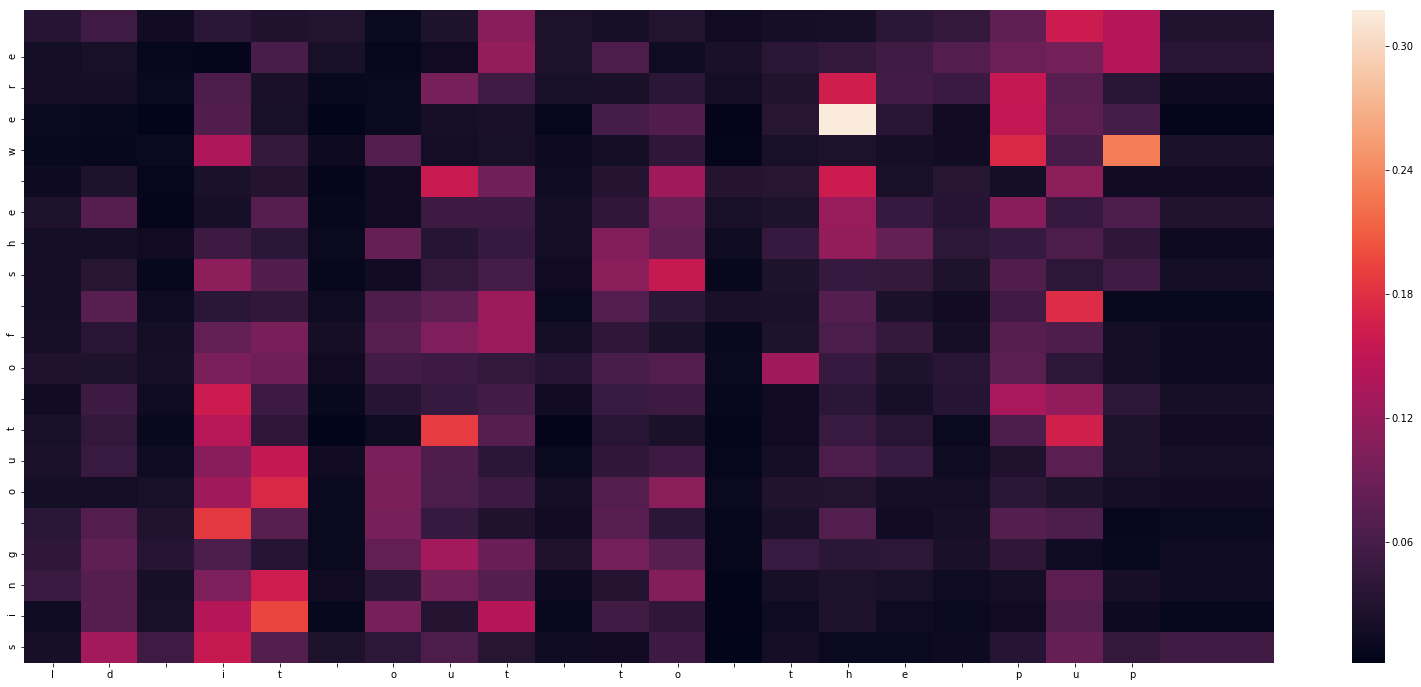

-
Input sentence: ld it out to the pup
GT sentence: py; whereupon the pu
Decoded sentence: sing out of she were


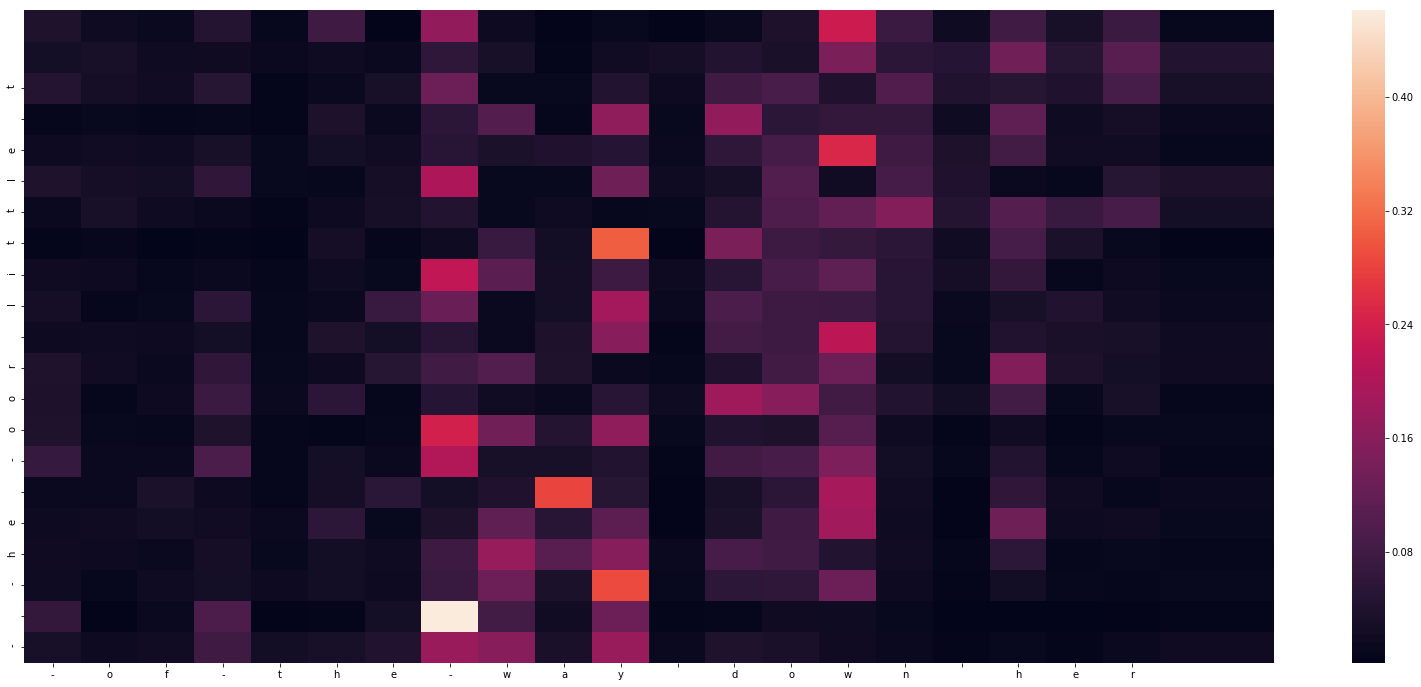

-
Input sentence: -of-the-way down her
GT sentence: e, that I should thi
Decoded sentence: - -he -oor little t


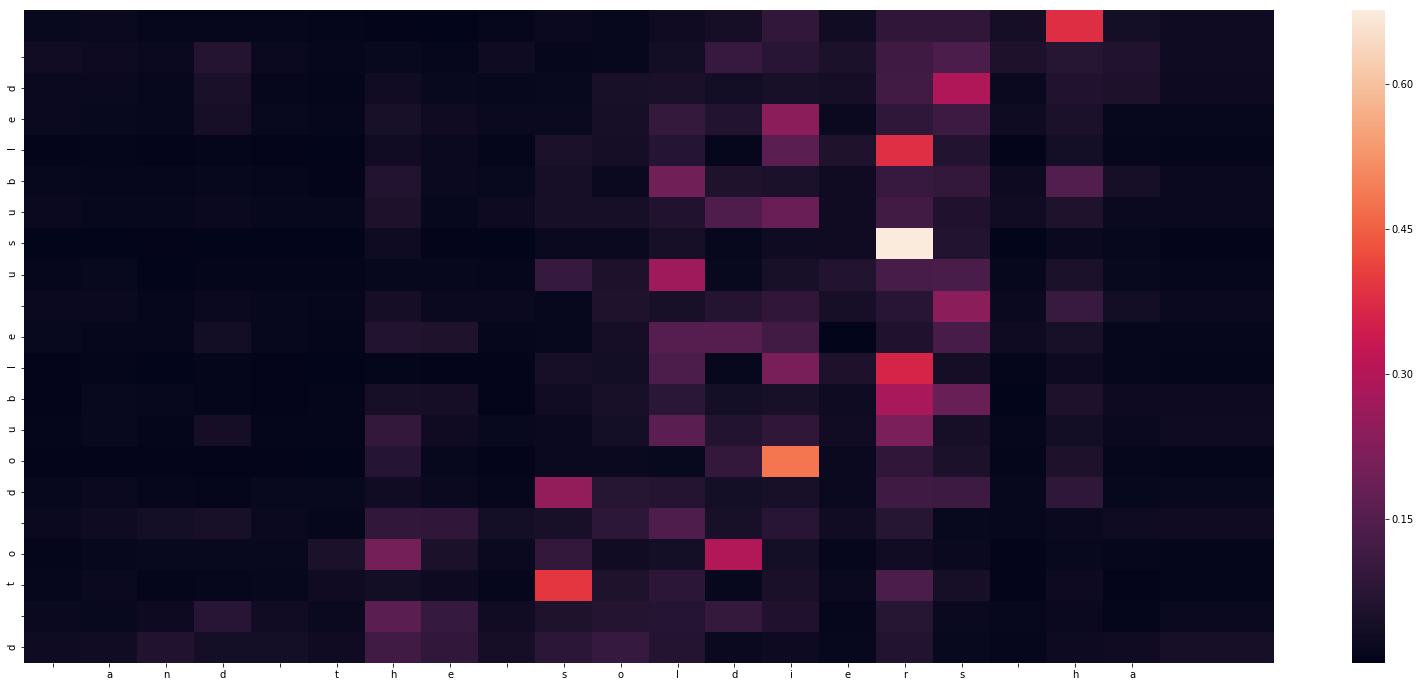

-
Input sentence:  and the soldiers ha
GT sentence: d to double themselv
Decoded sentence: d to double usubled 


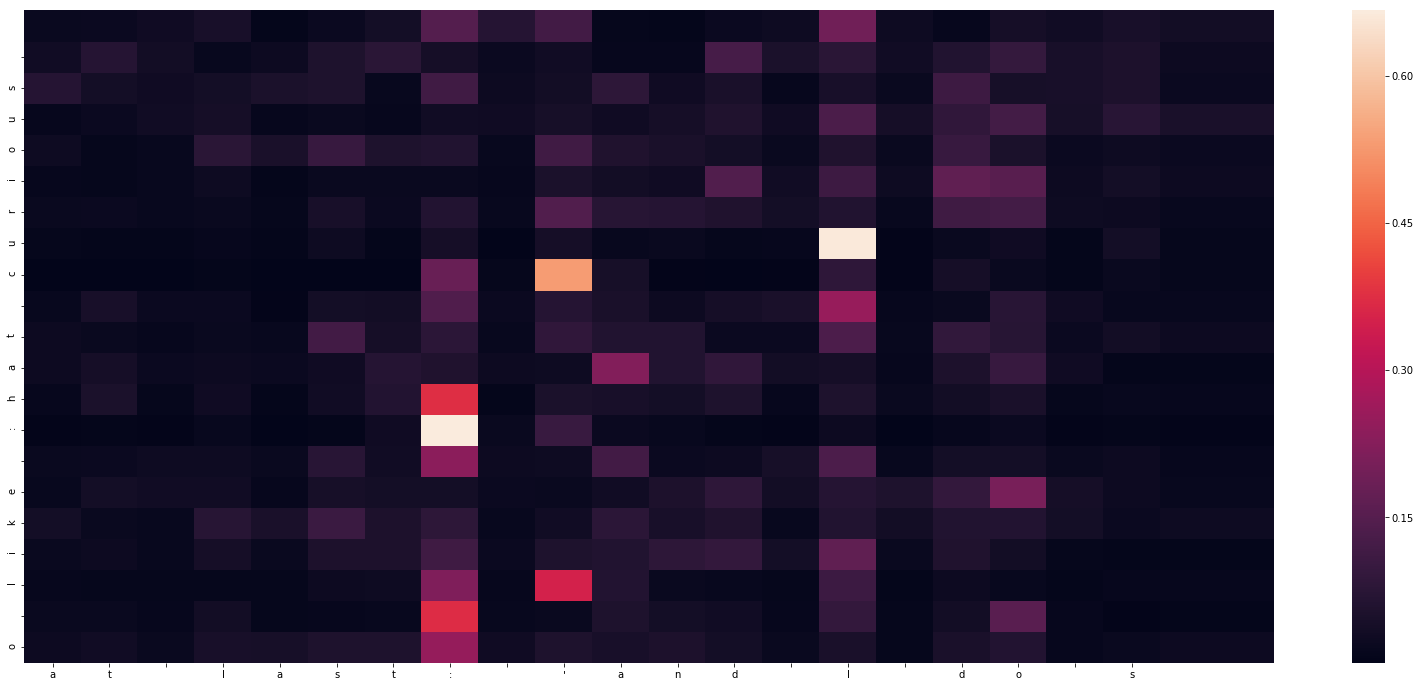

-
Input sentence: at last: 'and I do s
GT sentence: o like that curious 
Decoded sentence: o like :hat curious 


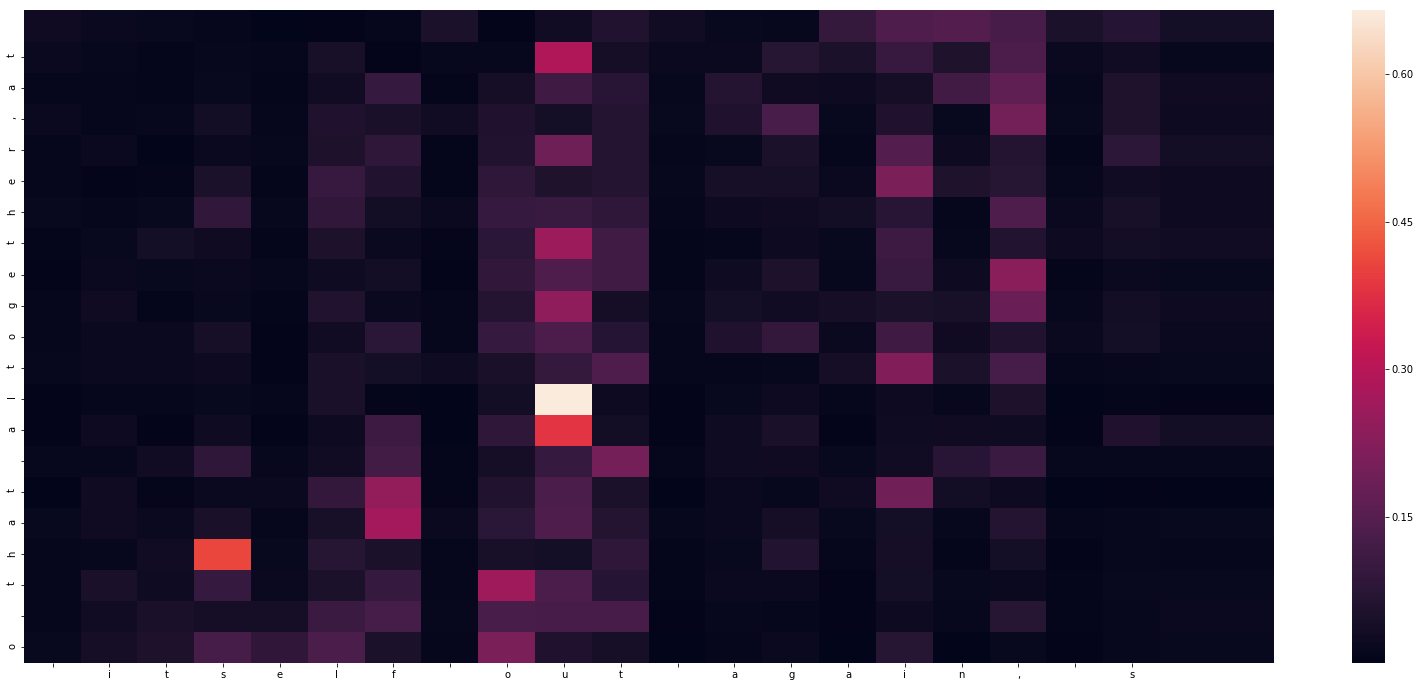

-
Input sentence:  itself out again, s
GT sentence: o that altogether, f
Decoded sentence: o that altogether,at


KeyboardInterrupt: 

In [28]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


# Test - Short inference

In [ ]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
corrected_sentences = []
corrected_input_sentences = []
results = open('RESULTS.md', 'w')
results.write('|OCR sentence|GT sentence|Decoded sentence|\n')
results.write('|------------|-----------|----------------|\n')
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = test_input_texts[seq_index]
    target_text = test_target_texts[seq_index][1:-1]

    encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[input_text],
                                                                                 target_texts=[target_text], 
                                                                                 max_encoder_seq_length=max_encoder_seq_length, 
                                                                                 num_encoder_tokens=num_encoder_tokens, 
                                                                                 vocab_to_int=vocab_to_int)    

    input_seq = encoder_input_data
    #target_seq = np.argmax(decoder_target_data, axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)
    results.write(' | ' + input_text + ' | ' + target_text.strip() + ' | ' + decoded_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    #corrected_sentences.append(corrected_sentence)
    #corrected_input_sentences.append(corrected_input_sentence)
    target_texts_.append(target_text)


encoder_input_data = vectorize_data(input_texts=input_texts, max_encoder_seq_length=max_encoder_seq_length, num_encoder_tokens=num_encoder_tokens, vocab_to_int=vocab_to_int)
    
results.close() 

In [ ]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  


# Decode single sentence as moving window

In [ ]:
seq_index = 100
text = input_texts[seq_index]
input_texts, target_texts = generate_lm_data(text, in_seq_len, out_seq_len)
for input_text, target_text in enumerate(zip(input_texts, target_texts)):
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    decoded_sentence = visualize_attention(input_text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('Decoded sentence:', decoded_sentence)  